
- Repeat for different actions - e.i. changing percent to sell or buy all
- Train n-step sarsa (n = 0, n = 2, n = 4, n = 10, n = 20)


- Try negative rewards
    - Repeat for different actions - e.i. changing percent to sell or buy all
    - Train MC and SARSA 
        - Compare which one performs better in training
        - Compare which one performs better on Test time period

- Plot percent of state space experienced
- Plot actions that resulted in Gain - may only be relevant for 100%  buy sell version




### NO SOFTMAX IN ENV

In [196]:


import pandas as pd
import numpy as np
import gym
from typing import Callable, Tuple
from collections import defaultdict
from tqdm import trange
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

from finrl import config
from finrl import config_tickers
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from environments.portfolio_without_softmax import StockPortfolioEnv
import os
from agents.single_stock_tabular import nstep_sarsa_single_stock

if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

print(config_tickers.DOW_30_TICKER)
#dp = YahooFinanceProcessor()
#df = dp.download_data


['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [197]:

df = YahooDownloader(start_date='2008-01-01',
                     end_date='2021-10-31',
                     ticker_list=config_tickers.DOW_30_TICKER).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [198]:
fe = FeatureEngineer(
    use_technical_indicator=True,
    use_turbulence=False,
    user_defined_feature=False)

df = fe.preprocess_data(df)

Successfully added technical indicators


In [199]:
## Add covariance matrix as states
# add covariance matrix as states
df = df.sort_values(['date', 'tic'], ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
return_list = []

# look back is one year
lookback = 252
for i in range(lookback, len(df.index.unique())):
    data_lookback = df.loc[i - lookback:i, :]
    price_lookback = data_lookback.pivot_table(index='date', columns='tic', values='close')
    return_lookback = price_lookback.pct_change().dropna()
    return_list.append(return_lookback)

    covs = return_lookback.cov().values
    cov_list.append(covs)

df_cov = pd.DataFrame({'date': df.date.unique()[lookback:], 'cov_list': cov_list, 'return_list': return_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date', 'tic']).reset_index(drop=True)

df.shape
df.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,2008-12-31,3.070357,3.133571,3.047857,2.583909,607541200,AAPL,2,-0.082603,3.093652,2.454291,42.254769,-80.462594,16.129793,2.749560,2.861671,"[[0.0013489688096897236, 0.0004284117740101603...",tic AAPL AMGN AXP ...
1,2008-12-31,57.110001,58.220001,57.060001,41.839512,6287200,AMGN,2,0.156756,42.707030,40.853195,51.060596,51.523195,10.432018,41.058033,40.603777,"[[0.0013489688096897236, 0.0004284117740101603...",tic AAPL AMGN AXP ...
2,2008-12-31,17.969999,18.750000,17.910000,14.580742,9625600,AXP,2,-0.935584,18.646870,12.660475,42.554807,-75.437812,25.776759,15.744065,17.616375,"[[0.0013489688096897236, 0.0004284117740101603...",tic AAPL AMGN AXP ...
3,2008-12-31,41.590000,43.049999,41.500000,32.005886,5443100,BA,2,-0.279799,32.174387,28.867835,47.440234,156.994663,5.366299,30.327215,32.389916,"[[0.0013489688096897236, 0.0004284117740101603...",tic AAPL AMGN AXP ...
4,2008-12-31,43.700001,45.099998,43.700001,29.608656,6277400,CAT,2,0.655611,30.348089,25.455654,51.205310,98.374131,26.331746,26.689552,26.423592,"[[0.0013489688096897236, 0.0004284117740101603...",tic AAPL AMGN AXP ...


In [200]:
TRAIN_START = '2009-01-01'
TRAIN_END ='2020-07-01'
TEST_START = '2020-07-01'
TEST_END = '2021-10-31'

train = data_split(df, TRAIN_START, TRAIN_END)
trade = data_split(df,TEST_START, TEST_END)

In [201]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.INDICATORS, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}


Stock Dimension: 28, State Space: 28


In [233]:
EPISODES = 500
TEST_TRIALS = 100

In [203]:
two_step_sarsa_env = StockPortfolioEnv(df = train, **env_kwargs)

In [204]:
two_step_sarsa_post_training_env, two_step_sarsa_training_episodes, two_step_sarsa_Q = nstep_sarsa_single_stock(two_step_sarsa_env, num_episodes=EPISODES, gamma=0.99, epsilon=0.1, step_size=0.5, n=2, stock=0, aggressive=True)

Episode:   0%|          | 1/250 [00:04<17:56,  4.32s/it]

begin_total_asset:1000000
end_total_asset:4616201.617926749
Sharpe:  0.7476587003479751


Episode:   1%|          | 2/250 [00:08<17:26,  4.22s/it]

begin_total_asset:1000000
end_total_asset:7647822.417707408
Sharpe:  1.04322578499644


Episode:   1%|          | 3/250 [00:13<19:02,  4.62s/it]

begin_total_asset:1000000
end_total_asset:3145098.100158356
Sharpe:  0.6041014224718216


Episode:   2%|▏         | 4/250 [00:17<18:05,  4.41s/it]

begin_total_asset:1000000
end_total_asset:4172495.483264937
Sharpe:  0.7049485565727404


Episode:   2%|▏         | 5/250 [00:21<17:11,  4.21s/it]

begin_total_asset:1000000
end_total_asset:4040202.6828841036
Sharpe:  0.722187671084018


Episode:   2%|▏         | 6/250 [00:25<16:53,  4.15s/it]

begin_total_asset:1000000
end_total_asset:8104620.061783263
Sharpe:  0.9885927266343072


Episode:   3%|▎         | 7/250 [00:30<17:52,  4.41s/it]

begin_total_asset:1000000
end_total_asset:13164080.586154595
Sharpe:  1.255631631261591


Episode:   3%|▎         | 8/250 [00:34<17:22,  4.31s/it]

begin_total_asset:1000000
end_total_asset:5552144.051685474
Sharpe:  0.8784458626856058


Episode:   4%|▎         | 9/250 [00:38<16:52,  4.20s/it]

begin_total_asset:1000000
end_total_asset:6851615.370173597
Sharpe:  0.9370177023216666


Episode:   4%|▍         | 10/250 [01:01<40:16, 10.07s/it]

begin_total_asset:1000000
end_total_asset:3743686.845092137
Sharpe:  0.6799475862869194


Episode:   4%|▍         | 11/250 [01:05<32:19,  8.11s/it]

begin_total_asset:1000000
end_total_asset:3751667.4696074785
Sharpe:  0.6785974392243725


Episode:   5%|▍         | 12/250 [01:09<26:52,  6.78s/it]

begin_total_asset:1000000
end_total_asset:2413147.4062817325
Sharpe:  0.4881768139699791


Episode:   5%|▌         | 13/250 [01:12<23:06,  5.85s/it]

begin_total_asset:1000000
end_total_asset:6853134.982722794
Sharpe:  0.9725634660815338


Episode:   6%|▌         | 14/250 [01:16<20:28,  5.21s/it]

begin_total_asset:1000000
end_total_asset:3458431.4127418855
Sharpe:  0.6437953710716315


Episode:   6%|▌         | 15/250 [01:20<18:38,  4.76s/it]

begin_total_asset:1000000
end_total_asset:6626735.832383672
Sharpe:  0.9973735016035935


Episode:   6%|▋         | 16/250 [01:23<17:10,  4.41s/it]

begin_total_asset:1000000
end_total_asset:5231183.495119182
Sharpe:  0.8847563110495789


Episode:   7%|▋         | 17/250 [01:27<16:18,  4.20s/it]

begin_total_asset:1000000
end_total_asset:10527530.886008535
Sharpe:  1.0989339006484933


Episode:   7%|▋         | 18/250 [01:31<15:35,  4.03s/it]

begin_total_asset:1000000
end_total_asset:6378378.3833716735
Sharpe:  0.9338183713746216


Episode:   8%|▊         | 19/250 [01:35<15:16,  3.97s/it]

begin_total_asset:1000000
end_total_asset:4026559.9945554696
Sharpe:  0.7106978111224438


Episode:   8%|▊         | 20/250 [01:38<14:49,  3.87s/it]

begin_total_asset:1000000
end_total_asset:12891373.29059802
Sharpe:  1.2327061723824821


Episode:   8%|▊         | 21/250 [01:42<14:36,  3.83s/it]

begin_total_asset:1000000
end_total_asset:5149771.625319391
Sharpe:  0.8290119870754874


Episode:   9%|▉         | 22/250 [01:46<14:14,  3.75s/it]

begin_total_asset:1000000
end_total_asset:7684981.525509979
Sharpe:  0.9974654831394103


Episode:   9%|▉         | 23/250 [01:49<14:12,  3.76s/it]

begin_total_asset:1000000
end_total_asset:7449438.99791275
Sharpe:  0.9611657408519346


Episode:  10%|▉         | 24/250 [01:53<14:04,  3.74s/it]

begin_total_asset:1000000
end_total_asset:2777905.1600785465
Sharpe:  0.5565934292402099


Episode:  10%|█         | 25/250 [01:57<13:52,  3.70s/it]

begin_total_asset:1000000
end_total_asset:5956681.408911934
Sharpe:  0.8855749181164122


Episode:  10%|█         | 26/250 [02:00<13:54,  3.73s/it]

begin_total_asset:1000000
end_total_asset:7560931.921256977
Sharpe:  1.042410871618315


Episode:  11%|█         | 27/250 [02:04<13:47,  3.71s/it]

begin_total_asset:1000000
end_total_asset:14014592.93008012
Sharpe:  1.2575871440504534


Episode:  11%|█         | 28/250 [02:08<14:32,  3.93s/it]

begin_total_asset:1000000
end_total_asset:5937931.273824508
Sharpe:  0.8665387187678789


Episode:  12%|█▏        | 29/250 [02:13<14:39,  3.98s/it]

begin_total_asset:1000000
end_total_asset:3384237.47741892
Sharpe:  0.6297023505037208


Episode:  12%|█▏        | 30/250 [02:16<14:29,  3.95s/it]

begin_total_asset:1000000
end_total_asset:4556128.23540369
Sharpe:  0.7480737422306359


Episode:  12%|█▏        | 31/250 [02:21<14:30,  3.98s/it]

begin_total_asset:1000000
end_total_asset:9238448.503841978
Sharpe:  1.070896970507449


Episode:  13%|█▎        | 32/250 [02:25<14:37,  4.03s/it]

begin_total_asset:1000000
end_total_asset:3245040.490213152
Sharpe:  0.6123192830473703


Episode:  13%|█▎        | 33/250 [02:28<14:10,  3.92s/it]

begin_total_asset:1000000
end_total_asset:12192946.55129983
Sharpe:  1.2253559739074178


Episode:  14%|█▎        | 34/250 [02:32<14:01,  3.90s/it]

begin_total_asset:1000000
end_total_asset:4556177.308474886
Sharpe:  0.7831623530388371


Episode:  14%|█▍        | 35/250 [02:36<14:10,  3.96s/it]

begin_total_asset:1000000
end_total_asset:7781414.708170862
Sharpe:  0.9532213682979117


Episode:  14%|█▍        | 36/250 [02:40<13:55,  3.90s/it]

begin_total_asset:1000000
end_total_asset:24583564.913007542
Sharpe:  1.5061500183518775


Episode:  15%|█▍        | 37/250 [02:44<13:35,  3.83s/it]

begin_total_asset:1000000
end_total_asset:4131642.469329966
Sharpe:  0.728831503813325


Episode:  15%|█▌        | 38/250 [02:47<13:29,  3.82s/it]

begin_total_asset:1000000
end_total_asset:5546625.852993387
Sharpe:  0.8539116100721077


Episode:  16%|█▌        | 39/250 [02:52<13:46,  3.92s/it]

begin_total_asset:1000000
end_total_asset:7961858.7689488875
Sharpe:  0.9979301687411876


Episode:  16%|█▌        | 40/250 [02:56<13:46,  3.94s/it]

begin_total_asset:1000000
end_total_asset:7393347.964663447
Sharpe:  1.016057974366481


Episode:  16%|█▋        | 41/250 [03:00<13:49,  3.97s/it]

begin_total_asset:1000000
end_total_asset:3688729.3230872997
Sharpe:  0.6641251438066209


Episode:  17%|█▋        | 42/250 [03:04<13:54,  4.01s/it]

begin_total_asset:1000000
end_total_asset:3740042.1564824223
Sharpe:  0.6676987361215334


Episode:  17%|█▋        | 43/250 [03:08<13:37,  3.95s/it]

begin_total_asset:1000000
end_total_asset:3064533.0132138995
Sharpe:  0.5900383783431368


Episode:  18%|█▊        | 44/250 [03:11<13:19,  3.88s/it]

begin_total_asset:1000000
end_total_asset:3558915.5890897205
Sharpe:  0.6496762874923636


Episode:  18%|█▊        | 45/250 [03:15<13:17,  3.89s/it]

begin_total_asset:1000000
end_total_asset:3890804.898450663
Sharpe:  0.6883520384899359


Episode:  18%|█▊        | 46/250 [03:19<13:06,  3.86s/it]

begin_total_asset:1000000
end_total_asset:2957522.4656355004
Sharpe:  0.5854828930391035


Episode:  19%|█▉        | 47/250 [03:23<13:26,  3.97s/it]

begin_total_asset:1000000
end_total_asset:9239541.386781614
Sharpe:  1.0518050126489282


Episode:  19%|█▉        | 48/250 [03:27<13:06,  3.89s/it]

begin_total_asset:1000000
end_total_asset:6473333.2722436385
Sharpe:  0.9014380271223924


Episode:  20%|█▉        | 49/250 [03:31<12:47,  3.82s/it]

begin_total_asset:1000000
end_total_asset:4092742.5524001927
Sharpe:  0.7105431725677871


Episode:  20%|██        | 50/250 [03:35<13:05,  3.93s/it]

begin_total_asset:1000000
end_total_asset:7812817.325038496
Sharpe:  1.0018640048580054


Episode:  20%|██        | 51/250 [03:39<13:06,  3.95s/it]

begin_total_asset:1000000
end_total_asset:4301458.570857447
Sharpe:  0.734633073436534


Episode:  21%|██        | 52/250 [03:43<12:49,  3.89s/it]

begin_total_asset:1000000
end_total_asset:3599752.7723408868
Sharpe:  0.6461011575661593


Episode:  21%|██        | 53/250 [03:47<13:00,  3.96s/it]

begin_total_asset:1000000
end_total_asset:5121617.998848212
Sharpe:  0.8106117348091865


Episode:  22%|██▏       | 54/250 [03:50<12:41,  3.89s/it]

begin_total_asset:1000000
end_total_asset:5310131.540602877
Sharpe:  0.8168595893076684


Episode:  22%|██▏       | 55/250 [03:54<12:27,  3.83s/it]

begin_total_asset:1000000
end_total_asset:6886042.896401598
Sharpe:  1.0089574345973031


Episode:  22%|██▏       | 56/250 [03:58<12:24,  3.84s/it]

begin_total_asset:1000000
end_total_asset:4434014.144498844
Sharpe:  0.7497691761293592


Episode:  23%|██▎       | 57/250 [04:02<12:18,  3.82s/it]

begin_total_asset:1000000
end_total_asset:10457502.66087152
Sharpe:  1.1312694486551382


Episode:  23%|██▎       | 58/250 [04:05<12:03,  3.77s/it]

begin_total_asset:1000000
end_total_asset:4646895.648618074
Sharpe:  0.7521715264909423


Episode:  24%|██▎       | 59/250 [04:09<11:55,  3.75s/it]

begin_total_asset:1000000
end_total_asset:3732784.733542599
Sharpe:  0.6925305828587651


Episode:  24%|██▍       | 60/250 [04:13<12:17,  3.88s/it]

begin_total_asset:1000000
end_total_asset:10226562.551264586
Sharpe:  1.1034305879994726


Episode:  24%|██▍       | 61/250 [04:17<12:14,  3.89s/it]

begin_total_asset:1000000
end_total_asset:8295977.002502158
Sharpe:  1.0139218847341525


Episode:  25%|██▍       | 62/250 [04:21<12:12,  3.90s/it]

begin_total_asset:1000000
end_total_asset:2731112.034004895
Sharpe:  0.529788405958107


Episode:  25%|██▌       | 63/250 [04:25<12:23,  3.98s/it]

begin_total_asset:1000000
end_total_asset:8129260.928147201
Sharpe:  1.0362283785819923


Episode:  26%|██▌       | 64/250 [04:29<12:03,  3.89s/it]

begin_total_asset:1000000
end_total_asset:5619699.931076406
Sharpe:  0.8660684192664905


Episode:  26%|██▌       | 65/250 [04:33<12:16,  3.98s/it]

begin_total_asset:1000000
end_total_asset:6161994.392175274
Sharpe:  0.8890408068941553


Episode:  26%|██▋       | 66/250 [04:37<12:12,  3.98s/it]

begin_total_asset:1000000
end_total_asset:5739245.012132618
Sharpe:  0.8617482467383892


Episode:  27%|██▋       | 67/250 [04:41<12:07,  3.97s/it]

begin_total_asset:1000000
end_total_asset:5707268.307330315
Sharpe:  0.8638067550744242


Episode:  27%|██▋       | 68/250 [04:45<12:04,  3.98s/it]

begin_total_asset:1000000
end_total_asset:4261279.089405647
Sharpe:  0.7246669483482372


Episode:  28%|██▊       | 69/250 [04:50<12:57,  4.30s/it]

begin_total_asset:1000000
end_total_asset:4818714.998007211
Sharpe:  0.7625653991695314


Episode:  28%|██▊       | 70/250 [04:54<12:44,  4.25s/it]

begin_total_asset:1000000
end_total_asset:6206767.039289731
Sharpe:  0.8495228210257717


Episode:  28%|██▊       | 71/250 [04:58<12:12,  4.09s/it]

begin_total_asset:1000000
end_total_asset:5951566.996697156
Sharpe:  0.8858906091993562


Episode:  29%|██▉       | 72/250 [05:02<11:44,  3.96s/it]

begin_total_asset:1000000
end_total_asset:15896795.63776864
Sharpe:  1.3346307253835334


Episode:  29%|██▉       | 73/250 [05:05<11:34,  3.92s/it]

begin_total_asset:1000000
end_total_asset:7561894.137232461
Sharpe:  0.9541333697589061


Episode:  30%|██▉       | 74/250 [05:09<11:26,  3.90s/it]

begin_total_asset:1000000
end_total_asset:6207230.736884858
Sharpe:  0.8953467311426411


Episode:  30%|███       | 75/250 [05:13<11:27,  3.93s/it]

begin_total_asset:1000000
end_total_asset:5780963.593672193
Sharpe:  0.8843403141794022


Episode:  30%|███       | 76/250 [05:17<11:17,  3.90s/it]

begin_total_asset:1000000
end_total_asset:7542760.740895832
Sharpe:  0.9557815559230112


Episode:  31%|███       | 77/250 [05:21<11:07,  3.86s/it]

begin_total_asset:1000000
end_total_asset:7537753.192019494
Sharpe:  0.9708355974885732


Episode:  31%|███       | 78/250 [05:25<11:26,  3.99s/it]

begin_total_asset:1000000
end_total_asset:7975274.360450421
Sharpe:  1.0266538979905042


Episode:  32%|███▏      | 79/250 [05:29<11:26,  4.01s/it]

begin_total_asset:1000000
end_total_asset:5117710.621150807
Sharpe:  0.7849851109791736


Episode:  32%|███▏      | 80/250 [05:33<11:11,  3.95s/it]

begin_total_asset:1000000
end_total_asset:1263207.5594454948
Sharpe:  0.20262963635164163


Episode:  32%|███▏      | 81/250 [05:37<11:20,  4.02s/it]

begin_total_asset:1000000
end_total_asset:14095893.200977024
Sharpe:  1.2341590646905967


Episode:  33%|███▎      | 82/250 [05:41<11:10,  3.99s/it]

begin_total_asset:1000000
end_total_asset:7368500.673356046
Sharpe:  0.9467074013224569


Episode:  33%|███▎      | 83/250 [05:45<11:20,  4.08s/it]

begin_total_asset:1000000
end_total_asset:4761673.058354412
Sharpe:  0.7843738196488103


Episode:  34%|███▎      | 84/250 [05:50<11:18,  4.09s/it]

begin_total_asset:1000000
end_total_asset:5295851.738753226
Sharpe:  0.8423739192146056


Episode:  34%|███▍      | 85/250 [05:54<11:13,  4.08s/it]

begin_total_asset:1000000
end_total_asset:3088491.3081209715
Sharpe:  0.5941265753015307


Episode:  34%|███▍      | 86/250 [05:57<10:54,  3.99s/it]

begin_total_asset:1000000
end_total_asset:5337915.682045498
Sharpe:  0.8218373668935804


Episode:  35%|███▍      | 87/250 [06:01<10:56,  4.03s/it]

begin_total_asset:1000000
end_total_asset:8709576.871647421
Sharpe:  0.9996551758086804


Episode:  35%|███▌      | 88/250 [06:06<10:52,  4.03s/it]

begin_total_asset:1000000
end_total_asset:3894240.8857936347
Sharpe:  0.6802062078801558


Episode:  36%|███▌      | 89/250 [06:09<10:44,  4.00s/it]

begin_total_asset:1000000
end_total_asset:4598604.712358954
Sharpe:  0.7468674301052185


Episode:  36%|███▌      | 90/250 [06:14<11:12,  4.20s/it]

begin_total_asset:1000000
end_total_asset:3489229.37260621
Sharpe:  0.6521542625857596


Episode:  36%|███▋      | 91/250 [06:18<11:12,  4.23s/it]

begin_total_asset:1000000
end_total_asset:6222752.705563067
Sharpe:  0.9262277200392836


Episode:  37%|███▋      | 92/250 [06:23<11:39,  4.43s/it]

begin_total_asset:1000000
end_total_asset:5333573.609764704
Sharpe:  0.8184770246958414


Episode:  37%|███▋      | 93/250 [06:27<11:15,  4.30s/it]

begin_total_asset:1000000
end_total_asset:3569373.777603683
Sharpe:  0.66006115270595


Episode:  38%|███▊      | 94/250 [06:31<11:02,  4.25s/it]

begin_total_asset:1000000
end_total_asset:3471726.622401896
Sharpe:  0.6312015135096855


Episode:  38%|███▊      | 95/250 [06:36<10:54,  4.22s/it]

begin_total_asset:1000000
end_total_asset:2794816.4674311313
Sharpe:  0.539901839006044


Episode:  38%|███▊      | 96/250 [06:40<10:44,  4.19s/it]

begin_total_asset:1000000
end_total_asset:3489289.2463566144
Sharpe:  0.6330875653154759


Episode:  39%|███▉      | 97/250 [06:44<10:40,  4.18s/it]

begin_total_asset:1000000
end_total_asset:7266051.202501286
Sharpe:  0.9628391195739132


Episode:  39%|███▉      | 98/250 [06:48<10:29,  4.14s/it]

begin_total_asset:1000000
end_total_asset:4444287.558246525
Sharpe:  0.7130965149937607


Episode:  40%|███▉      | 99/250 [06:52<10:12,  4.06s/it]

begin_total_asset:1000000
end_total_asset:6483403.932051525
Sharpe:  0.9277896239095277


Episode:  40%|████      | 100/250 [06:56<10:24,  4.16s/it]

begin_total_asset:1000000
end_total_asset:14077235.889568316
Sharpe:  1.24075770625282


Episode:  40%|████      | 101/250 [07:01<10:36,  4.27s/it]

begin_total_asset:1000000
end_total_asset:3120321.608188219
Sharpe:  0.5933538259127153


Episode:  41%|████      | 102/250 [07:05<10:48,  4.38s/it]

begin_total_asset:1000000
end_total_asset:3333287.8141691843
Sharpe:  0.6054272006097448


Episode:  41%|████      | 103/250 [07:10<11:11,  4.57s/it]

begin_total_asset:1000000
end_total_asset:8793343.349691143
Sharpe:  1.0224793429642147


Episode:  42%|████▏     | 104/250 [07:15<11:11,  4.60s/it]

begin_total_asset:1000000
end_total_asset:4035324.416891558
Sharpe:  0.7062653141866423


Episode:  42%|████▏     | 105/250 [07:19<10:40,  4.42s/it]

begin_total_asset:1000000
end_total_asset:2873331.583518001
Sharpe:  0.547115117333804


Episode:  42%|████▏     | 106/250 [07:23<10:19,  4.30s/it]

begin_total_asset:1000000
end_total_asset:4530043.474581595
Sharpe:  0.7309784722730616


Episode:  43%|████▎     | 107/250 [07:27<10:00,  4.20s/it]

begin_total_asset:1000000
end_total_asset:4427482.323017429
Sharpe:  0.7532063985525461


Episode:  43%|████▎     | 108/250 [07:31<10:06,  4.27s/it]

begin_total_asset:1000000
end_total_asset:3297651.0444589113
Sharpe:  0.6292622080511464


Episode:  44%|████▎     | 109/250 [07:35<09:44,  4.14s/it]

begin_total_asset:1000000
end_total_asset:7957489.978270797
Sharpe:  1.0149632112070994


Episode:  44%|████▍     | 110/250 [07:39<09:33,  4.10s/it]

begin_total_asset:1000000
end_total_asset:4557429.955959917
Sharpe:  0.7719460724488664


Episode:  44%|████▍     | 111/250 [07:44<09:56,  4.29s/it]

begin_total_asset:1000000
end_total_asset:4540645.88080424
Sharpe:  0.7633600490849349


Episode:  45%|████▍     | 112/250 [07:48<09:49,  4.27s/it]

begin_total_asset:1000000
end_total_asset:4525791.018235303
Sharpe:  0.7493834354404871


Episode:  45%|████▌     | 113/250 [07:53<09:44,  4.27s/it]

begin_total_asset:1000000
end_total_asset:4185822.2292000167
Sharpe:  0.7239583600031196


Episode:  46%|████▌     | 114/250 [07:57<09:37,  4.25s/it]

begin_total_asset:1000000
end_total_asset:9213305.361618051
Sharpe:  1.041376357840726


Episode:  46%|████▌     | 115/250 [08:01<09:24,  4.18s/it]

begin_total_asset:1000000
end_total_asset:8537406.410214141
Sharpe:  1.0897548807620367


Episode:  46%|████▋     | 116/250 [08:05<09:21,  4.19s/it]

begin_total_asset:1000000
end_total_asset:4787887.43537963
Sharpe:  0.791259719300569


Episode:  47%|████▋     | 117/250 [08:10<10:08,  4.57s/it]

begin_total_asset:1000000
end_total_asset:7154849.641713251
Sharpe:  0.9627758677750378


Episode:  47%|████▋     | 118/250 [08:15<09:56,  4.52s/it]

begin_total_asset:1000000
end_total_asset:5371895.812825117
Sharpe:  0.8202447857035216


Episode:  48%|████▊     | 119/250 [08:19<09:40,  4.43s/it]

begin_total_asset:1000000
end_total_asset:7890052.629391981
Sharpe:  0.979800296044872


Episode:  48%|████▊     | 120/250 [08:23<09:16,  4.28s/it]

begin_total_asset:1000000
end_total_asset:3377656.8660873044
Sharpe:  0.6447394106703561


Episode:  48%|████▊     | 121/250 [08:27<09:10,  4.27s/it]

begin_total_asset:1000000
end_total_asset:5565716.462087969
Sharpe:  0.8362726264048728


Episode:  49%|████▉     | 122/250 [08:31<08:54,  4.18s/it]

begin_total_asset:1000000
end_total_asset:3336886.661290737
Sharpe:  0.6319465252156753


Episode:  49%|████▉     | 123/250 [08:35<08:49,  4.17s/it]

begin_total_asset:1000000
end_total_asset:4422900.5097662695
Sharpe:  0.7583057949269559


Episode:  50%|████▉     | 124/250 [08:39<08:37,  4.11s/it]

begin_total_asset:1000000
end_total_asset:6223556.294226236
Sharpe:  0.9491842785844525


Episode:  50%|█████     | 125/250 [08:43<08:22,  4.02s/it]

begin_total_asset:1000000
end_total_asset:3496626.456460858
Sharpe:  0.6514267200836014


Episode:  50%|█████     | 126/250 [08:47<08:17,  4.01s/it]

begin_total_asset:1000000
end_total_asset:6747299.17315064
Sharpe:  0.9357406990207369


Episode:  51%|█████     | 127/250 [08:51<08:12,  4.00s/it]

begin_total_asset:1000000
end_total_asset:5501934.600021428
Sharpe:  0.8537410217726764


Episode:  51%|█████     | 128/250 [08:55<08:06,  3.99s/it]

begin_total_asset:1000000
end_total_asset:4597629.14303368
Sharpe:  0.7603627386981482


Episode:  52%|█████▏    | 129/250 [08:59<07:59,  3.96s/it]

begin_total_asset:1000000
end_total_asset:4487396.8954294305
Sharpe:  0.7273766571108748


Episode:  52%|█████▏    | 130/250 [09:03<07:45,  3.88s/it]

begin_total_asset:1000000
end_total_asset:4067083.9571391526
Sharpe:  0.7266374318211237


Episode:  52%|█████▏    | 131/250 [09:06<07:34,  3.82s/it]

begin_total_asset:1000000
end_total_asset:6661554.670668384
Sharpe:  0.9145520332095849


Episode:  53%|█████▎    | 132/250 [09:10<07:32,  3.84s/it]

begin_total_asset:1000000
end_total_asset:9962980.401470168
Sharpe:  1.0898906767966177


Episode:  53%|█████▎    | 133/250 [09:14<07:29,  3.84s/it]

begin_total_asset:1000000
end_total_asset:5747707.203852898
Sharpe:  0.8675659630987022


Episode:  54%|█████▎    | 134/250 [09:18<07:40,  3.97s/it]

begin_total_asset:1000000
end_total_asset:4954269.229336685
Sharpe:  0.7982769225056353


Episode:  54%|█████▍    | 135/250 [09:22<07:40,  4.01s/it]

begin_total_asset:1000000
end_total_asset:3794622.774958295
Sharpe:  0.676902066784466


Episode:  54%|█████▍    | 136/250 [09:28<08:18,  4.37s/it]

begin_total_asset:1000000
end_total_asset:5566002.780744525
Sharpe:  0.8697400699692959


Episode:  55%|█████▍    | 137/250 [09:32<08:08,  4.33s/it]

begin_total_asset:1000000
end_total_asset:4570483.444590559
Sharpe:  0.7490030710938246


Episode:  55%|█████▌    | 138/250 [09:36<07:59,  4.28s/it]

begin_total_asset:1000000
end_total_asset:6518872.463711196
Sharpe:  0.8933330830007037


Episode:  56%|█████▌    | 139/250 [09:40<07:49,  4.23s/it]

begin_total_asset:1000000
end_total_asset:7083488.585596331
Sharpe:  0.9621520719143439


Episode:  56%|█████▌    | 140/250 [09:44<07:31,  4.11s/it]

begin_total_asset:1000000
end_total_asset:8470346.387069223
Sharpe:  1.0785823283023932


Episode:  56%|█████▋    | 141/250 [09:48<07:27,  4.10s/it]

begin_total_asset:1000000
end_total_asset:5886376.714765077
Sharpe:  0.8982365466834671


Episode:  57%|█████▋    | 142/250 [09:52<07:18,  4.06s/it]

begin_total_asset:1000000
end_total_asset:11171908.166597981
Sharpe:  1.1299673269356234


Episode:  57%|█████▋    | 143/250 [09:56<07:16,  4.08s/it]

begin_total_asset:1000000
end_total_asset:9505420.4265524
Sharpe:  1.083370978173988


Episode:  58%|█████▊    | 144/250 [10:00<07:09,  4.05s/it]

begin_total_asset:1000000
end_total_asset:4916657.679026773
Sharpe:  0.8118006740676799


Episode:  58%|█████▊    | 145/250 [10:06<07:52,  4.50s/it]

begin_total_asset:1000000
end_total_asset:4982047.638672152
Sharpe:  0.8374750251798775


Episode:  58%|█████▊    | 146/250 [10:09<07:23,  4.27s/it]

begin_total_asset:1000000
end_total_asset:9978950.979768649
Sharpe:  1.1040106253417266


Episode:  59%|█████▉    | 147/250 [10:13<07:01,  4.09s/it]

begin_total_asset:1000000
end_total_asset:10521412.161887925
Sharpe:  1.1127499682889341


Episode:  59%|█████▉    | 148/250 [10:17<06:54,  4.06s/it]

begin_total_asset:1000000
end_total_asset:8913264.74231735
Sharpe:  1.025870977754387


Episode:  60%|█████▉    | 149/250 [10:21<06:44,  4.01s/it]

begin_total_asset:1000000
end_total_asset:5445675.789145709
Sharpe:  0.8237469696595087


Episode:  60%|██████    | 150/250 [10:25<06:33,  3.94s/it]

begin_total_asset:1000000
end_total_asset:3393194.6276140935
Sharpe:  0.6410102307886456


Episode:  60%|██████    | 151/250 [10:29<06:29,  3.93s/it]

begin_total_asset:1000000
end_total_asset:5860989.658434258
Sharpe:  0.8553007667532387


Episode:  61%|██████    | 152/250 [10:32<06:21,  3.90s/it]

begin_total_asset:1000000
end_total_asset:5886894.851071855
Sharpe:  0.8443351879041474


Episode:  61%|██████    | 153/250 [10:36<06:16,  3.89s/it]

begin_total_asset:1000000
end_total_asset:8744634.674237836
Sharpe:  1.0243670256012951


Episode:  62%|██████▏   | 154/250 [10:40<06:11,  3.87s/it]

begin_total_asset:1000000
end_total_asset:3964959.8973246743
Sharpe:  0.6964786766720797


Episode:  62%|██████▏   | 155/250 [10:44<06:03,  3.82s/it]

begin_total_asset:1000000
end_total_asset:5517251.535433195
Sharpe:  0.8484749445562523


Episode:  62%|██████▏   | 156/250 [10:48<06:13,  3.97s/it]

begin_total_asset:1000000
end_total_asset:6627574.0436158115
Sharpe:  0.9210506403487094


Episode:  63%|██████▎   | 157/250 [10:52<06:07,  3.95s/it]

begin_total_asset:1000000
end_total_asset:1455315.3328541599
Sharpe:  0.2652134533468056


Episode:  63%|██████▎   | 158/250 [10:56<06:10,  4.03s/it]

begin_total_asset:1000000
end_total_asset:18145110.286210097
Sharpe:  1.3806374517500348


Episode:  64%|██████▎   | 159/250 [11:00<05:56,  3.92s/it]

begin_total_asset:1000000
end_total_asset:5302967.210962107
Sharpe:  0.8162361764025359


Episode:  64%|██████▍   | 160/250 [11:04<05:46,  3.85s/it]

begin_total_asset:1000000
end_total_asset:4373525.350581103
Sharpe:  0.7583777101644219


Episode:  64%|██████▍   | 161/250 [11:08<05:45,  3.89s/it]

begin_total_asset:1000000
end_total_asset:11739971.829675216
Sharpe:  1.144750582662809


Episode:  65%|██████▍   | 162/250 [11:12<05:49,  3.97s/it]

begin_total_asset:1000000
end_total_asset:7327392.36939199
Sharpe:  0.9705683532221253


Episode:  65%|██████▌   | 163/250 [11:15<05:37,  3.88s/it]

begin_total_asset:1000000
end_total_asset:5799521.276190386
Sharpe:  0.8662489178684654


Episode:  66%|██████▌   | 164/250 [11:19<05:30,  3.84s/it]

begin_total_asset:1000000
end_total_asset:4272591.970120013
Sharpe:  0.7368369186233217


Episode:  66%|██████▌   | 165/250 [11:23<05:28,  3.86s/it]

begin_total_asset:1000000
end_total_asset:4555011.982284087
Sharpe:  0.7736488955233858


Episode:  66%|██████▋   | 166/250 [11:27<05:25,  3.87s/it]

begin_total_asset:1000000
end_total_asset:4512173.0990655385
Sharpe:  0.7548375978299595


Episode:  67%|██████▋   | 167/250 [11:31<05:19,  3.85s/it]

begin_total_asset:1000000
end_total_asset:5576449.276824527
Sharpe:  0.8463978592842157


Episode:  67%|██████▋   | 168/250 [11:35<05:15,  3.85s/it]

begin_total_asset:1000000
end_total_asset:9193512.423335053
Sharpe:  1.0949715615254296


Episode:  68%|██████▊   | 169/250 [11:38<05:07,  3.80s/it]

begin_total_asset:1000000
end_total_asset:3778579.6156143546
Sharpe:  0.6950059725367094


Episode:  68%|██████▊   | 170/250 [11:42<05:06,  3.83s/it]

begin_total_asset:1000000
end_total_asset:6882967.182022636
Sharpe:  0.9715733552486914


Episode:  68%|██████▊   | 171/250 [11:46<05:01,  3.81s/it]

begin_total_asset:1000000
end_total_asset:2174731.5973294843
Sharpe:  0.43807303700937644


Episode:  69%|██████▉   | 172/250 [11:50<04:55,  3.79s/it]

begin_total_asset:1000000
end_total_asset:4763516.681457914
Sharpe:  0.8038532354458654


Episode:  69%|██████▉   | 173/250 [11:54<04:52,  3.80s/it]

begin_total_asset:1000000
end_total_asset:5287921.146753425
Sharpe:  0.8513871986432108


Episode:  70%|██████▉   | 174/250 [11:57<04:47,  3.78s/it]

begin_total_asset:1000000
end_total_asset:1799770.5511195846
Sharpe:  0.35827810021806983


Episode:  70%|███████   | 175/250 [12:02<05:08,  4.11s/it]

begin_total_asset:1000000
end_total_asset:6572813.54856172
Sharpe:  0.930325292282587


Episode:  70%|███████   | 176/250 [12:06<05:02,  4.08s/it]

begin_total_asset:1000000
end_total_asset:7163379.826568774
Sharpe:  0.9656074390584785


Episode:  71%|███████   | 177/250 [12:10<04:55,  4.05s/it]

begin_total_asset:1000000
end_total_asset:4605043.991031175
Sharpe:  0.7693096838930735


Episode:  71%|███████   | 178/250 [12:14<04:50,  4.04s/it]

begin_total_asset:1000000
end_total_asset:4368731.352856728
Sharpe:  0.7650554316364887


Episode:  72%|███████▏  | 179/250 [12:18<04:41,  3.96s/it]

begin_total_asset:1000000
end_total_asset:5329122.378050041
Sharpe:  0.8281023803595772


Episode:  72%|███████▏  | 180/250 [12:22<04:31,  3.88s/it]

begin_total_asset:1000000
end_total_asset:8295778.575327535
Sharpe:  1.0004156110205693


Episode:  72%|███████▏  | 181/250 [12:25<04:23,  3.82s/it]

begin_total_asset:1000000
end_total_asset:2961044.9029657077
Sharpe:  0.576518273110914


Episode:  73%|███████▎  | 182/250 [12:29<04:26,  3.92s/it]

begin_total_asset:1000000
end_total_asset:4567536.014155294
Sharpe:  0.780006211558444


Episode:  73%|███████▎  | 183/250 [12:34<04:32,  4.07s/it]

begin_total_asset:1000000
end_total_asset:6337034.995637466
Sharpe:  0.9292769275491883


Episode:  74%|███████▎  | 184/250 [12:38<04:33,  4.14s/it]

begin_total_asset:1000000
end_total_asset:15328508.250666378
Sharpe:  1.3194786504916842


Episode:  74%|███████▍  | 185/250 [12:42<04:22,  4.04s/it]

begin_total_asset:1000000
end_total_asset:6679523.333356826
Sharpe:  0.9142738599639895


Episode:  74%|███████▍  | 186/250 [12:46<04:19,  4.05s/it]

begin_total_asset:1000000
end_total_asset:2974047.9324797206
Sharpe:  0.5927671047309226


Episode:  75%|███████▍  | 187/250 [12:50<04:12,  4.00s/it]

begin_total_asset:1000000
end_total_asset:5546517.534619988
Sharpe:  0.9033848681811145


Episode:  75%|███████▌  | 188/250 [12:54<04:00,  3.88s/it]

begin_total_asset:1000000
end_total_asset:5436458.064263116
Sharpe:  0.8555848745911496


Episode:  76%|███████▌  | 189/250 [12:57<03:55,  3.85s/it]

begin_total_asset:1000000
end_total_asset:9643940.72507273
Sharpe:  1.0496813094833788


Episode:  76%|███████▌  | 190/250 [13:02<03:56,  3.95s/it]

begin_total_asset:1000000
end_total_asset:4005260.1348380637
Sharpe:  0.7177794723854666


Episode:  76%|███████▋  | 191/250 [13:06<03:57,  4.03s/it]

begin_total_asset:1000000
end_total_asset:8227877.113115991
Sharpe:  1.0129716122023993


Episode:  77%|███████▋  | 192/250 [13:10<03:51,  3.99s/it]

begin_total_asset:1000000
end_total_asset:3117161.2259899485
Sharpe:  0.5985160382732014


Episode:  77%|███████▋  | 193/250 [13:13<03:41,  3.89s/it]

begin_total_asset:1000000
end_total_asset:6609864.090272372
Sharpe:  0.9120162354818364


Episode:  78%|███████▊  | 194/250 [13:17<03:35,  3.86s/it]

begin_total_asset:1000000
end_total_asset:4383430.55661976
Sharpe:  0.7367583368571079


Episode:  78%|███████▊  | 195/250 [13:21<03:28,  3.79s/it]

begin_total_asset:1000000
end_total_asset:1632991.2881480835
Sharpe:  0.31464238177168485


Episode:  78%|███████▊  | 196/250 [13:25<03:28,  3.87s/it]

begin_total_asset:1000000
end_total_asset:12575519.24488219
Sharpe:  1.1989910174868805


Episode:  79%|███████▉  | 197/250 [13:29<03:25,  3.88s/it]

begin_total_asset:1000000
end_total_asset:6214155.199659663
Sharpe:  0.8908898633451351


Episode:  79%|███████▉  | 198/250 [13:33<03:21,  3.87s/it]

begin_total_asset:1000000
end_total_asset:12854911.629282951
Sharpe:  1.2238232475299033


Episode:  80%|███████▉  | 199/250 [13:36<03:16,  3.86s/it]

begin_total_asset:1000000
end_total_asset:8666035.245363085
Sharpe:  1.0420449980908548


Episode:  80%|████████  | 200/250 [13:40<03:13,  3.87s/it]

begin_total_asset:1000000
end_total_asset:2384085.9879490878
Sharpe:  0.47487747365097666


Episode:  80%|████████  | 201/250 [13:44<03:08,  3.85s/it]

begin_total_asset:1000000
end_total_asset:7373967.162991231
Sharpe:  0.9628975827895816


Episode:  81%|████████  | 202/250 [13:49<03:21,  4.19s/it]

begin_total_asset:1000000
end_total_asset:5245073.323240197
Sharpe:  0.8226373648768708


Episode:  81%|████████  | 203/250 [13:54<03:23,  4.33s/it]

begin_total_asset:1000000
end_total_asset:2444940.1831096625
Sharpe:  0.4920162608953617


Episode:  82%|████████▏ | 204/250 [13:58<03:20,  4.35s/it]

begin_total_asset:1000000
end_total_asset:3810300.530335281
Sharpe:  0.692575256873367


Episode:  82%|████████▏ | 205/250 [14:03<03:21,  4.47s/it]

begin_total_asset:1000000
end_total_asset:6177142.8250715425
Sharpe:  0.8898734419467785


Episode:  82%|████████▏ | 206/250 [14:07<03:12,  4.37s/it]

begin_total_asset:1000000
end_total_asset:8632539.390476616
Sharpe:  1.022171158933606


Episode:  83%|████████▎ | 207/250 [14:11<03:01,  4.22s/it]

begin_total_asset:1000000
end_total_asset:3300747.9441386545
Sharpe:  0.6199161555449009


Episode:  83%|████████▎ | 208/250 [14:16<03:06,  4.44s/it]

begin_total_asset:1000000
end_total_asset:9274300.617520042
Sharpe:  1.0768468522620007


Episode:  84%|████████▎ | 209/250 [14:20<02:54,  4.26s/it]

begin_total_asset:1000000
end_total_asset:5920049.9281690195
Sharpe:  0.9015766921060996


Episode:  84%|████████▍ | 210/250 [14:23<02:43,  4.08s/it]

begin_total_asset:1000000
end_total_asset:5860921.757997388
Sharpe:  0.8983713964745241


Episode:  84%|████████▍ | 211/250 [14:27<02:37,  4.03s/it]

begin_total_asset:1000000
end_total_asset:5043039.035103547
Sharpe:  0.8071730203997949


Episode:  85%|████████▍ | 212/250 [14:31<02:30,  3.96s/it]

begin_total_asset:1000000
end_total_asset:15122204.723951312
Sharpe:  1.3159792154956735


Episode:  85%|████████▌ | 213/250 [14:35<02:24,  3.91s/it]

begin_total_asset:1000000
end_total_asset:12465993.912816552
Sharpe:  1.169068737933865


Episode:  86%|████████▌ | 214/250 [14:38<02:18,  3.85s/it]

begin_total_asset:1000000
end_total_asset:3817440.839314115
Sharpe:  0.6913098893421914


Episode:  86%|████████▌ | 215/250 [14:42<02:13,  3.81s/it]

begin_total_asset:1000000
end_total_asset:3473954.1301550865
Sharpe:  0.6406680189597028


Episode:  86%|████████▋ | 216/250 [14:46<02:09,  3.81s/it]

begin_total_asset:1000000
end_total_asset:7954131.988661558
Sharpe:  0.9713850315167669


Episode:  87%|████████▋ | 217/250 [14:50<02:05,  3.80s/it]

begin_total_asset:1000000
end_total_asset:7854935.545862844
Sharpe:  0.9741770820138768


Episode:  87%|████████▋ | 218/250 [14:53<01:59,  3.74s/it]

begin_total_asset:1000000
end_total_asset:7591368.474775111
Sharpe:  0.998783721546902


Episode:  88%|████████▊ | 219/250 [14:57<01:55,  3.73s/it]

begin_total_asset:1000000
end_total_asset:5435436.452809593
Sharpe:  0.8181256188857304


Episode:  88%|████████▊ | 220/250 [15:01<01:52,  3.76s/it]

begin_total_asset:1000000
end_total_asset:6427956.961663
Sharpe:  0.9410526909640506


Episode:  88%|████████▊ | 221/250 [15:05<01:48,  3.73s/it]

begin_total_asset:1000000
end_total_asset:5514958.695211135
Sharpe:  0.834912778059092


Episode:  89%|████████▉ | 222/250 [15:08<01:45,  3.77s/it]

begin_total_asset:1000000
end_total_asset:6064379.471354281
Sharpe:  0.8866554817329971


Episode:  89%|████████▉ | 223/250 [15:12<01:41,  3.77s/it]

begin_total_asset:1000000
end_total_asset:5198138.694532343
Sharpe:  0.806162527990671


Episode:  90%|████████▉ | 224/250 [15:16<01:37,  3.73s/it]

begin_total_asset:1000000
end_total_asset:2655790.564962876
Sharpe:  0.5203924553059444


Episode:  90%|█████████ | 225/250 [15:20<01:33,  3.73s/it]

begin_total_asset:1000000
end_total_asset:4311984.273321173
Sharpe:  0.7545684362340226


Episode:  90%|█████████ | 226/250 [15:23<01:30,  3.75s/it]

begin_total_asset:1000000
end_total_asset:5945179.386962475
Sharpe:  0.8762354872100653


Episode:  91%|█████████ | 227/250 [15:27<01:26,  3.78s/it]

begin_total_asset:1000000
end_total_asset:2689773.431074372
Sharpe:  0.5332590399043314


Episode:  91%|█████████ | 228/250 [15:31<01:22,  3.76s/it]

begin_total_asset:1000000
end_total_asset:7506013.815330826
Sharpe:  0.9947352557724829


Episode:  92%|█████████▏| 229/250 [15:35<01:18,  3.73s/it]

begin_total_asset:1000000
end_total_asset:8581368.77004413
Sharpe:  1.0536469024630473


Episode:  92%|█████████▏| 230/250 [15:38<01:15,  3.75s/it]

begin_total_asset:1000000
end_total_asset:5231423.860475611
Sharpe:  0.8265370678787366


Episode:  92%|█████████▏| 231/250 [15:42<01:11,  3.77s/it]

begin_total_asset:1000000
end_total_asset:4785502.774902719
Sharpe:  0.8211534321916811


Episode:  93%|█████████▎| 232/250 [15:46<01:07,  3.77s/it]

begin_total_asset:1000000
end_total_asset:7432867.919959325
Sharpe:  0.9786558261493066


Episode:  93%|█████████▎| 233/250 [15:50<01:03,  3.73s/it]

begin_total_asset:1000000
end_total_asset:5070618.635714095
Sharpe:  0.7951793347457602


Episode:  94%|█████████▎| 234/250 [15:54<01:00,  3.77s/it]

begin_total_asset:1000000
end_total_asset:2793498.579599049
Sharpe:  0.5391790919293304


Episode:  94%|█████████▍| 235/250 [15:57<00:56,  3.78s/it]

begin_total_asset:1000000
end_total_asset:6521234.4348666435
Sharpe:  0.9544411660565182


Episode:  94%|█████████▍| 236/250 [16:02<00:54,  3.91s/it]

begin_total_asset:1000000
end_total_asset:3075959.1994024054
Sharpe:  0.5650841209819966


Episode:  95%|█████████▍| 237/250 [16:06<00:51,  3.95s/it]

begin_total_asset:1000000
end_total_asset:4280735.689152499
Sharpe:  0.7398373894122708


Episode:  95%|█████████▌| 238/250 [16:09<00:46,  3.91s/it]

begin_total_asset:1000000
end_total_asset:4090375.6470705303
Sharpe:  0.7199981409430759


Episode:  96%|█████████▌| 239/250 [16:13<00:42,  3.88s/it]

begin_total_asset:1000000
end_total_asset:3422708.6557930605
Sharpe:  0.6224738350622168


Episode:  96%|█████████▌| 240/250 [16:17<00:38,  3.82s/it]

begin_total_asset:1000000
end_total_asset:14166639.344744373
Sharpe:  1.30033972718759


Episode:  96%|█████████▋| 241/250 [16:21<00:34,  3.83s/it]

begin_total_asset:1000000
end_total_asset:2770417.665387158
Sharpe:  0.5505710884318342


Episode:  97%|█████████▋| 242/250 [16:24<00:30,  3.79s/it]

begin_total_asset:1000000
end_total_asset:5402732.47712124
Sharpe:  0.8481975612929534


Episode:  97%|█████████▋| 243/250 [16:28<00:26,  3.77s/it]

begin_total_asset:1000000
end_total_asset:4975099.51377611
Sharpe:  0.8165572702621756


Episode:  98%|█████████▊| 244/250 [16:33<00:25,  4.21s/it]

begin_total_asset:1000000
end_total_asset:2267152.170137735
Sharpe:  0.44566198749073205


Episode:  98%|█████████▊| 245/250 [16:37<00:20,  4.15s/it]

begin_total_asset:1000000
end_total_asset:4598812.460056837
Sharpe:  0.7565439356803845


Episode:  98%|█████████▊| 246/250 [16:42<00:16,  4.15s/it]

begin_total_asset:1000000
end_total_asset:9261375.035670426
Sharpe:  1.0754072132299437


Episode:  99%|█████████▉| 247/250 [16:46<00:12,  4.13s/it]

begin_total_asset:1000000
end_total_asset:1811168.8323106663
Sharpe:  0.3556877747231308


Episode:  99%|█████████▉| 248/250 [16:50<00:08,  4.13s/it]

begin_total_asset:1000000
end_total_asset:6138285.827747245
Sharpe:  0.8989167405665889


Episode: 100%|█████████▉| 249/250 [16:54<00:04,  4.23s/it]

begin_total_asset:1000000
end_total_asset:2960648.841244677
Sharpe:  0.5809443176613397


begin_total_asset:1000000
end_total_asset:6825550.984653952
Sharpe:  0.9022576799427965


In [229]:
two_step_sarsa_test_values = []
two_step_sarsa_test_env = StockPortfolioEnv(df = trade, **env_kwargs)
for i in range(TEST_TRIALS):
    two_step_sarsa_test_post_training_env, two_step_sarsa_test_episode, two_step_sarsa_test_Q  = nstep_sarsa_single_stock(two_step_sarsa_test_env, num_episodes=1, gamma=0.99, epsilon=0.1, step_size=0.5, n=2, stock=0, q=two_step_sarsa_Q, aggressive=True)
    two_step_sarsa_test_values.append(two_step_sarsa_test_post_training_env.asset_memory)
avg_two_step_sarsa_test_values = np.mean(two_step_sarsa_test_values, axis=0)

begin_total_asset:1000000
end_total_asset:1596407.7163224812
Sharpe:  1.5963726904876432


begin_total_asset:1000000
end_total_asset:1360254.2894989701
Sharpe:  1.2686033989775747


begin_total_asset:1000000
end_total_asset:1042013.1638317244
Sharpe:  0.2509951587376665


begin_total_asset:1000000
end_total_asset:1466475.2161245833
Sharpe:  1.3190011809222613


begin_total_asset:1000000
end_total_asset:1029946.3930777218
Sharpe:  0.21192578802091794


begin_total_asset:1000000
end_total_asset:1432685.430658583
Sharpe:  1.3686142514210393


begin_total_asset:1000000
end_total_asset:1088206.6935111121
Sharpe:  0.4033087242577208


begin_total_asset:1000000
end_total_asset:1573627.0776720229
Sharpe:  1.5221804035673563


begin_total_asset:1000000
end_total_asset:1513843.504221664
Sharpe:  1.659978535763969


begin_total_asset:1000000
end_total_asset:1387644.6055016145
Sharpe:  1.252651158394102


In [206]:
# two-step SARSA TRAINING PLOT
# episode.append((S, A, reward, percent))
two_step_sarsa_all_episode_rewards = []
for episode in two_step_sarsa_training_episodes:
    episode_rewards = []
    for step in episode:
        reward = step[2]
        episode_rewards.append(reward)
    two_step_sarsa_all_episode_rewards.append(episode_rewards)
two_step_sarsa_final_amounts = [rewards[-1] for rewards in two_step_sarsa_all_episode_rewards]

In [207]:
five_step_sarsa_env = StockPortfolioEnv(df = train, **env_kwargs)

In [208]:
five_step_sarsa_post_training_env, five_step_sarsa_training_episodes, five_step_sarsa_Q = nstep_sarsa_single_stock(five_step_sarsa_env, num_episodes=EPISODES, gamma=0.99, epsilon=0.1, step_size=0.5, n=5, stock=0, aggressive=True)

Episode:   0%|          | 1/250 [00:03<16:16,  3.92s/it]

begin_total_asset:1000000
end_total_asset:4179890.563950026
Sharpe:  0.6999409247688057


Episode:   1%|          | 2/250 [00:07<15:43,  3.80s/it]

begin_total_asset:1000000
end_total_asset:6215367.976126538
Sharpe:  0.8927756337176965


Episode:   1%|          | 3/250 [00:11<15:20,  3.73s/it]

begin_total_asset:1000000
end_total_asset:7496996.069980517
Sharpe:  0.9528418824743689


Episode:   2%|▏         | 4/250 [00:14<15:06,  3.68s/it]

begin_total_asset:1000000
end_total_asset:2421655.0648947507
Sharpe:  0.4969159512383446


Episode:   2%|▏         | 5/250 [00:18<15:03,  3.69s/it]

begin_total_asset:1000000
end_total_asset:4151909.4288889472
Sharpe:  0.7177433877014642


Episode:   2%|▏         | 6/250 [00:22<14:48,  3.64s/it]

begin_total_asset:1000000
end_total_asset:6186197.483881679
Sharpe:  0.8754950431287147


Episode:   3%|▎         | 7/250 [00:25<14:33,  3.60s/it]

begin_total_asset:1000000
end_total_asset:3060160.948078077
Sharpe:  0.5813598827285098


Episode:   3%|▎         | 8/250 [00:29<14:39,  3.64s/it]

begin_total_asset:1000000
end_total_asset:3191667.3406510144
Sharpe:  0.6044467143934217


Episode:   4%|▎         | 9/250 [00:32<14:32,  3.62s/it]

begin_total_asset:1000000
end_total_asset:4655281.280015545
Sharpe:  0.7520093670774495


Episode:   4%|▍         | 10/250 [00:36<14:33,  3.64s/it]

begin_total_asset:1000000
end_total_asset:3108499.618301987
Sharpe:  0.5779109765868918


Episode:   4%|▍         | 11/250 [00:40<14:26,  3.62s/it]

begin_total_asset:1000000
end_total_asset:3634569.3297423515
Sharpe:  0.6588355085565261


Episode:   5%|▍         | 12/250 [00:43<14:14,  3.59s/it]

begin_total_asset:1000000
end_total_asset:1940101.3203308703
Sharpe:  0.38832909854653336


Episode:   5%|▌         | 13/250 [00:47<14:33,  3.68s/it]

begin_total_asset:1000000
end_total_asset:4007906.055523656
Sharpe:  0.6969308924844018


Episode:   6%|▌         | 14/250 [00:51<14:27,  3.67s/it]

begin_total_asset:1000000
end_total_asset:2808565.3366454877
Sharpe:  0.5436537278752236


Episode:   6%|▌         | 15/250 [00:54<14:20,  3.66s/it]

begin_total_asset:1000000
end_total_asset:3773068.378297635
Sharpe:  0.6687646302519623


Episode:   6%|▋         | 16/250 [00:58<14:14,  3.65s/it]

begin_total_asset:1000000
end_total_asset:2056117.645909176
Sharpe:  0.41265226000652244


Episode:   7%|▋         | 17/250 [01:02<14:20,  3.69s/it]

begin_total_asset:1000000
end_total_asset:6128506.281069257
Sharpe:  0.8805829313487105


Episode:   7%|▋         | 18/250 [01:05<14:06,  3.65s/it]

begin_total_asset:1000000
end_total_asset:3438399.7118193377
Sharpe:  0.6339566846033219


Episode:   8%|▊         | 19/250 [01:09<14:23,  3.74s/it]

begin_total_asset:1000000
end_total_asset:4464199.2489390755
Sharpe:  0.7422168682802353


Episode:   8%|▊         | 20/250 [01:13<14:21,  3.74s/it]

begin_total_asset:1000000
end_total_asset:3158688.079401627
Sharpe:  0.5856607191450305


Episode:   8%|▊         | 21/250 [01:17<14:19,  3.76s/it]

begin_total_asset:1000000
end_total_asset:2889862.973796738
Sharpe:  0.5624254799793825


Episode:   9%|▉         | 22/250 [01:21<14:21,  3.78s/it]

begin_total_asset:1000000
end_total_asset:3928213.288798221
Sharpe:  0.6907412412595613


Episode:   9%|▉         | 23/250 [01:25<14:29,  3.83s/it]

begin_total_asset:1000000
end_total_asset:3327523.2287411727
Sharpe:  0.6202153362525636


Episode:  10%|▉         | 24/250 [01:29<14:36,  3.88s/it]

begin_total_asset:1000000
end_total_asset:3676404.4491404803
Sharpe:  0.6579627522325695


Episode:  10%|█         | 25/250 [01:33<14:31,  3.87s/it]

begin_total_asset:1000000
end_total_asset:4324698.081768771
Sharpe:  0.7316013946943172


Episode:  10%|█         | 26/250 [01:36<14:28,  3.88s/it]

begin_total_asset:1000000
end_total_asset:3627792.35092922
Sharpe:  0.640492855277819


Episode:  11%|█         | 27/250 [01:40<14:27,  3.89s/it]

begin_total_asset:1000000
end_total_asset:3683695.233432202
Sharpe:  0.6629308265431779


Episode:  11%|█         | 28/250 [01:44<14:21,  3.88s/it]

begin_total_asset:1000000
end_total_asset:3669242.3512744918
Sharpe:  0.6687543058721789


Episode:  12%|█▏        | 29/250 [01:48<14:38,  3.97s/it]

begin_total_asset:1000000
end_total_asset:2124865.6788498973
Sharpe:  0.42669598269769055


Episode:  12%|█▏        | 30/250 [01:52<14:21,  3.92s/it]

begin_total_asset:1000000
end_total_asset:3623608.026185887
Sharpe:  0.649710694130509


Episode:  12%|█▏        | 31/250 [01:56<14:17,  3.92s/it]

begin_total_asset:1000000
end_total_asset:2654959.266737848
Sharpe:  0.5151171425854538


Episode:  13%|█▎        | 32/250 [02:00<14:31,  4.00s/it]

begin_total_asset:1000000
end_total_asset:5425296.501127836
Sharpe:  0.845734121704269


Episode:  13%|█▎        | 33/250 [02:07<17:45,  4.91s/it]

begin_total_asset:1000000
end_total_asset:2691564.385941346
Sharpe:  0.525937435703855


Episode:  14%|█▎        | 34/250 [02:11<16:39,  4.63s/it]

begin_total_asset:1000000
end_total_asset:3436669.805308095
Sharpe:  0.6264733286086657


Episode:  14%|█▍        | 35/250 [02:15<15:49,  4.41s/it]

begin_total_asset:1000000
end_total_asset:3290020.251042988
Sharpe:  0.6063975849214468


Episode:  14%|█▍        | 36/250 [02:19<15:17,  4.29s/it]

begin_total_asset:1000000
end_total_asset:3798858.588897165
Sharpe:  0.6837926586084072


Episode:  15%|█▍        | 37/250 [02:23<14:28,  4.08s/it]

begin_total_asset:1000000
end_total_asset:3909257.857893459
Sharpe:  0.6774075200655669


Episode:  15%|█▌        | 38/250 [02:27<14:08,  4.00s/it]

begin_total_asset:1000000
end_total_asset:2930441.276721672
Sharpe:  0.5633928068995329


Episode:  16%|█▌        | 39/250 [02:31<13:59,  3.98s/it]

begin_total_asset:1000000
end_total_asset:2510943.506054649
Sharpe:  0.5028315382437596


Episode:  16%|█▌        | 40/250 [02:35<14:24,  4.11s/it]

begin_total_asset:1000000
end_total_asset:3451200.975502107
Sharpe:  0.6437776368809153


Episode:  16%|█▋        | 41/250 [02:39<14:03,  4.04s/it]

begin_total_asset:1000000
end_total_asset:6232403.777956301
Sharpe:  0.8764497716289701


Episode:  17%|█▋        | 42/250 [02:42<13:38,  3.94s/it]

begin_total_asset:1000000
end_total_asset:2440414.4258603947
Sharpe:  0.479861831846587


Episode:  17%|█▋        | 43/250 [02:47<14:04,  4.08s/it]

begin_total_asset:1000000
end_total_asset:4945937.975909099
Sharpe:  0.7931300042787467


Episode:  18%|█▊        | 44/250 [02:52<14:53,  4.34s/it]

begin_total_asset:1000000
end_total_asset:2803929.670243084
Sharpe:  0.5426955831177117


Episode:  18%|█▊        | 45/250 [02:57<15:45,  4.61s/it]

begin_total_asset:1000000
end_total_asset:5219379.819733365
Sharpe:  0.7960675163183449


Episode:  18%|█▊        | 46/250 [03:03<16:54,  4.97s/it]

begin_total_asset:1000000
end_total_asset:3163329.4589129724
Sharpe:  0.6023884062194824


Episode:  19%|█▉        | 47/250 [03:08<16:55,  5.00s/it]

begin_total_asset:1000000
end_total_asset:3575013.400397606
Sharpe:  0.6532906475382342


Episode:  19%|█▉        | 48/250 [03:13<16:42,  4.96s/it]

begin_total_asset:1000000
end_total_asset:3011259.107672578
Sharpe:  0.5706753949099521


Episode:  20%|█▉        | 49/250 [03:17<15:35,  4.65s/it]

begin_total_asset:1000000
end_total_asset:3770971.356256869
Sharpe:  0.674613471060783


Episode:  20%|██        | 50/250 [03:21<14:42,  4.41s/it]

begin_total_asset:1000000
end_total_asset:4559576.754574865
Sharpe:  0.7557361627513155


Episode:  20%|██        | 51/250 [03:24<14:02,  4.23s/it]

begin_total_asset:1000000
end_total_asset:3208455.873221149
Sharpe:  0.6011102544163246


Episode:  21%|██        | 52/250 [03:29<14:23,  4.36s/it]

begin_total_asset:1000000
end_total_asset:5406760.597251624
Sharpe:  0.8407946571157437


Episode:  21%|██        | 53/250 [03:33<13:56,  4.24s/it]

begin_total_asset:1000000
end_total_asset:2538014.8674365557
Sharpe:  0.5013017605365476


Episode:  22%|██▏       | 54/250 [03:37<13:29,  4.13s/it]

begin_total_asset:1000000
end_total_asset:4085833.991837656
Sharpe:  0.7044211092844151


Episode:  22%|██▏       | 55/250 [03:41<13:44,  4.23s/it]

begin_total_asset:1000000
end_total_asset:5733581.718451411
Sharpe:  0.8472099084039015


Episode:  22%|██▏       | 56/250 [03:46<13:48,  4.27s/it]

begin_total_asset:1000000
end_total_asset:4860465.361146664
Sharpe:  0.7729112920978827


Episode:  23%|██▎       | 57/250 [03:50<13:58,  4.34s/it]

begin_total_asset:1000000
end_total_asset:4279932.22749364
Sharpe:  0.7334111897774913


Episode:  23%|██▎       | 58/250 [03:54<13:38,  4.26s/it]

begin_total_asset:1000000
end_total_asset:4528773.89714924
Sharpe:  0.7474547184456206


Episode:  24%|██▎       | 59/250 [03:58<13:19,  4.19s/it]

begin_total_asset:1000000
end_total_asset:2501700.294784646
Sharpe:  0.500767140996549


Episode:  24%|██▍       | 60/250 [04:02<13:00,  4.11s/it]

begin_total_asset:1000000
end_total_asset:3587785.705229627
Sharpe:  0.6470537927160525


Episode:  24%|██▍       | 61/250 [04:07<13:20,  4.23s/it]

begin_total_asset:1000000
end_total_asset:2927085.3252199865
Sharpe:  0.5592374580887035


Episode:  25%|██▍       | 62/250 [04:11<13:04,  4.17s/it]

begin_total_asset:1000000
end_total_asset:3995781.0718721645
Sharpe:  0.6898381694656965


Episode:  25%|██▌       | 63/250 [04:15<12:50,  4.12s/it]

begin_total_asset:1000000
end_total_asset:3327200.1428630184
Sharpe:  0.6238806511084379


Episode:  26%|██▌       | 64/250 [04:19<12:44,  4.11s/it]

begin_total_asset:1000000
end_total_asset:4369410.800942698
Sharpe:  0.7299035827336244


Episode:  26%|██▌       | 65/250 [04:23<12:42,  4.12s/it]

begin_total_asset:1000000
end_total_asset:3879967.611416309
Sharpe:  0.6765006439354113


Episode:  26%|██▋       | 66/250 [04:27<12:15,  4.00s/it]

begin_total_asset:1000000
end_total_asset:2870167.6246398613
Sharpe:  0.5593526902055661


Episode:  27%|██▋       | 67/250 [04:31<11:59,  3.93s/it]

begin_total_asset:1000000
end_total_asset:4426362.281870164
Sharpe:  0.7325272565580028


Episode:  27%|██▋       | 68/250 [04:35<12:02,  3.97s/it]

begin_total_asset:1000000
end_total_asset:2501183.9087317004
Sharpe:  0.4984136365186463


Episode:  28%|██▊       | 69/250 [04:39<11:59,  3.98s/it]

begin_total_asset:1000000
end_total_asset:4071219.054499843
Sharpe:  0.6906883109067385


Episode:  28%|██▊       | 70/250 [04:42<11:45,  3.92s/it]

begin_total_asset:1000000
end_total_asset:4381511.069837483
Sharpe:  0.730044468677218


Episode:  28%|██▊       | 71/250 [04:46<11:36,  3.89s/it]

begin_total_asset:1000000
end_total_asset:2282000.843222694
Sharpe:  0.4561053155595135


Episode:  29%|██▉       | 72/250 [04:50<11:24,  3.84s/it]

begin_total_asset:1000000
end_total_asset:2365029.5962942215
Sharpe:  0.47262353887386044


Episode:  29%|██▉       | 73/250 [04:54<11:46,  3.99s/it]

begin_total_asset:1000000
end_total_asset:4761538.694756181
Sharpe:  0.7886374931452486


Episode:  30%|██▉       | 74/250 [04:59<12:09,  4.15s/it]

begin_total_asset:1000000
end_total_asset:4961952.233129811
Sharpe:  0.7897614261145987


Episode:  30%|███       | 75/250 [05:03<11:51,  4.07s/it]

begin_total_asset:1000000
end_total_asset:6767624.510280728
Sharpe:  0.9161445858724624


Episode:  30%|███       | 76/250 [05:07<11:41,  4.03s/it]

begin_total_asset:1000000
end_total_asset:3420499.338170321
Sharpe:  0.6425445428972982


Episode:  31%|███       | 77/250 [05:11<11:34,  4.02s/it]

begin_total_asset:1000000
end_total_asset:5119913.429434978
Sharpe:  0.8058832035730621


Episode:  31%|███       | 78/250 [05:14<11:18,  3.95s/it]

begin_total_asset:1000000
end_total_asset:3916947.7754748953
Sharpe:  0.6891151921108459


Episode:  32%|███▏      | 79/250 [05:18<11:04,  3.89s/it]

begin_total_asset:1000000
end_total_asset:2376472.8323057997
Sharpe:  0.46950096107707023


Episode:  32%|███▏      | 80/250 [05:22<10:51,  3.83s/it]

begin_total_asset:1000000
end_total_asset:2207464.136271717
Sharpe:  0.4393475568532609


Episode:  32%|███▏      | 81/250 [05:26<10:38,  3.78s/it]

begin_total_asset:1000000
end_total_asset:4096118.351957026
Sharpe:  0.7012666516001897


Episode:  33%|███▎      | 82/250 [05:29<10:27,  3.73s/it]

begin_total_asset:1000000
end_total_asset:4530467.7377330875
Sharpe:  0.7547253977224231


Episode:  33%|███▎      | 83/250 [05:33<10:27,  3.76s/it]

begin_total_asset:1000000
end_total_asset:4950393.204037305
Sharpe:  0.8041707123931541


Episode:  34%|███▎      | 84/250 [05:37<10:21,  3.74s/it]

begin_total_asset:1000000
end_total_asset:3478323.075695354
Sharpe:  0.6343894764908805


Episode:  34%|███▍      | 85/250 [05:41<10:27,  3.80s/it]

begin_total_asset:1000000
end_total_asset:3109127.762167262
Sharpe:  0.5825372106088447


Episode:  34%|███▍      | 86/250 [05:45<10:34,  3.87s/it]

begin_total_asset:1000000
end_total_asset:4610769.857247985
Sharpe:  0.7507863826629695


Episode:  35%|███▍      | 87/250 [05:48<10:24,  3.83s/it]

begin_total_asset:1000000
end_total_asset:5255460.37703092
Sharpe:  0.8279296744511044


Episode:  35%|███▌      | 88/250 [05:52<10:16,  3.80s/it]

begin_total_asset:1000000
end_total_asset:3206583.0266819554
Sharpe:  0.5900864434095587


Episode:  36%|███▌      | 89/250 [05:56<10:07,  3.77s/it]

begin_total_asset:1000000
end_total_asset:3532681.6233416526
Sharpe:  0.6511539005877662


Episode:  36%|███▌      | 90/250 [06:00<10:01,  3.76s/it]

begin_total_asset:1000000
end_total_asset:2374579.5858839187
Sharpe:  0.46697794183192237


Episode:  36%|███▋      | 91/250 [06:04<10:23,  3.92s/it]

begin_total_asset:1000000
end_total_asset:3831333.2576377145
Sharpe:  0.6776876473072365


Episode:  37%|███▋      | 92/250 [06:08<10:15,  3.90s/it]

begin_total_asset:1000000
end_total_asset:4844558.680225616
Sharpe:  0.7512600860466295


Episode:  37%|███▋      | 93/250 [06:12<10:14,  3.91s/it]

begin_total_asset:1000000
end_total_asset:4937134.530158443
Sharpe:  0.7829403572118632


Episode:  38%|███▊      | 94/250 [06:15<10:04,  3.87s/it]

begin_total_asset:1000000
end_total_asset:3814501.8802493513
Sharpe:  0.6710333339121884


Episode:  38%|███▊      | 95/250 [06:19<10:01,  3.88s/it]

begin_total_asset:1000000
end_total_asset:4601236.2700155685
Sharpe:  0.7593680685172353


Episode:  38%|███▊      | 96/250 [06:24<10:13,  3.98s/it]

begin_total_asset:1000000
end_total_asset:5220629.333026864
Sharpe:  0.810015917252199


Episode:  39%|███▉      | 97/250 [06:28<10:19,  4.05s/it]

begin_total_asset:1000000
end_total_asset:2151450.1640146575
Sharpe:  0.4325966240822636


Episode:  39%|███▉      | 98/250 [06:33<10:58,  4.34s/it]

begin_total_asset:1000000
end_total_asset:4127405.791838234
Sharpe:  0.7071000685843412


Episode:  40%|███▉      | 99/250 [06:37<10:41,  4.25s/it]

begin_total_asset:1000000
end_total_asset:3474365.345095484
Sharpe:  0.6383326022893852


Episode:  40%|████      | 100/250 [06:41<10:26,  4.17s/it]

begin_total_asset:1000000
end_total_asset:3590335.9166812263
Sharpe:  0.6483000793712478


Episode:  40%|████      | 101/250 [06:45<10:20,  4.16s/it]

begin_total_asset:1000000
end_total_asset:3724438.4487600666
Sharpe:  0.6609483595653758


Episode:  41%|████      | 102/250 [06:49<10:05,  4.09s/it]

begin_total_asset:1000000
end_total_asset:4875568.043213568
Sharpe:  0.7799690779228529


Episode:  41%|████      | 103/250 [06:53<09:51,  4.02s/it]

begin_total_asset:1000000
end_total_asset:4059210.226355735
Sharpe:  0.6956901009471603


Episode:  42%|████▏     | 104/250 [06:57<09:40,  3.98s/it]

begin_total_asset:1000000
end_total_asset:3388915.764568683
Sharpe:  0.61948171605296


Episode:  42%|████▏     | 105/250 [07:00<09:26,  3.91s/it]

begin_total_asset:1000000
end_total_asset:3653057.9286001776
Sharpe:  0.6487783569407524


Episode:  42%|████▏     | 106/250 [07:04<09:24,  3.92s/it]

begin_total_asset:1000000
end_total_asset:4445787.471626758
Sharpe:  0.7312373496830403


Episode:  43%|████▎     | 107/250 [07:08<09:12,  3.86s/it]

begin_total_asset:1000000
end_total_asset:2563723.95737317
Sharpe:  0.49838031776626385


Episode:  43%|████▎     | 108/250 [07:12<09:20,  3.95s/it]

begin_total_asset:1000000
end_total_asset:5049114.111196108
Sharpe:  0.7751430275101008


Episode:  44%|████▎     | 109/250 [07:17<09:56,  4.23s/it]

begin_total_asset:1000000
end_total_asset:1834361.9097781267
Sharpe:  0.366372197180531


Episode:  44%|████▍     | 110/250 [07:21<09:45,  4.19s/it]

begin_total_asset:1000000
end_total_asset:5270274.7950873785
Sharpe:  0.8148527617788426


Episode:  44%|████▍     | 111/250 [07:26<10:05,  4.36s/it]

begin_total_asset:1000000
end_total_asset:4722036.16378355
Sharpe:  0.7585811777923505


Episode:  45%|████▍     | 112/250 [07:30<09:40,  4.20s/it]

begin_total_asset:1000000
end_total_asset:2781642.5602222607
Sharpe:  0.5377177147717221


Episode:  45%|████▌     | 113/250 [07:33<09:16,  4.06s/it]

begin_total_asset:1000000
end_total_asset:1570540.3978636526
Sharpe:  0.2957233196790671


Episode:  46%|████▌     | 114/250 [07:37<09:04,  4.00s/it]

begin_total_asset:1000000
end_total_asset:6436318.423448293
Sharpe:  0.8941587778949945


Episode:  46%|████▌     | 115/250 [07:41<08:55,  3.97s/it]

begin_total_asset:1000000
end_total_asset:2871882.3188440874
Sharpe:  0.5495396830008382


Episode:  46%|████▋     | 116/250 [07:45<08:44,  3.92s/it]

begin_total_asset:1000000
end_total_asset:2241148.0224619783
Sharpe:  0.45228839246405417


Episode:  47%|████▋     | 117/250 [07:49<08:49,  3.98s/it]

begin_total_asset:1000000
end_total_asset:4925608.794477388
Sharpe:  0.7866125270501139


Episode:  47%|████▋     | 118/250 [07:53<08:38,  3.93s/it]

begin_total_asset:1000000
end_total_asset:4702924.2099254085
Sharpe:  0.7756467168220069


Episode:  48%|████▊     | 119/250 [07:57<08:44,  4.00s/it]

begin_total_asset:1000000
end_total_asset:2178489.61270429
Sharpe:  0.4327368267306125


Episode:  48%|████▊     | 120/250 [08:01<08:40,  4.00s/it]

begin_total_asset:1000000
end_total_asset:4422935.0856902795
Sharpe:  0.7358330798481557


Episode:  48%|████▊     | 121/250 [08:05<08:38,  4.02s/it]

begin_total_asset:1000000
end_total_asset:3410923.537354969
Sharpe:  0.6210099571412646


Episode:  49%|████▉     | 122/250 [08:09<08:39,  4.06s/it]

begin_total_asset:1000000
end_total_asset:3407096.6211589174
Sharpe:  0.6234546405474187


Episode:  49%|████▉     | 123/250 [08:14<08:43,  4.12s/it]

begin_total_asset:1000000
end_total_asset:3884877.6057754117
Sharpe:  0.6741280435226998


Episode:  50%|████▉     | 124/250 [08:18<09:04,  4.32s/it]

begin_total_asset:1000000
end_total_asset:4251176.791941688
Sharpe:  0.7163685953798457


Episode:  50%|█████     | 125/250 [08:22<08:40,  4.16s/it]

begin_total_asset:1000000
end_total_asset:4271108.067342781
Sharpe:  0.71258566099462


Episode:  50%|█████     | 126/250 [08:26<08:21,  4.04s/it]

begin_total_asset:1000000
end_total_asset:3428187.605581922
Sharpe:  0.6269819424671239


Episode:  51%|█████     | 127/250 [08:30<08:25,  4.11s/it]

begin_total_asset:1000000
end_total_asset:3699379.2292679534
Sharpe:  0.6585448605716787


Episode:  51%|█████     | 128/250 [08:34<08:16,  4.07s/it]

begin_total_asset:1000000
end_total_asset:3790729.0829968094
Sharpe:  0.6834711548364141


Episode:  52%|█████▏    | 129/250 [08:38<08:15,  4.10s/it]

begin_total_asset:1000000
end_total_asset:4077490.9748127167
Sharpe:  0.7060540349454429


Episode:  52%|█████▏    | 130/250 [08:42<08:04,  4.04s/it]

begin_total_asset:1000000
end_total_asset:3986970.9087174493
Sharpe:  0.7060426671413821


Episode:  52%|█████▏    | 131/250 [08:47<08:13,  4.15s/it]

begin_total_asset:1000000
end_total_asset:3511761.7132625766
Sharpe:  0.6433205369176203


Episode:  53%|█████▎    | 132/250 [08:51<08:05,  4.12s/it]

begin_total_asset:1000000
end_total_asset:3118696.8516800813
Sharpe:  0.589285254951394


Episode:  53%|█████▎    | 133/250 [08:55<07:54,  4.06s/it]

begin_total_asset:1000000
end_total_asset:2446878.487737731
Sharpe:  0.47657504023459757


Episode:  54%|█████▎    | 134/250 [08:59<07:48,  4.04s/it]

begin_total_asset:1000000
end_total_asset:3635078.644356617
Sharpe:  0.6580122769067989


Episode:  54%|█████▍    | 135/250 [09:03<07:43,  4.03s/it]

begin_total_asset:1000000
end_total_asset:4063419.01409478
Sharpe:  0.6963821959066814


Episode:  54%|█████▍    | 136/250 [09:07<07:36,  4.00s/it]

begin_total_asset:1000000
end_total_asset:7904160.164955245
Sharpe:  0.9769104781343018


Episode:  55%|█████▍    | 137/250 [09:12<08:26,  4.48s/it]

begin_total_asset:1000000
end_total_asset:2406496.735963325
Sharpe:  0.4805352019930857


Episode:  55%|█████▌    | 138/250 [09:17<08:24,  4.51s/it]

begin_total_asset:1000000
end_total_asset:4738607.929529484
Sharpe:  0.763585085411808


Episode:  56%|█████▌    | 139/250 [09:21<08:12,  4.44s/it]

begin_total_asset:1000000
end_total_asset:4459924.267539538
Sharpe:  0.7253503560781339


Episode:  56%|█████▌    | 140/250 [09:25<07:50,  4.27s/it]

begin_total_asset:1000000
end_total_asset:2086018.423126335
Sharpe:  0.4148486363418529


Episode:  56%|█████▋    | 141/250 [09:29<07:49,  4.30s/it]

begin_total_asset:1000000
end_total_asset:3167801.0462302435
Sharpe:  0.5813956223888864


Episode:  57%|█████▋    | 142/250 [09:34<07:56,  4.41s/it]

begin_total_asset:1000000
end_total_asset:4904783.896386666
Sharpe:  0.7867198465840812


Episode:  57%|█████▋    | 143/250 [09:38<07:35,  4.25s/it]

begin_total_asset:1000000
end_total_asset:2718348.869371004
Sharpe:  0.5323160992042021


Episode:  58%|█████▊    | 144/250 [09:42<07:16,  4.12s/it]

begin_total_asset:1000000
end_total_asset:3454534.357996811
Sharpe:  0.6312612295927433


Episode:  58%|█████▊    | 145/250 [09:45<07:02,  4.03s/it]

begin_total_asset:1000000
end_total_asset:3088758.009758094
Sharpe:  0.5837118392038603


Episode:  58%|█████▊    | 146/250 [09:49<06:47,  3.92s/it]

begin_total_asset:1000000
end_total_asset:4152098.0026336275
Sharpe:  0.7144276731508077


Episode:  59%|█████▉    | 147/250 [09:53<06:39,  3.88s/it]

begin_total_asset:1000000
end_total_asset:2248744.1107552657
Sharpe:  0.44470196315370997


Episode:  59%|█████▉    | 148/250 [09:57<06:38,  3.90s/it]

begin_total_asset:1000000
end_total_asset:3533174.285044406
Sharpe:  0.6349539554554117


Episode:  60%|█████▉    | 149/250 [10:01<06:33,  3.89s/it]

begin_total_asset:1000000
end_total_asset:5231051.248187336
Sharpe:  0.8040861363961976


Episode:  60%|██████    | 150/250 [10:05<06:26,  3.87s/it]

begin_total_asset:1000000
end_total_asset:4653736.082740562
Sharpe:  0.7808652047538868


Episode:  60%|██████    | 151/250 [10:09<06:26,  3.91s/it]

begin_total_asset:1000000
end_total_asset:2586002.162217491
Sharpe:  0.5010906500134179


Episode:  61%|██████    | 152/250 [10:13<06:32,  4.00s/it]

begin_total_asset:1000000
end_total_asset:1720397.6219576201
Sharpe:  0.33349581945286566


Episode:  61%|██████    | 153/250 [10:20<07:57,  4.92s/it]

begin_total_asset:1000000
end_total_asset:6409569.093861217
Sharpe:  0.9080849282859488


Episode:  62%|██████▏   | 154/250 [10:24<07:20,  4.59s/it]

begin_total_asset:1000000
end_total_asset:3561668.406954511
Sharpe:  0.6441063865121608


Episode:  62%|██████▏   | 155/250 [10:27<06:52,  4.34s/it]

begin_total_asset:1000000
end_total_asset:4056284.7520376393
Sharpe:  0.7034451918768356


Episode:  62%|██████▏   | 156/250 [10:31<06:41,  4.27s/it]

begin_total_asset:1000000
end_total_asset:5132538.120730659
Sharpe:  0.804895680798106


Episode:  63%|██████▎   | 157/250 [10:36<06:30,  4.20s/it]

begin_total_asset:1000000
end_total_asset:2767080.9893536055
Sharpe:  0.5405203390974511


Episode:  63%|██████▎   | 158/250 [10:40<06:42,  4.37s/it]

begin_total_asset:1000000
end_total_asset:1986434.9575683726
Sharpe:  0.3958232033929496


Episode:  64%|██████▎   | 159/250 [10:45<06:47,  4.48s/it]

begin_total_asset:1000000
end_total_asset:4714658.708188036
Sharpe:  0.7537460358550498


Episode:  64%|██████▍   | 160/250 [10:49<06:37,  4.41s/it]

begin_total_asset:1000000
end_total_asset:4477970.348791219
Sharpe:  0.7460526845516876


Episode:  64%|██████▍   | 161/250 [10:54<06:39,  4.49s/it]

begin_total_asset:1000000
end_total_asset:2248041.49261604
Sharpe:  0.44771084069573897


Episode:  65%|██████▍   | 162/250 [10:58<06:29,  4.42s/it]

begin_total_asset:1000000
end_total_asset:2787022.983946936
Sharpe:  0.5397021328059837


Episode:  65%|██████▌   | 163/250 [11:02<06:21,  4.38s/it]

begin_total_asset:1000000
end_total_asset:2561907.223986417
Sharpe:  0.5091974292758835


Episode:  66%|██████▌   | 164/250 [11:07<06:11,  4.32s/it]

begin_total_asset:1000000
end_total_asset:3626445.114277164
Sharpe:  0.6438122230221008


Episode:  66%|██████▌   | 165/250 [11:11<06:02,  4.26s/it]

begin_total_asset:1000000
end_total_asset:2312281.9098015414
Sharpe:  0.4578426860635449


Episode:  66%|██████▋   | 166/250 [11:15<06:00,  4.30s/it]

begin_total_asset:1000000
end_total_asset:3414996.1211691517
Sharpe:  0.6238099042803581


Episode:  67%|██████▋   | 167/250 [11:20<06:05,  4.40s/it]

begin_total_asset:1000000
end_total_asset:5233182.58998949
Sharpe:  0.806523299009057


Episode:  67%|██████▋   | 168/250 [11:24<05:53,  4.31s/it]

begin_total_asset:1000000
end_total_asset:3102989.7902444857
Sharpe:  0.5890517183862438


Episode:  68%|██████▊   | 169/250 [11:28<05:48,  4.30s/it]

begin_total_asset:1000000
end_total_asset:3715520.1294599683
Sharpe:  0.6672387345809573


Episode:  68%|██████▊   | 170/250 [11:32<05:35,  4.19s/it]

begin_total_asset:1000000
end_total_asset:4556568.309656362
Sharpe:  0.7515654414228209


Episode:  68%|██████▊   | 171/250 [11:37<05:35,  4.25s/it]

begin_total_asset:1000000
end_total_asset:2243315.2764803097
Sharpe:  0.4497221867650039


Episode:  69%|██████▉   | 172/250 [11:41<05:41,  4.37s/it]

begin_total_asset:1000000
end_total_asset:2352170.988805767
Sharpe:  0.46730449550991415


Episode:  69%|██████▉   | 173/250 [11:46<05:44,  4.47s/it]

begin_total_asset:1000000
end_total_asset:4614630.211031727
Sharpe:  0.744545118677363


Episode:  70%|██████▉   | 174/250 [11:51<05:46,  4.56s/it]

begin_total_asset:1000000
end_total_asset:5380117.18995213
Sharpe:  0.821011106282087


Episode:  70%|███████   | 175/250 [11:56<05:48,  4.65s/it]

begin_total_asset:1000000
end_total_asset:4313124.939876395
Sharpe:  0.719465813543638


Episode:  70%|███████   | 176/250 [12:00<05:46,  4.68s/it]

begin_total_asset:1000000
end_total_asset:3627321.41352454
Sharpe:  0.6456546352063496


Episode:  71%|███████   | 177/250 [12:05<05:39,  4.65s/it]

begin_total_asset:1000000
end_total_asset:3521633.1402356983
Sharpe:  0.6543573441268363


Episode:  71%|███████   | 178/250 [12:10<05:38,  4.70s/it]

begin_total_asset:1000000
end_total_asset:4115605.7264443054
Sharpe:  0.7107409814482457


Episode:  72%|███████▏  | 179/250 [12:15<05:36,  4.74s/it]

begin_total_asset:1000000
end_total_asset:3368663.7780093784
Sharpe:  0.6206978679866176


Episode:  72%|███████▏  | 180/250 [12:19<05:25,  4.66s/it]

begin_total_asset:1000000
end_total_asset:3890128.8780813715
Sharpe:  0.6862173337696472


Episode:  72%|███████▏  | 181/250 [12:23<05:11,  4.51s/it]

begin_total_asset:1000000
end_total_asset:6285173.771624994
Sharpe:  0.8874783263911835


Episode:  73%|███████▎  | 182/250 [12:27<04:56,  4.36s/it]

begin_total_asset:1000000
end_total_asset:3375306.4223530595
Sharpe:  0.6269031193754606


Episode:  73%|███████▎  | 183/250 [12:31<04:44,  4.25s/it]

begin_total_asset:1000000
end_total_asset:3787265.578442007
Sharpe:  0.6676782602683266


Episode:  74%|███████▎  | 184/250 [12:36<04:53,  4.45s/it]

begin_total_asset:1000000
end_total_asset:3699412.3314810796
Sharpe:  0.6554395697516481


Episode:  74%|███████▍  | 185/250 [12:40<04:40,  4.32s/it]

begin_total_asset:1000000
end_total_asset:4691143.551453321
Sharpe:  0.7695660902824419


Episode:  74%|███████▍  | 186/250 [12:44<04:29,  4.21s/it]

begin_total_asset:1000000
end_total_asset:3149102.1813675426
Sharpe:  0.5956519139056149


Episode:  75%|███████▍  | 187/250 [12:48<04:22,  4.17s/it]

begin_total_asset:1000000
end_total_asset:4998190.54587941
Sharpe:  0.8097209495943374


Episode:  75%|███████▌  | 188/250 [12:52<04:15,  4.11s/it]

begin_total_asset:1000000
end_total_asset:2537821.662600738
Sharpe:  0.5052782223577608


Episode:  76%|███████▌  | 189/250 [12:56<04:12,  4.13s/it]

begin_total_asset:1000000
end_total_asset:3276791.2101360997
Sharpe:  0.6034934832377745


Episode:  76%|███████▌  | 190/250 [13:01<04:20,  4.34s/it]

begin_total_asset:1000000
end_total_asset:3066470.428696876
Sharpe:  0.5827348330061817


Episode:  76%|███████▋  | 191/250 [13:06<04:25,  4.50s/it]

begin_total_asset:1000000
end_total_asset:2594945.0224981643
Sharpe:  0.5079230487515567


Episode:  77%|███████▋  | 192/250 [13:10<04:19,  4.47s/it]

begin_total_asset:1000000
end_total_asset:3029102.0688999225
Sharpe:  0.5717033479672748


Episode:  77%|███████▋  | 193/250 [13:14<04:04,  4.28s/it]

begin_total_asset:1000000
end_total_asset:3293191.8952188143
Sharpe:  0.6183102887595531


Episode:  78%|███████▊  | 194/250 [13:18<03:53,  4.16s/it]

begin_total_asset:1000000
end_total_asset:5688949.683358513
Sharpe:  0.8288482759382167


Episode:  78%|███████▊  | 195/250 [13:22<03:47,  4.13s/it]

begin_total_asset:1000000
end_total_asset:4277108.219930649
Sharpe:  0.7330228080921039


Episode:  78%|███████▊  | 196/250 [13:26<03:42,  4.11s/it]

begin_total_asset:1000000
end_total_asset:4257972.914182399
Sharpe:  0.7168241861541167


Episode:  79%|███████▉  | 197/250 [13:30<03:36,  4.08s/it]

begin_total_asset:1000000
end_total_asset:4368911.217581566
Sharpe:  0.7352988695091738


Episode:  79%|███████▉  | 198/250 [13:34<03:29,  4.02s/it]

begin_total_asset:1000000
end_total_asset:4111205.2410569997
Sharpe:  0.7044159843515647


Episode:  80%|███████▉  | 199/250 [13:38<03:22,  3.97s/it]

begin_total_asset:1000000
end_total_asset:2710326.8980090083
Sharpe:  0.522861688710443


Episode:  80%|████████  | 200/250 [13:42<03:22,  4.05s/it]

begin_total_asset:1000000
end_total_asset:3139578.0687492797
Sharpe:  0.5850445924778932


Episode:  80%|████████  | 201/250 [13:46<03:18,  4.05s/it]

begin_total_asset:1000000
end_total_asset:3996105.4347058213
Sharpe:  0.6960297097719753


Episode:  81%|████████  | 202/250 [13:50<03:12,  4.02s/it]

begin_total_asset:1000000
end_total_asset:3046164.732156525
Sharpe:  0.582384881501417


Episode:  81%|████████  | 203/250 [13:54<03:08,  4.02s/it]

begin_total_asset:1000000
end_total_asset:2169498.9646538924
Sharpe:  0.43690952068706235


Episode:  82%|████████▏ | 204/250 [13:58<03:02,  3.97s/it]

begin_total_asset:1000000
end_total_asset:2734356.0136329504
Sharpe:  0.5395264731287821


Episode:  82%|████████▏ | 205/250 [14:02<02:57,  3.94s/it]

begin_total_asset:1000000
end_total_asset:3912593.048221763
Sharpe:  0.7026330272927774


Episode:  82%|████████▏ | 206/250 [14:06<02:51,  3.90s/it]

begin_total_asset:1000000
end_total_asset:3568927.7540155104
Sharpe:  0.6479787920493204


Episode:  83%|████████▎ | 207/250 [14:09<02:44,  3.81s/it]

begin_total_asset:1000000
end_total_asset:3420026.2931831535
Sharpe:  0.6239297719158103


Episode:  83%|████████▎ | 208/250 [14:13<02:39,  3.80s/it]

begin_total_asset:1000000
end_total_asset:3072526.4402072947
Sharpe:  0.5900839459550599


Episode:  84%|████████▎ | 209/250 [14:17<02:34,  3.78s/it]

begin_total_asset:1000000
end_total_asset:5656913.942377555
Sharpe:  0.8428583306488678


Episode:  84%|████████▍ | 210/250 [14:21<02:32,  3.80s/it]

begin_total_asset:1000000
end_total_asset:4147866.5123032983
Sharpe:  0.699915268045859


Episode:  84%|████████▍ | 211/250 [14:24<02:28,  3.80s/it]

begin_total_asset:1000000
end_total_asset:3776226.4568505785
Sharpe:  0.664817715981258


Episode:  85%|████████▍ | 212/250 [14:28<02:23,  3.78s/it]

begin_total_asset:1000000
end_total_asset:3294577.427299989
Sharpe:  0.6055351160083711


Episode:  85%|████████▌ | 213/250 [14:32<02:19,  3.77s/it]

begin_total_asset:1000000
end_total_asset:4525632.396628262
Sharpe:  0.7574389114175172


Episode:  86%|████████▌ | 214/250 [14:36<02:15,  3.75s/it]

begin_total_asset:1000000
end_total_asset:4959970.304221871
Sharpe:  0.7844217732199932


Episode:  86%|████████▌ | 215/250 [14:39<02:09,  3.70s/it]

begin_total_asset:1000000
end_total_asset:5570658.577733007
Sharpe:  0.8286310156555053


Episode:  86%|████████▋ | 216/250 [14:43<02:06,  3.71s/it]

begin_total_asset:1000000
end_total_asset:3527149.31714517
Sharpe:  0.6450661733375965


Episode:  87%|████████▋ | 217/250 [14:47<02:03,  3.74s/it]

begin_total_asset:1000000
end_total_asset:2757580.3487660233
Sharpe:  0.5394646240964853


Episode:  87%|████████▋ | 218/250 [14:51<01:59,  3.73s/it]

begin_total_asset:1000000
end_total_asset:2604481.1901160623
Sharpe:  0.513414293041801


Episode:  88%|████████▊ | 219/250 [14:55<02:04,  4.02s/it]

begin_total_asset:1000000
end_total_asset:2182116.1688947068
Sharpe:  0.43808859875658696


Episode:  88%|████████▊ | 220/250 [14:59<01:57,  3.93s/it]

begin_total_asset:1000000
end_total_asset:4506672.139434369
Sharpe:  0.744393672637136


Episode:  88%|████████▊ | 221/250 [15:03<01:52,  3.89s/it]

begin_total_asset:1000000
end_total_asset:2573174.3122097286
Sharpe:  0.5124635739734457


Episode:  89%|████████▉ | 222/250 [15:06<01:47,  3.85s/it]

begin_total_asset:1000000
end_total_asset:5372321.605854606
Sharpe:  0.8101729646039624


Episode:  89%|████████▉ | 223/250 [15:10<01:43,  3.83s/it]

begin_total_asset:1000000
end_total_asset:3682089.722199766
Sharpe:  0.6546295162961311


Episode:  90%|████████▉ | 224/250 [15:14<01:38,  3.80s/it]

begin_total_asset:1000000
end_total_asset:3487057.215599186
Sharpe:  0.6321731071844736


Episode:  90%|█████████ | 225/250 [15:18<01:34,  3.78s/it]

begin_total_asset:1000000
end_total_asset:2194725.512331529
Sharpe:  0.44309040063974514


Episode:  90%|█████████ | 226/250 [15:21<01:30,  3.76s/it]

begin_total_asset:1000000
end_total_asset:2617049.3471442973
Sharpe:  0.5168479912634317


Episode:  91%|█████████ | 227/250 [15:25<01:25,  3.74s/it]

begin_total_asset:1000000
end_total_asset:4328699.414577516
Sharpe:  0.7177261386036431


Episode:  91%|█████████ | 228/250 [15:29<01:23,  3.78s/it]

begin_total_asset:1000000
end_total_asset:3280017.2855288307
Sharpe:  0.615650185081854


Episode:  92%|█████████▏| 229/250 [15:33<01:19,  3.77s/it]

begin_total_asset:1000000
end_total_asset:4045771.9390178006
Sharpe:  0.6875872606642273


Episode:  92%|█████████▏| 230/250 [15:36<01:15,  3.75s/it]

begin_total_asset:1000000
end_total_asset:3725128.3706294475
Sharpe:  0.6590251259228627


Episode:  92%|█████████▏| 231/250 [15:40<01:10,  3.73s/it]

begin_total_asset:1000000
end_total_asset:6062738.427449646
Sharpe:  0.864941427042506


Episode:  93%|█████████▎| 232/250 [15:44<01:07,  3.73s/it]

begin_total_asset:1000000
end_total_asset:3942003.2485312163
Sharpe:  0.6827688049056202


Episode:  93%|█████████▎| 233/250 [15:48<01:03,  3.76s/it]

begin_total_asset:1000000
end_total_asset:4366059.87640538
Sharpe:  0.7381416521368275


Episode:  94%|█████████▎| 234/250 [15:51<00:59,  3.72s/it]

begin_total_asset:1000000
end_total_asset:5097972.240530009
Sharpe:  0.8025624901740371


Episode:  94%|█████████▍| 235/250 [15:55<00:55,  3.72s/it]

begin_total_asset:1000000
end_total_asset:4719683.941148202
Sharpe:  0.7717770912813282


Episode:  94%|█████████▍| 236/250 [15:59<00:52,  3.74s/it]

begin_total_asset:1000000
end_total_asset:3556208.2422535275
Sharpe:  0.6572081207634617


Episode:  95%|█████████▍| 237/250 [16:03<00:48,  3.73s/it]

begin_total_asset:1000000
end_total_asset:4215577.061364968
Sharpe:  0.7071008928872784


Episode:  95%|█████████▌| 238/250 [16:06<00:44,  3.73s/it]

begin_total_asset:1000000
end_total_asset:2020919.486385581
Sharpe:  0.40642318611077716


Episode:  96%|█████████▌| 239/250 [16:10<00:40,  3.73s/it]

begin_total_asset:1000000
end_total_asset:3142109.01527724
Sharpe:  0.5927084212063227


Episode:  96%|█████████▌| 240/250 [16:14<00:37,  3.75s/it]

begin_total_asset:1000000
end_total_asset:4349912.058427265
Sharpe:  0.7300036771400786


Episode:  96%|█████████▋| 241/250 [16:17<00:33,  3.73s/it]

begin_total_asset:1000000
end_total_asset:3891557.0646887007
Sharpe:  0.6733757204893137


Episode:  97%|█████████▋| 242/250 [16:21<00:29,  3.71s/it]

begin_total_asset:1000000
end_total_asset:4862743.495673231
Sharpe:  0.767171596165321


Episode:  97%|█████████▋| 243/250 [16:25<00:26,  3.71s/it]

begin_total_asset:1000000
end_total_asset:3735105.9790125364
Sharpe:  0.660185034436633


Episode:  98%|█████████▊| 244/250 [16:29<00:22,  3.75s/it]

begin_total_asset:1000000
end_total_asset:4022693.912150354
Sharpe:  0.6903084879552002


Episode:  98%|█████████▊| 245/250 [16:32<00:18,  3.75s/it]

begin_total_asset:1000000
end_total_asset:3655336.5200083856
Sharpe:  0.6633162498570309


Episode:  98%|█████████▊| 246/250 [16:36<00:14,  3.75s/it]

begin_total_asset:1000000
end_total_asset:3502442.5067130406
Sharpe:  0.6380624233576643


Episode:  99%|█████████▉| 247/250 [16:40<00:11,  3.73s/it]

begin_total_asset:1000000
end_total_asset:4058390.062242087
Sharpe:  0.7105490420280769


Episode:  99%|█████████▉| 248/250 [16:44<00:07,  3.76s/it]

begin_total_asset:1000000
end_total_asset:5629313.434668162
Sharpe:  0.8446498993504312


Episode: 100%|█████████▉| 249/250 [16:47<00:03,  3.73s/it]

begin_total_asset:1000000
end_total_asset:4121146.790792297
Sharpe:  0.7264190863120881


begin_total_asset:1000000
end_total_asset:3542245.81115178
Sharpe:  0.639117868943757


In [231]:
five_step_sarsa_test_values = []
five_step_sarsa_test_env = StockPortfolioEnv(df = trade, **env_kwargs)
for i in range(TEST_TRIALS):
    five_step_sarsa_test_post_training_env, five_step_sarsa_test_episode, five_step_sarsa_test_Q  = nstep_sarsa_single_stock(five_step_sarsa_test_env, num_episodes=1, gamma=0.99, epsilon=0.1, step_size=0.5, n=5, stock=0, q=five_step_sarsa_Q, aggressive=True)
    five_step_sarsa_test_values.append(five_step_sarsa_test_post_training_env.asset_memory)
avg_five_step_sarsa_test_values = np.mean(five_step_sarsa_test_values, axis=0)

begin_total_asset:1000000
end_total_asset:1532995.8983733852
Sharpe:  1.4080725556169191


begin_total_asset:1000000
end_total_asset:1366201.3302774695
Sharpe:  1.036843922288803


begin_total_asset:1000000
end_total_asset:1265336.064084466
Sharpe:  0.8401864309596487


begin_total_asset:1000000
end_total_asset:1256373.3599128537
Sharpe:  0.7777607969659817


begin_total_asset:1000000
end_total_asset:1158280.8176861685
Sharpe:  0.5549682245861399


begin_total_asset:1000000
end_total_asset:1224599.9961591663
Sharpe:  0.7429588207100362


begin_total_asset:1000000
end_total_asset:1347202.1011327056
Sharpe:  1.065390683554602


begin_total_asset:1000000
end_total_asset:1264687.9696408904
Sharpe:  0.8253819230835678


begin_total_asset:1000000
end_total_asset:1218584.3409703986
Sharpe:  0.7244056008115277


begin_total_asset:1000000
end_total_asset:1141478.1936518578
Sharpe:  0.5323925783245385


In [210]:
# five-step SARSA TRAINING PLOT
# episode.append((S, A, reward, percent))
five_step_sarsa_all_episode_rewards = []
for episode in five_step_sarsa_training_episodes:
    episode_rewards = []
    for step in episode:
        reward = step[2]
        episode_rewards.append(reward)
    five_step_sarsa_all_episode_rewards.append(episode_rewards)
five_step_sarsa_final_amounts = [rewards[-1] for rewards in five_step_sarsa_all_episode_rewards]

In [211]:
ten_step_sarsa_env = StockPortfolioEnv(df = train, **env_kwargs)

In [212]:
ten_step_sarsa_post_training_env, ten_step_sarsa_training_episodes, ten_step_sarsa_Q = nstep_sarsa_single_stock(ten_step_sarsa_env, num_episodes=EPISODES, gamma=0.99, epsilon=0.1, step_size=0.5, n=10, stock=0, aggressive=True)

Episode:   0%|          | 1/250 [00:03<16:05,  3.88s/it]

begin_total_asset:1000000
end_total_asset:5631907.887194301
Sharpe:  0.8426278408089941


Episode:   1%|          | 2/250 [00:07<15:26,  3.74s/it]

begin_total_asset:1000000
end_total_asset:9454694.164684901
Sharpe:  1.03575107528859


Episode:   1%|          | 3/250 [00:11<15:06,  3.67s/it]

begin_total_asset:1000000
end_total_asset:12342635.242627446
Sharpe:  1.201028260517753


Episode:   2%|▏         | 4/250 [00:14<14:50,  3.62s/it]

begin_total_asset:1000000
end_total_asset:6659052.707971027
Sharpe:  0.8898380585889984


Episode:   2%|▏         | 5/250 [00:18<14:58,  3.67s/it]

begin_total_asset:1000000
end_total_asset:11715419.43056054
Sharpe:  1.2091728421048953


Episode:   2%|▏         | 6/250 [00:22<14:56,  3.67s/it]

begin_total_asset:1000000
end_total_asset:5392746.936198573
Sharpe:  0.8012360977350342


Episode:   3%|▎         | 7/250 [00:29<19:11,  4.74s/it]

begin_total_asset:1000000
end_total_asset:10773241.495654302
Sharpe:  1.0855930007351304


Episode:   3%|▎         | 8/250 [00:32<18:02,  4.47s/it]

begin_total_asset:1000000
end_total_asset:9075476.3407846
Sharpe:  1.0114984180232574


Episode:   4%|▎         | 9/250 [00:36<17:08,  4.27s/it]

begin_total_asset:1000000
end_total_asset:6281733.56269964
Sharpe:  0.899626213995728


Episode:   4%|▍         | 10/250 [00:40<16:33,  4.14s/it]

begin_total_asset:1000000
end_total_asset:6532050.352720167
Sharpe:  0.8854629227542251


Episode:   4%|▍         | 11/250 [00:44<16:11,  4.07s/it]

begin_total_asset:1000000
end_total_asset:7085659.558964242
Sharpe:  0.9559178025735509


Episode:   5%|▍         | 12/250 [00:48<16:08,  4.07s/it]

begin_total_asset:1000000
end_total_asset:11333085.359626649
Sharpe:  1.1394834201957662


Episode:   5%|▌         | 13/250 [00:52<15:51,  4.01s/it]

begin_total_asset:1000000
end_total_asset:5984994.197685576
Sharpe:  0.8525276015063139


Episode:   6%|▌         | 14/250 [00:56<15:46,  4.01s/it]

begin_total_asset:1000000
end_total_asset:7762914.189001495
Sharpe:  0.9897786710346114


Episode:   6%|▌         | 15/250 [01:00<15:36,  3.99s/it]

begin_total_asset:1000000
end_total_asset:4690515.3831285825
Sharpe:  0.7458979196123712


Episode:   6%|▋         | 16/250 [01:04<15:30,  3.98s/it]

begin_total_asset:1000000
end_total_asset:8981480.175314741
Sharpe:  1.0285448478401202


Episode:   7%|▋         | 17/250 [01:08<15:19,  3.95s/it]

begin_total_asset:1000000
end_total_asset:6838550.95213393
Sharpe:  0.9280445610916013


Episode:   7%|▋         | 18/250 [01:12<15:24,  3.99s/it]

begin_total_asset:1000000
end_total_asset:11236777.281969795
Sharpe:  1.1153687088285293


Episode:   8%|▊         | 19/250 [01:15<14:57,  3.89s/it]

begin_total_asset:1000000
end_total_asset:6216888.027079054
Sharpe:  0.907875644926911


Episode:   8%|▊         | 20/250 [01:19<14:52,  3.88s/it]

begin_total_asset:1000000
end_total_asset:6073121.468784059
Sharpe:  0.8517449753056268


Episode:   8%|▊         | 21/250 [01:23<14:46,  3.87s/it]

begin_total_asset:1000000
end_total_asset:6184712.970983687
Sharpe:  0.8638330896552063


Episode:   9%|▉         | 22/250 [01:27<14:37,  3.85s/it]

begin_total_asset:1000000
end_total_asset:6142878.693613985
Sharpe:  0.8616675170097291


Episode:   9%|▉         | 23/250 [01:31<14:22,  3.80s/it]

begin_total_asset:1000000
end_total_asset:6455542.72941431
Sharpe:  0.8966956186066147


Episode:  10%|▉         | 24/250 [01:35<14:47,  3.93s/it]

begin_total_asset:1000000
end_total_asset:7753294.773783822
Sharpe:  0.9957053403118428


Episode:  10%|█         | 25/250 [01:38<14:20,  3.83s/it]

begin_total_asset:1000000
end_total_asset:10124990.365990378
Sharpe:  1.0623173523973592


Episode:  10%|█         | 26/250 [01:42<14:03,  3.77s/it]

begin_total_asset:1000000
end_total_asset:6842106.517257803
Sharpe:  0.9007972704615532


Episode:  11%|█         | 27/250 [01:46<13:51,  3.73s/it]

begin_total_asset:1000000
end_total_asset:6197476.237384305
Sharpe:  0.8646945413976979


Episode:  11%|█         | 28/250 [01:50<13:52,  3.75s/it]

begin_total_asset:1000000
end_total_asset:8662793.895727392
Sharpe:  1.024931745167817


Episode:  12%|█▏        | 29/250 [01:53<13:43,  3.73s/it]

begin_total_asset:1000000
end_total_asset:6898021.602179444
Sharpe:  0.9116708699677255


Episode:  12%|█▏        | 30/250 [01:57<13:37,  3.72s/it]

begin_total_asset:1000000
end_total_asset:5794397.010453386
Sharpe:  0.8321874885035175


Episode:  12%|█▏        | 31/250 [02:01<13:26,  3.68s/it]

begin_total_asset:1000000
end_total_asset:5710182.243712092
Sharpe:  0.8436289392467782


Episode:  13%|█▎        | 32/250 [02:04<13:17,  3.66s/it]

begin_total_asset:1000000
end_total_asset:4079407.0612598364
Sharpe:  0.6941654055326579


Episode:  13%|█▎        | 33/250 [02:08<13:14,  3.66s/it]

begin_total_asset:1000000
end_total_asset:6965214.319191941
Sharpe:  0.918244160868022


Episode:  14%|█▎        | 34/250 [02:12<13:15,  3.68s/it]

begin_total_asset:1000000
end_total_asset:7070138.671175214
Sharpe:  0.9209284074665973


Episode:  14%|█▍        | 35/250 [02:15<13:10,  3.68s/it]

begin_total_asset:1000000
end_total_asset:6789303.124608337
Sharpe:  0.898608974593639


Episode:  14%|█▍        | 36/250 [02:19<13:08,  3.69s/it]

begin_total_asset:1000000
end_total_asset:4807718.340688354
Sharpe:  0.7722737934216162


Episode:  15%|█▍        | 37/250 [02:23<13:05,  3.69s/it]

begin_total_asset:1000000
end_total_asset:8905663.610647624
Sharpe:  0.9940025559309134


Episode:  15%|█▌        | 38/250 [02:26<13:01,  3.69s/it]

begin_total_asset:1000000
end_total_asset:5609030.664807558
Sharpe:  0.8422770011325449


Episode:  16%|█▌        | 39/250 [02:30<12:58,  3.69s/it]

begin_total_asset:1000000
end_total_asset:4260790.486643633
Sharpe:  0.7136856653514069


Episode:  16%|█▌        | 40/250 [02:34<13:00,  3.71s/it]

begin_total_asset:1000000
end_total_asset:6089620.811234097
Sharpe:  0.8764959210708352


Episode:  16%|█▋        | 41/250 [02:37<12:53,  3.70s/it]

begin_total_asset:1000000
end_total_asset:3816257.094038237
Sharpe:  0.6643392396787323


Episode:  17%|█▋        | 42/250 [02:41<12:52,  3.72s/it]

begin_total_asset:1000000
end_total_asset:7417195.797773974
Sharpe:  0.9499863906939079


Episode:  17%|█▋        | 43/250 [02:45<12:45,  3.70s/it]

begin_total_asset:1000000
end_total_asset:6305025.956627086
Sharpe:  0.888867506614302


Episode:  18%|█▊        | 44/250 [02:49<13:20,  3.89s/it]

begin_total_asset:1000000
end_total_asset:7368995.832180602
Sharpe:  0.937602881204212


Episode:  18%|█▊        | 45/250 [02:53<13:05,  3.83s/it]

begin_total_asset:1000000
end_total_asset:6205341.336223209
Sharpe:  0.868781407872771


Episode:  18%|█▊        | 46/250 [02:57<12:55,  3.80s/it]

begin_total_asset:1000000
end_total_asset:5459935.645247621
Sharpe:  0.8079042138252017


Episode:  19%|█▉        | 47/250 [03:00<12:39,  3.74s/it]

begin_total_asset:1000000
end_total_asset:8619681.269161891
Sharpe:  1.032050203586884


Episode:  19%|█▉        | 48/250 [03:04<12:32,  3.73s/it]

begin_total_asset:1000000
end_total_asset:5168027.252484792
Sharpe:  0.7683196571837408


Episode:  20%|█▉        | 49/250 [03:08<12:24,  3.70s/it]

begin_total_asset:1000000
end_total_asset:6146591.482743887
Sharpe:  0.8935418165873907


Episode:  20%|██        | 50/250 [03:11<12:23,  3.72s/it]

begin_total_asset:1000000
end_total_asset:7058322.690881026
Sharpe:  0.941993721531015


Episode:  20%|██        | 51/250 [03:15<12:16,  3.70s/it]

begin_total_asset:1000000
end_total_asset:4852949.183995766
Sharpe:  0.7547901593289451


Episode:  21%|██        | 52/250 [03:19<12:08,  3.68s/it]

begin_total_asset:1000000
end_total_asset:6632587.672859513
Sharpe:  0.8837150810826472


Episode:  21%|██        | 53/250 [03:22<12:07,  3.69s/it]

begin_total_asset:1000000
end_total_asset:10206084.116225906
Sharpe:  1.1362646239330214


Episode:  22%|██▏       | 54/250 [03:26<12:03,  3.69s/it]

begin_total_asset:1000000
end_total_asset:5382071.307416789
Sharpe:  0.8416738543416129


Episode:  22%|██▏       | 55/250 [03:30<11:57,  3.68s/it]

begin_total_asset:1000000
end_total_asset:7351159.265567812
Sharpe:  0.9219772865164465


Episode:  22%|██▏       | 56/250 [03:33<11:52,  3.67s/it]

begin_total_asset:1000000
end_total_asset:9194106.431545129
Sharpe:  1.0694672089797903


Episode:  23%|██▎       | 57/250 [03:37<11:54,  3.70s/it]

begin_total_asset:1000000
end_total_asset:7360735.131510791
Sharpe:  0.9328215932608558


Episode:  23%|██▎       | 58/250 [03:41<11:47,  3.68s/it]

begin_total_asset:1000000
end_total_asset:8924596.557913877
Sharpe:  1.023309369046647


Episode:  24%|██▎       | 59/250 [03:44<11:36,  3.65s/it]

begin_total_asset:1000000
end_total_asset:12645365.592117643
Sharpe:  1.1991154094251135


Episode:  24%|██▍       | 60/250 [03:48<11:37,  3.67s/it]

begin_total_asset:1000000
end_total_asset:6880229.291587311
Sharpe:  0.9351654263039826


Episode:  24%|██▍       | 61/250 [03:52<11:36,  3.68s/it]

begin_total_asset:1000000
end_total_asset:11504961.35505975
Sharpe:  1.1483738387261346


Episode:  25%|██▍       | 62/250 [03:55<11:32,  3.68s/it]

begin_total_asset:1000000
end_total_asset:7528880.385503163
Sharpe:  0.9501234741285449


Episode:  25%|██▌       | 63/250 [03:59<11:34,  3.71s/it]

begin_total_asset:1000000
end_total_asset:9622325.531112231
Sharpe:  1.0531486497880909


Episode:  26%|██▌       | 64/250 [04:03<11:29,  3.71s/it]

begin_total_asset:1000000
end_total_asset:6359735.988799718
Sharpe:  0.8772790236762864


Episode:  26%|██▌       | 65/250 [04:07<12:00,  3.90s/it]

begin_total_asset:1000000
end_total_asset:6448933.481018784
Sharpe:  0.9066592083024504


Episode:  26%|██▋       | 66/250 [04:11<11:46,  3.84s/it]

begin_total_asset:1000000
end_total_asset:3861485.8107067402
Sharpe:  0.6825534640149661


Episode:  27%|██▋       | 67/250 [04:14<11:30,  3.77s/it]

begin_total_asset:1000000
end_total_asset:10445609.285443127
Sharpe:  1.1074655879903916


Episode:  27%|██▋       | 68/250 [04:18<11:18,  3.73s/it]

begin_total_asset:1000000
end_total_asset:6743627.094540345
Sharpe:  0.906124934612439


Episode:  28%|██▊       | 69/250 [04:22<11:16,  3.74s/it]

begin_total_asset:1000000
end_total_asset:8386079.379034011
Sharpe:  1.0077534970442075


Episode:  28%|██▊       | 70/250 [04:26<11:07,  3.71s/it]

begin_total_asset:1000000
end_total_asset:8641242.005606191
Sharpe:  0.9985470638111545


Episode:  28%|██▊       | 71/250 [04:29<11:01,  3.69s/it]

begin_total_asset:1000000
end_total_asset:4446824.89109105
Sharpe:  0.7415276656969045


Episode:  29%|██▉       | 72/250 [04:33<10:58,  3.70s/it]

begin_total_asset:1000000
end_total_asset:7530599.478822848
Sharpe:  0.9496211131911976


Episode:  29%|██▉       | 73/250 [04:36<10:48,  3.66s/it]

begin_total_asset:1000000
end_total_asset:5900035.181110579
Sharpe:  0.8501859962789188


Episode:  30%|██▉       | 74/250 [04:40<10:44,  3.66s/it]

begin_total_asset:1000000
end_total_asset:4336818.963547611
Sharpe:  0.7119550032589931


Episode:  30%|███       | 75/250 [04:44<10:45,  3.69s/it]

begin_total_asset:1000000
end_total_asset:5149714.283414623
Sharpe:  0.7850732383342779


Episode:  30%|███       | 76/250 [04:48<10:41,  3.68s/it]

begin_total_asset:1000000
end_total_asset:6414037.359083943
Sharpe:  0.886287412460452


Episode:  31%|███       | 77/250 [04:51<10:38,  3.69s/it]

begin_total_asset:1000000
end_total_asset:5785449.591071279
Sharpe:  0.864753142290045


Episode:  31%|███       | 78/250 [04:55<10:33,  3.68s/it]

begin_total_asset:1000000
end_total_asset:7959523.512326565
Sharpe:  0.9803042883716709


Episode:  32%|███▏      | 79/250 [04:59<10:33,  3.71s/it]

begin_total_asset:1000000
end_total_asset:10903158.370244691
Sharpe:  1.176381324935754


Episode:  32%|███▏      | 80/250 [05:02<10:26,  3.68s/it]

begin_total_asset:1000000
end_total_asset:10850912.042521972
Sharpe:  1.1055137931980792


Episode:  32%|███▏      | 81/250 [05:06<10:27,  3.71s/it]

begin_total_asset:1000000
end_total_asset:7557493.414150413
Sharpe:  0.9656108842596024


Episode:  33%|███▎      | 82/250 [05:10<10:28,  3.74s/it]

begin_total_asset:1000000
end_total_asset:6835038.303214097
Sharpe:  0.9134439043037467


Episode:  33%|███▎      | 83/250 [05:14<10:22,  3.72s/it]

begin_total_asset:1000000
end_total_asset:5590832.175273902
Sharpe:  0.8219212863098296


Episode:  34%|███▎      | 84/250 [05:17<10:15,  3.71s/it]

begin_total_asset:1000000
end_total_asset:11133016.205033313
Sharpe:  1.1109998927102922


Episode:  34%|███▍      | 85/250 [05:21<10:12,  3.71s/it]

begin_total_asset:1000000
end_total_asset:6405936.833919104
Sharpe:  0.8846405285281546


Episode:  34%|███▍      | 86/250 [05:25<10:03,  3.68s/it]

begin_total_asset:1000000
end_total_asset:8175134.564994174
Sharpe:  0.9889295296453945


Episode:  35%|███▍      | 87/250 [05:28<09:58,  3.67s/it]

begin_total_asset:1000000
end_total_asset:5546065.161641677
Sharpe:  0.8149100757600185


Episode:  35%|███▌      | 88/250 [05:33<10:30,  3.89s/it]

begin_total_asset:1000000
end_total_asset:5698550.660399578
Sharpe:  0.8340311556610727


Episode:  36%|███▌      | 89/250 [05:36<10:14,  3.82s/it]

begin_total_asset:1000000
end_total_asset:6772981.723313974
Sharpe:  0.8972744447543195


Episode:  36%|███▌      | 90/250 [05:40<10:04,  3.78s/it]

begin_total_asset:1000000
end_total_asset:7271641.372195592
Sharpe:  0.9548082323194261


Episode:  36%|███▋      | 91/250 [05:44<09:56,  3.75s/it]

begin_total_asset:1000000
end_total_asset:9391550.941121591
Sharpe:  1.0526570434061717


Episode:  37%|███▋      | 92/250 [05:47<09:49,  3.73s/it]

begin_total_asset:1000000
end_total_asset:5991349.712860164
Sharpe:  0.8429834922612897


Episode:  37%|███▋      | 93/250 [05:51<09:48,  3.75s/it]

begin_total_asset:1000000
end_total_asset:6224269.988862014
Sharpe:  0.908398662001018


Episode:  38%|███▊      | 94/250 [05:55<09:39,  3.72s/it]

begin_total_asset:1000000
end_total_asset:8677942.789221125
Sharpe:  1.0389445979395078


Episode:  38%|███▊      | 95/250 [05:58<09:28,  3.67s/it]

begin_total_asset:1000000
end_total_asset:7091527.539930302
Sharpe:  0.9637300388756689


Episode:  38%|███▊      | 96/250 [06:02<09:25,  3.67s/it]

begin_total_asset:1000000
end_total_asset:4529650.669574304
Sharpe:  0.7490765272954649


Episode:  39%|███▉      | 97/250 [06:06<09:21,  3.67s/it]

begin_total_asset:1000000
end_total_asset:7162957.5545869535
Sharpe:  0.9286052412732413


Episode:  39%|███▉      | 98/250 [06:09<09:17,  3.67s/it]

begin_total_asset:1000000
end_total_asset:6395444.9559156895
Sharpe:  0.9027958484051903


Episode:  40%|███▉      | 99/250 [06:13<09:19,  3.71s/it]

begin_total_asset:1000000
end_total_asset:6927220.632095979
Sharpe:  0.9191915667868455


Episode:  40%|████      | 100/250 [06:17<09:15,  3.71s/it]

begin_total_asset:1000000
end_total_asset:10105382.607089736
Sharpe:  1.0945949853479946


Episode:  40%|████      | 101/250 [06:20<09:08,  3.68s/it]

begin_total_asset:1000000
end_total_asset:5475533.303682454
Sharpe:  0.8316292629032558


Episode:  41%|████      | 102/250 [06:24<09:02,  3.67s/it]

begin_total_asset:1000000
end_total_asset:10143412.618006155
Sharpe:  1.0896429681494824


Episode:  41%|████      | 103/250 [06:28<08:58,  3.67s/it]

begin_total_asset:1000000
end_total_asset:8517917.138578722
Sharpe:  1.008860582119398


Episode:  42%|████▏     | 104/250 [06:31<08:55,  3.66s/it]

begin_total_asset:1000000
end_total_asset:6569496.0280603105
Sharpe:  0.8969286079795514


Episode:  42%|████▏     | 105/250 [06:35<08:55,  3.69s/it]

begin_total_asset:1000000
end_total_asset:7888972.515299965
Sharpe:  0.9685009000595111


Episode:  42%|████▏     | 106/250 [06:39<08:58,  3.74s/it]

begin_total_asset:1000000
end_total_asset:8351251.674489558
Sharpe:  1.0076340177065481


Episode:  43%|████▎     | 107/250 [06:43<08:55,  3.74s/it]

begin_total_asset:1000000
end_total_asset:7125360.221264914
Sharpe:  0.9331411600803354


Episode:  43%|████▎     | 108/250 [06:46<08:47,  3.72s/it]

begin_total_asset:1000000
end_total_asset:6310448.116082044
Sharpe:  0.874471716903489


Episode:  44%|████▎     | 109/250 [06:50<08:44,  3.72s/it]

begin_total_asset:1000000
end_total_asset:6905272.993138818
Sharpe:  0.9284547455373805


Episode:  44%|████▍     | 110/250 [06:54<08:42,  3.73s/it]

begin_total_asset:1000000
end_total_asset:11243825.106718907
Sharpe:  1.1281843167417989


Episode:  44%|████▍     | 111/250 [06:58<08:41,  3.75s/it]

begin_total_asset:1000000
end_total_asset:8175555.189813915
Sharpe:  0.9857233113520111


Episode:  45%|████▍     | 112/250 [07:01<08:35,  3.74s/it]

begin_total_asset:1000000
end_total_asset:7354928.732881981
Sharpe:  0.974827059300398


Episode:  45%|████▌     | 113/250 [07:05<08:30,  3.73s/it]

begin_total_asset:1000000
end_total_asset:5891014.442396481
Sharpe:  0.8554065722759634


Episode:  46%|████▌     | 114/250 [07:10<08:56,  3.95s/it]

begin_total_asset:1000000
end_total_asset:7686067.904286036
Sharpe:  0.969829542519177


Episode:  46%|████▌     | 115/250 [07:13<08:44,  3.89s/it]

begin_total_asset:1000000
end_total_asset:6298459.010563464
Sharpe:  0.8636920941146249


Episode:  46%|████▋     | 116/250 [07:17<08:35,  3.84s/it]

begin_total_asset:1000000
end_total_asset:4049757.0083043296
Sharpe:  0.6997383207598754


Episode:  47%|████▋     | 117/250 [07:21<08:30,  3.83s/it]

begin_total_asset:1000000
end_total_asset:8878810.79472319
Sharpe:  1.010911168699707


Episode:  47%|████▋     | 118/250 [07:25<08:23,  3.81s/it]

begin_total_asset:1000000
end_total_asset:9932920.178756436
Sharpe:  1.0512601272809146


Episode:  48%|████▊     | 119/250 [07:28<08:10,  3.75s/it]

begin_total_asset:1000000
end_total_asset:6910741.0117946975
Sharpe:  0.9142872347620056


Episode:  48%|████▊     | 120/250 [07:32<08:05,  3.73s/it]

begin_total_asset:1000000
end_total_asset:7394202.7319294
Sharpe:  0.9965304052747676


Episode:  48%|████▊     | 121/250 [07:36<08:21,  3.89s/it]

begin_total_asset:1000000
end_total_asset:10685576.627011243
Sharpe:  1.096623414544999


Episode:  49%|████▉     | 122/250 [07:40<08:13,  3.85s/it]

begin_total_asset:1000000
end_total_asset:5928120.397106406
Sharpe:  0.8514484923517708


Episode:  49%|████▉     | 123/250 [07:44<08:09,  3.85s/it]

begin_total_asset:1000000
end_total_asset:7064554.320393066
Sharpe:  0.9174494941301975


Episode:  50%|████▉     | 124/250 [07:48<07:59,  3.81s/it]

begin_total_asset:1000000
end_total_asset:3372173.556027137
Sharpe:  0.611931878141702


Episode:  50%|█████     | 125/250 [07:51<07:52,  3.78s/it]

begin_total_asset:1000000
end_total_asset:4615494.08103407
Sharpe:  0.7405480492430574


Episode:  50%|█████     | 126/250 [07:55<07:48,  3.78s/it]

begin_total_asset:1000000
end_total_asset:5547563.890065071
Sharpe:  0.8251270666963075


Episode:  51%|█████     | 127/250 [07:59<07:46,  3.79s/it]

begin_total_asset:1000000
end_total_asset:7683790.805839527
Sharpe:  0.9826444189555658


Episode:  51%|█████     | 128/250 [08:03<07:41,  3.79s/it]

begin_total_asset:1000000
end_total_asset:6364508.899793913
Sharpe:  0.8854252044666824


Episode:  52%|█████▏    | 129/250 [08:07<07:43,  3.83s/it]

begin_total_asset:1000000
end_total_asset:4037316.1318325526
Sharpe:  0.6956698105031629


Episode:  52%|█████▏    | 130/250 [08:10<07:38,  3.82s/it]

begin_total_asset:1000000
end_total_asset:6728321.586001559
Sharpe:  0.896282018613057


Episode:  52%|█████▏    | 131/250 [08:14<07:30,  3.79s/it]

begin_total_asset:1000000
end_total_asset:7020480.70902084
Sharpe:  0.9409591201098408


Episode:  53%|█████▎    | 132/250 [08:18<07:46,  3.96s/it]

begin_total_asset:1000000
end_total_asset:8180372.787243565
Sharpe:  0.9927863441622103


Episode:  53%|█████▎    | 133/250 [08:23<07:55,  4.06s/it]

begin_total_asset:1000000
end_total_asset:10612588.15754686
Sharpe:  1.1080475084509789


Episode:  54%|█████▎    | 134/250 [08:26<07:38,  3.95s/it]

begin_total_asset:1000000
end_total_asset:6147153.364218889
Sharpe:  0.8788772183850964


Episode:  54%|█████▍    | 135/250 [08:30<07:25,  3.87s/it]

begin_total_asset:1000000
end_total_asset:5059896.709894257
Sharpe:  0.8066721361821001


Episode:  54%|█████▍    | 136/250 [08:34<07:14,  3.82s/it]

begin_total_asset:1000000
end_total_asset:5599469.365970148
Sharpe:  0.8502420981177569


Episode:  55%|█████▍    | 137/250 [08:38<07:20,  3.90s/it]

begin_total_asset:1000000
end_total_asset:6210904.446517063
Sharpe:  0.9086387762507735


Episode:  55%|█████▌    | 138/250 [08:42<07:13,  3.87s/it]

begin_total_asset:1000000
end_total_asset:5091900.953436387
Sharpe:  0.8048249546193901


Episode:  56%|█████▌    | 139/250 [08:45<07:06,  3.84s/it]

begin_total_asset:1000000
end_total_asset:7428810.173086422
Sharpe:  0.9499228049892191


Episode:  56%|█████▌    | 140/250 [08:50<07:18,  3.98s/it]

begin_total_asset:1000000
end_total_asset:6178458.548536836
Sharpe:  0.8647341214034086


Episode:  56%|█████▋    | 141/250 [08:54<07:18,  4.02s/it]

begin_total_asset:1000000
end_total_asset:3577804.689741513
Sharpe:  0.6521571200776566


Episode:  57%|█████▋    | 142/250 [08:59<07:40,  4.27s/it]

begin_total_asset:1000000
end_total_asset:9442033.122255545
Sharpe:  1.0562400058232888


Episode:  57%|█████▋    | 143/250 [09:02<07:15,  4.07s/it]

begin_total_asset:1000000
end_total_asset:4917729.743060743
Sharpe:  0.7670284569705335


Episode:  58%|█████▊    | 144/250 [09:06<07:00,  3.97s/it]

begin_total_asset:1000000
end_total_asset:9398909.732747734
Sharpe:  1.0888109626432128


Episode:  58%|█████▊    | 145/250 [09:10<06:48,  3.89s/it]

begin_total_asset:1000000
end_total_asset:7221563.67164201
Sharpe:  0.9676478003202135


Episode:  58%|█████▊    | 146/250 [09:13<06:38,  3.84s/it]

begin_total_asset:1000000
end_total_asset:8044629.666161387
Sharpe:  0.999437337085619


Episode:  59%|█████▉    | 147/250 [09:17<06:28,  3.77s/it]

begin_total_asset:1000000
end_total_asset:7506234.268171002
Sharpe:  0.9220541322857544


Episode:  59%|█████▉    | 148/250 [09:21<06:22,  3.75s/it]

begin_total_asset:1000000
end_total_asset:7547873.228665103
Sharpe:  0.9485827007423764


Episode:  60%|█████▉    | 149/250 [09:25<06:26,  3.83s/it]

begin_total_asset:1000000
end_total_asset:6211327.280574324
Sharpe:  0.8688911509227959


Episode:  60%|██████    | 150/250 [09:28<06:19,  3.79s/it]

begin_total_asset:1000000
end_total_asset:4890070.76625755
Sharpe:  0.778809351437386


Episode:  60%|██████    | 151/250 [09:32<06:18,  3.83s/it]

begin_total_asset:1000000
end_total_asset:7310955.569517809
Sharpe:  0.9739750305746016


Episode:  61%|██████    | 152/250 [09:37<06:24,  3.92s/it]

begin_total_asset:1000000
end_total_asset:6420438.265188121
Sharpe:  0.881999161176592


Episode:  61%|██████    | 153/250 [09:40<06:15,  3.87s/it]

begin_total_asset:1000000
end_total_asset:6775852.549242865
Sharpe:  0.9064889717948061


Episode:  62%|██████▏   | 154/250 [09:44<06:11,  3.87s/it]

begin_total_asset:1000000
end_total_asset:10344119.632315863
Sharpe:  1.065667823023013


Episode:  62%|██████▏   | 155/250 [09:48<06:14,  3.94s/it]

begin_total_asset:1000000
end_total_asset:6634869.486117266
Sharpe:  0.8764274729652495


Episode:  62%|██████▏   | 156/250 [09:52<06:10,  3.94s/it]

begin_total_asset:1000000
end_total_asset:6495745.337073087
Sharpe:  0.8963674788372924


Episode:  63%|██████▎   | 157/250 [09:56<06:10,  3.98s/it]

begin_total_asset:1000000
end_total_asset:5920683.899256772
Sharpe:  0.8321041479437091


Episode:  63%|██████▎   | 158/250 [10:00<06:10,  4.03s/it]

begin_total_asset:1000000
end_total_asset:7610446.708845061
Sharpe:  0.9753441250236841


Episode:  64%|██████▎   | 159/250 [10:05<06:10,  4.07s/it]

begin_total_asset:1000000
end_total_asset:11513298.420126386
Sharpe:  1.1679865408765813


Episode:  64%|██████▍   | 160/250 [10:08<05:56,  3.96s/it]

begin_total_asset:1000000
end_total_asset:7471051.513469949
Sharpe:  0.9567442479781659


Episode:  64%|██████▍   | 161/250 [10:12<05:50,  3.94s/it]

begin_total_asset:1000000
end_total_asset:7329375.059322754
Sharpe:  0.9347058071240198


Episode:  65%|██████▍   | 162/250 [10:16<05:48,  3.96s/it]

begin_total_asset:1000000
end_total_asset:4771144.472979667
Sharpe:  0.7552946755605646


Episode:  65%|██████▌   | 163/250 [10:20<05:45,  3.97s/it]

begin_total_asset:1000000
end_total_asset:5350129.49536224
Sharpe:  0.8130153315801797


Episode:  66%|██████▌   | 164/250 [10:24<05:43,  4.00s/it]

begin_total_asset:1000000
end_total_asset:7593152.71431319
Sharpe:  0.9768572333380325


Episode:  66%|██████▌   | 165/250 [10:28<05:43,  4.04s/it]

begin_total_asset:1000000
end_total_asset:8864219.579979483
Sharpe:  0.9947400691331068


Episode:  66%|██████▋   | 166/250 [10:32<05:38,  4.03s/it]

begin_total_asset:1000000
end_total_asset:12989225.085624082
Sharpe:  1.204735751386241


Episode:  67%|██████▋   | 167/250 [10:36<05:33,  4.02s/it]

begin_total_asset:1000000
end_total_asset:6679422.760638022
Sharpe:  0.9133714650957485


Episode:  67%|██████▋   | 168/250 [10:41<05:32,  4.05s/it]

begin_total_asset:1000000
end_total_asset:12248233.467361925
Sharpe:  1.15407032104229


Episode:  68%|██████▊   | 169/250 [10:44<05:21,  3.96s/it]

begin_total_asset:1000000
end_total_asset:10183673.156781115
Sharpe:  1.0677562575301507


Episode:  68%|██████▊   | 170/250 [10:48<05:13,  3.91s/it]

begin_total_asset:1000000
end_total_asset:4256143.190284507
Sharpe:  0.7200395787920655


Episode:  68%|██████▊   | 171/250 [10:52<05:09,  3.92s/it]

begin_total_asset:1000000
end_total_asset:7776446.093041374
Sharpe:  0.9467920581316807


Episode:  69%|██████▉   | 172/250 [10:57<05:28,  4.21s/it]

begin_total_asset:1000000
end_total_asset:4294479.507221048
Sharpe:  0.7360307402384423


Episode:  69%|██████▉   | 173/250 [11:01<05:14,  4.09s/it]

begin_total_asset:1000000
end_total_asset:9018723.56912951
Sharpe:  1.0173899840858724


Episode:  70%|██████▉   | 174/250 [11:05<05:11,  4.10s/it]

begin_total_asset:1000000
end_total_asset:4312648.411332976
Sharpe:  0.7112509052615698


Episode:  70%|███████   | 175/250 [11:09<05:06,  4.09s/it]

begin_total_asset:1000000
end_total_asset:8966008.85813938
Sharpe:  1.0393934825014906


Episode:  70%|███████   | 176/250 [11:13<04:58,  4.03s/it]

begin_total_asset:1000000
end_total_asset:7749918.834897471
Sharpe:  1.0072325071935404


Episode:  71%|███████   | 177/250 [11:16<04:44,  3.90s/it]

begin_total_asset:1000000
end_total_asset:4926638.648234441
Sharpe:  0.774469246444264


Episode:  71%|███████   | 178/250 [11:20<04:41,  3.91s/it]

begin_total_asset:1000000
end_total_asset:10390561.96467396
Sharpe:  1.0847194956572812


Episode:  72%|███████▏  | 179/250 [11:25<04:48,  4.07s/it]

begin_total_asset:1000000
end_total_asset:5288262.056117984
Sharpe:  0.7983662895738862


Episode:  72%|███████▏  | 180/250 [11:28<04:35,  3.93s/it]

begin_total_asset:1000000
end_total_asset:7005270.116137799
Sharpe:  0.9210132951969148


Episode:  72%|███████▏  | 181/250 [11:32<04:32,  3.94s/it]

begin_total_asset:1000000
end_total_asset:3435123.1747758547
Sharpe:  0.6206111485600985


Episode:  73%|███████▎  | 182/250 [11:36<04:32,  4.01s/it]

begin_total_asset:1000000
end_total_asset:4414867.688739121
Sharpe:  0.7362854627548314


Episode:  73%|███████▎  | 183/250 [11:40<04:26,  3.97s/it]

begin_total_asset:1000000
end_total_asset:5336807.663182961
Sharpe:  0.8210545005155044


Episode:  74%|███████▎  | 184/250 [11:44<04:22,  3.97s/it]

begin_total_asset:1000000
end_total_asset:5844981.299292928
Sharpe:  0.8641352229933449


Episode:  74%|███████▍  | 185/250 [11:48<04:17,  3.96s/it]

begin_total_asset:1000000
end_total_asset:6882229.481886018
Sharpe:  0.9164505481498945


Episode:  74%|███████▍  | 186/250 [11:52<04:08,  3.88s/it]

begin_total_asset:1000000
end_total_asset:7125783.664473145
Sharpe:  0.9262062742350935


Episode:  75%|███████▍  | 187/250 [11:56<04:00,  3.82s/it]

begin_total_asset:1000000
end_total_asset:4854880.480479601
Sharpe:  0.765846444473605


Episode:  75%|███████▌  | 188/250 [11:59<03:54,  3.79s/it]

begin_total_asset:1000000
end_total_asset:4375131.218243926
Sharpe:  0.7281871656298148


Episode:  76%|███████▌  | 189/250 [12:03<03:50,  3.78s/it]

begin_total_asset:1000000
end_total_asset:9151580.858036222
Sharpe:  1.0436894652143462


Episode:  76%|███████▌  | 190/250 [12:07<03:45,  3.75s/it]

begin_total_asset:1000000
end_total_asset:5822979.54260594
Sharpe:  0.8362990314534754


Episode:  76%|███████▋  | 191/250 [12:10<03:37,  3.69s/it]

begin_total_asset:1000000
end_total_asset:9398974.665219828
Sharpe:  1.0423703538627547


Episode:  77%|███████▋  | 192/250 [12:15<03:42,  3.84s/it]

begin_total_asset:1000000
end_total_asset:10451448.081209285
Sharpe:  1.1048723753930352


Episode:  77%|███████▋  | 193/250 [12:18<03:36,  3.79s/it]

begin_total_asset:1000000
end_total_asset:9123223.56406056
Sharpe:  1.0319081958452592


Episode:  78%|███████▊  | 194/250 [12:22<03:33,  3.81s/it]

begin_total_asset:1000000
end_total_asset:3693172.459635119
Sharpe:  0.660821205856179


Episode:  78%|███████▊  | 195/250 [12:26<03:29,  3.82s/it]

begin_total_asset:1000000
end_total_asset:5129651.144058451
Sharpe:  0.7866554624669868


Episode:  78%|███████▊  | 196/250 [12:30<03:28,  3.86s/it]

begin_total_asset:1000000
end_total_asset:5914772.444031184
Sharpe:  0.8490995225335582


Episode:  79%|███████▉  | 197/250 [12:34<03:21,  3.80s/it]

begin_total_asset:1000000
end_total_asset:8036898.889246918
Sharpe:  0.9733838098109145


Episode:  79%|███████▉  | 198/250 [12:37<03:15,  3.76s/it]

begin_total_asset:1000000
end_total_asset:9438332.87932399
Sharpe:  1.0960163041737658


Episode:  80%|███████▉  | 199/250 [12:41<03:15,  3.83s/it]

begin_total_asset:1000000
end_total_asset:7548453.568517674
Sharpe:  0.9434500944368805


Episode:  80%|████████  | 200/250 [12:45<03:11,  3.83s/it]

begin_total_asset:1000000
end_total_asset:7578564.041801527
Sharpe:  0.9642446836333902


Episode:  80%|████████  | 201/250 [12:49<03:09,  3.87s/it]

begin_total_asset:1000000
end_total_asset:11478289.004706386
Sharpe:  1.1519345364725102


Episode:  81%|████████  | 202/250 [12:53<03:02,  3.81s/it]

begin_total_asset:1000000
end_total_asset:14562953.3311288
Sharpe:  1.242447837466126


Episode:  81%|████████  | 203/250 [12:57<03:06,  3.97s/it]

begin_total_asset:1000000
end_total_asset:5853550.5307878
Sharpe:  0.8516546382310931


Episode:  82%|████████▏ | 204/250 [13:01<03:07,  4.07s/it]

begin_total_asset:1000000
end_total_asset:4250837.66306987
Sharpe:  0.7119474225363884


Episode:  82%|████████▏ | 205/250 [13:06<03:13,  4.30s/it]

begin_total_asset:1000000
end_total_asset:9274996.464784719
Sharpe:  1.0541453448068843


Episode:  82%|████████▏ | 206/250 [13:10<03:01,  4.13s/it]

begin_total_asset:1000000
end_total_asset:11804905.029979682
Sharpe:  1.1458464403642281


Episode:  83%|████████▎ | 207/250 [13:14<02:52,  4.01s/it]

begin_total_asset:1000000
end_total_asset:13921385.084367158
Sharpe:  1.2056447294390855


Episode:  83%|████████▎ | 208/250 [13:17<02:43,  3.90s/it]

begin_total_asset:1000000
end_total_asset:7495140.816509153
Sharpe:  0.9496509019186039


Episode:  84%|████████▎ | 209/250 [13:21<02:37,  3.84s/it]

begin_total_asset:1000000
end_total_asset:4271398.000831875
Sharpe:  0.7233151978684357


Episode:  84%|████████▍ | 210/250 [13:25<02:31,  3.80s/it]

begin_total_asset:1000000
end_total_asset:7531556.453523482
Sharpe:  0.9670963764445246


Episode:  84%|████████▍ | 211/250 [13:28<02:25,  3.73s/it]

begin_total_asset:1000000
end_total_asset:7119670.275705505
Sharpe:  0.9339413391615204


Episode:  85%|████████▍ | 212/250 [13:32<02:20,  3.70s/it]

begin_total_asset:1000000
end_total_asset:4800140.650817625
Sharpe:  0.767048143909337


Episode:  85%|████████▌ | 213/250 [13:35<02:15,  3.67s/it]

begin_total_asset:1000000
end_total_asset:6706760.541792701
Sharpe:  0.88675271090799


Episode:  86%|████████▌ | 214/250 [13:39<02:11,  3.66s/it]

begin_total_asset:1000000
end_total_asset:4585116.876653986
Sharpe:  0.7473296233026161


Episode:  86%|████████▌ | 215/250 [13:43<02:07,  3.64s/it]

begin_total_asset:1000000
end_total_asset:4306258.099227388
Sharpe:  0.7204875463925571


Episode:  86%|████████▋ | 216/250 [13:46<02:03,  3.64s/it]

begin_total_asset:1000000
end_total_asset:8130459.837893421
Sharpe:  0.9818057766177006


Episode:  87%|████████▋ | 217/250 [13:50<02:01,  3.67s/it]

begin_total_asset:1000000
end_total_asset:10041146.740317622
Sharpe:  1.124636879255716


Episode:  87%|████████▋ | 218/250 [13:54<01:57,  3.66s/it]

begin_total_asset:1000000
end_total_asset:7238092.01945265
Sharpe:  0.9222590582524332


Episode:  88%|████████▊ | 219/250 [13:57<01:54,  3.69s/it]

begin_total_asset:1000000
end_total_asset:10670427.978280503
Sharpe:  1.1147177900374152


Episode:  88%|████████▊ | 220/250 [14:01<01:51,  3.72s/it]

begin_total_asset:1000000
end_total_asset:5754857.357753681
Sharpe:  0.842537563023711


Episode:  88%|████████▊ | 221/250 [14:05<01:49,  3.76s/it]

begin_total_asset:1000000
end_total_asset:8363275.311048382
Sharpe:  1.0028533377304143


Episode:  89%|████████▉ | 222/250 [14:09<01:47,  3.84s/it]

begin_total_asset:1000000
end_total_asset:4375965.179135626
Sharpe:  0.7179458905334248


Episode:  89%|████████▉ | 223/250 [14:13<01:43,  3.83s/it]

begin_total_asset:1000000
end_total_asset:5763816.53184895
Sharpe:  0.8809588128526855


Episode:  90%|████████▉ | 224/250 [14:17<01:41,  3.89s/it]

begin_total_asset:1000000
end_total_asset:6999806.0775801055
Sharpe:  0.9286200788953135


Episode:  90%|█████████ | 225/250 [14:21<01:36,  3.86s/it]

begin_total_asset:1000000
end_total_asset:8042788.445650805
Sharpe:  0.9961854923186315


Episode:  90%|█████████ | 226/250 [14:25<01:34,  3.94s/it]

begin_total_asset:1000000
end_total_asset:9069253.014603216
Sharpe:  1.0384230668979788


Episode:  91%|█████████ | 227/250 [14:29<01:31,  3.98s/it]

begin_total_asset:1000000
end_total_asset:7258356.408936246
Sharpe:  0.9265295228404573


Episode:  91%|█████████ | 228/250 [14:33<01:28,  4.02s/it]

begin_total_asset:1000000
end_total_asset:3879295.774286108
Sharpe:  0.6843279366913382


Episode:  92%|█████████▏| 229/250 [14:37<01:24,  4.05s/it]

begin_total_asset:1000000
end_total_asset:5579645.688417813
Sharpe:  0.8220454553108384


Episode:  92%|█████████▏| 230/250 [14:41<01:20,  4.03s/it]

begin_total_asset:1000000
end_total_asset:6859220.942828746
Sharpe:  0.9460633382737218


Episode:  92%|█████████▏| 231/250 [14:45<01:16,  4.02s/it]

begin_total_asset:1000000
end_total_asset:5928371.1662361855
Sharpe:  0.8620776762670219


Episode:  93%|█████████▎| 232/250 [14:50<01:17,  4.33s/it]

begin_total_asset:1000000
end_total_asset:11754360.623018559
Sharpe:  1.1494804681761523


Episode:  93%|█████████▎| 233/250 [14:55<01:16,  4.47s/it]

begin_total_asset:1000000
end_total_asset:7346887.650479719
Sharpe:  0.9583739635028129


Episode:  94%|█████████▎| 234/250 [14:59<01:10,  4.42s/it]

begin_total_asset:1000000
end_total_asset:6493094.726144416
Sharpe:  0.9242880646690127


Episode:  94%|█████████▍| 235/250 [15:03<01:04,  4.30s/it]

begin_total_asset:1000000
end_total_asset:7803092.881482937
Sharpe:  0.9816670975474483


Episode:  94%|█████████▍| 236/250 [15:07<00:58,  4.19s/it]

begin_total_asset:1000000
end_total_asset:12483934.607426243
Sharpe:  1.1684909883470347


Episode:  95%|█████████▍| 237/250 [15:11<00:53,  4.09s/it]

begin_total_asset:1000000
end_total_asset:6963162.199693202
Sharpe:  0.9195017037260044


Episode:  95%|█████████▌| 238/250 [15:15<00:48,  4.01s/it]

begin_total_asset:1000000
end_total_asset:5895454.4276577225
Sharpe:  0.8624304823975625


Episode:  96%|█████████▌| 239/250 [15:19<00:43,  3.94s/it]

begin_total_asset:1000000
end_total_asset:9126946.34098929
Sharpe:  1.0543002814440896


Episode:  96%|█████████▌| 240/250 [15:22<00:38,  3.85s/it]

begin_total_asset:1000000
end_total_asset:6798962.984073261
Sharpe:  0.8960899781226392


Episode:  96%|█████████▋| 241/250 [15:27<00:38,  4.23s/it]

begin_total_asset:1000000
end_total_asset:10845128.151017703
Sharpe:  1.15394943907687


Episode:  97%|█████████▋| 242/250 [15:31<00:32,  4.11s/it]

begin_total_asset:1000000
end_total_asset:9964680.977812367
Sharpe:  1.0711729698696197


Episode:  97%|█████████▋| 243/250 [15:35<00:28,  4.03s/it]

begin_total_asset:1000000
end_total_asset:7101430.64420231
Sharpe:  0.9187451447000003


Episode:  98%|█████████▊| 244/250 [15:39<00:23,  3.97s/it]

begin_total_asset:1000000
end_total_asset:8910093.55163801
Sharpe:  1.0109346782539506


Episode:  98%|█████████▊| 245/250 [15:43<00:19,  3.95s/it]

begin_total_asset:1000000
end_total_asset:6307159.146853553
Sharpe:  0.8876014042519067


Episode:  98%|█████████▊| 246/250 [15:47<00:15,  3.92s/it]

begin_total_asset:1000000
end_total_asset:10633480.48268221
Sharpe:  1.1516369832179971


Episode:  99%|█████████▉| 247/250 [15:51<00:11,  3.90s/it]

begin_total_asset:1000000
end_total_asset:7391710.629605602
Sharpe:  0.9347715273814534


Episode:  99%|█████████▉| 248/250 [15:54<00:07,  3.87s/it]

begin_total_asset:1000000
end_total_asset:4997466.553234149
Sharpe:  0.7988805428758743


Episode: 100%|█████████▉| 249/250 [15:58<00:03,  3.85s/it]

begin_total_asset:1000000
end_total_asset:7321742.382523824
Sharpe:  0.9808233424175674


begin_total_asset:1000000
end_total_asset:8907694.99886457
Sharpe:  1.0351942714956117


In [235]:
ten_step_sarsa_test_values = []
ten_step_sarsa_test_env = StockPortfolioEnv(df = trade, **env_kwargs)
for i in range(TEST_TRIALS):
    ten_step_sarsa_test_post_training_env, ten_step_sarsa_test_episode, ten_step_sarsa_test_Q  = nstep_sarsa_single_stock(ten_step_sarsa_test_env, num_episodes=1, gamma=0.99, epsilon=0.1, step_size=0.5, n=10, stock=0, q=ten_step_sarsa_Q, aggressive=True)
    ten_step_sarsa_test_values.append(ten_step_sarsa_test_post_training_env.asset_memory)
avg_ten_step_sarsa_test_values = np.mean(ten_step_sarsa_test_values, axis=0)

begin_total_asset:1000000
end_total_asset:1445208.1924708486
Sharpe:  1.4319775695292958


begin_total_asset:1000000
end_total_asset:1215030.5734401466
Sharpe:  0.8394267269366418


begin_total_asset:1000000
end_total_asset:1489353.2263050028
Sharpe:  1.5446820508814996


begin_total_asset:1000000
end_total_asset:1464077.434388727
Sharpe:  1.5342576474709686


begin_total_asset:1000000
end_total_asset:1338031.5325829363
Sharpe:  1.1356646325851227


begin_total_asset:1000000
end_total_asset:1500385.739939197
Sharpe:  1.5124992382120515


begin_total_asset:1000000
end_total_asset:1342961.0911369848
Sharpe:  1.1372373058661434


begin_total_asset:1000000
end_total_asset:1561191.333584001
Sharpe:  1.7274129368954003


begin_total_asset:1000000
end_total_asset:1724439.2547756704
Sharpe:  2.0128646225221463


begin_total_asset:1000000
end_total_asset:1240355.8878303494
Sharpe:  0.8708894864855086


begin_total_asset:1000000
end_total_asset:1493543.0369734848
Sharpe:  1.555396150608917


begin_total_asset:1000000
end_total_asset:1340683.350065552
Sharpe:  1.1092377784170044


begin_total_asset:1000000
end_total_asset:1166003.8040058454
Sharpe:  0.6806331195249697


begin_total_asset:1000000
end_total_asset:1276711.8820494115
Sharpe:  1.0064641597799273


begin_total_asset:1000000
end_total_asset:1535766.899012016
Sharpe:  1.6895899854146932


begin_total_asset:1000000
end_total_asset:1445702.1745721286
Sharpe:  1.3972490018759611


begin_total_asset:1000000
end_total_asset:1319675.3549647112
Sharpe:  1.1625547828016543


begin_total_asset:1000000
end_total_asset:1389623.0028494387
Sharpe:  1.3487676489094989


begin_total_asset:1000000
end_total_asset:1310719.8594333918
Sharpe:  1.03964316361386


begin_total_asset:1000000
end_total_asset:1283639.7956998
Sharpe:  1.0041604465226666


begin_total_asset:1000000
end_total_asset:1273669.0637131562
Sharpe:  0.904502570882716


begin_total_asset:1000000
end_total_asset:1584933.6074312541
Sharpe:  1.8031860481213948


begin_total_asset:1000000
end_total_asset:1708187.9056905943
Sharpe:  1.863625572357891


begin_total_asset:1000000
end_total_asset:1449884.1255430088
Sharpe:  1.4521824189915908


begin_total_asset:1000000
end_total_asset:1180586.663946648
Sharpe:  0.6782963384200983


begin_total_asset:1000000
end_total_asset:1727283.585978587
Sharpe:  2.1373611414306573


begin_total_asset:1000000
end_total_asset:1536387.827023763
Sharpe:  1.704656052241111


begin_total_asset:1000000
end_total_asset:1473909.5696798803
Sharpe:  1.455969812583235


begin_total_asset:1000000
end_total_asset:1699416.9675607227
Sharpe:  1.8947253143540717


begin_total_asset:1000000
end_total_asset:1463228.3441883337
Sharpe:  1.4541804598885868


begin_total_asset:1000000
end_total_asset:1285713.2786676427
Sharpe:  1.0713183818781842


begin_total_asset:1000000
end_total_asset:1571862.9658688088
Sharpe:  1.5320724038153648


begin_total_asset:1000000
end_total_asset:1548295.845617452
Sharpe:  1.726535660696188


begin_total_asset:1000000
end_total_asset:1232842.9284999175
Sharpe:  0.8394454047282907


begin_total_asset:1000000
end_total_asset:1419603.8515986109
Sharpe:  1.321238343894351


begin_total_asset:1000000
end_total_asset:1549910.1345873831
Sharpe:  1.5560992166714362


begin_total_asset:1000000
end_total_asset:1375436.3935324932
Sharpe:  1.2273431442084664


begin_total_asset:1000000
end_total_asset:1523576.4101332861
Sharpe:  1.558658720998688


begin_total_asset:1000000
end_total_asset:1532740.816275269
Sharpe:  1.5410361633536342


begin_total_asset:1000000
end_total_asset:1359655.6256623515
Sharpe:  1.1260595375026843


begin_total_asset:1000000
end_total_asset:1597992.89984775
Sharpe:  1.711562763370426


begin_total_asset:1000000
end_total_asset:1536900.829976948
Sharpe:  1.6317569555833065


begin_total_asset:1000000
end_total_asset:1465059.7841893807
Sharpe:  1.5560442588613819


begin_total_asset:1000000
end_total_asset:1487198.6017900116
Sharpe:  1.53772978510185


begin_total_asset:1000000
end_total_asset:1399839.147130104
Sharpe:  1.3694961332511026


begin_total_asset:1000000
end_total_asset:1604605.9858029918
Sharpe:  1.7556169478405836


begin_total_asset:1000000
end_total_asset:1433591.1457407863
Sharpe:  1.4131417149807526


begin_total_asset:1000000
end_total_asset:1113582.862111033
Sharpe:  0.4847753177146386


begin_total_asset:1000000
end_total_asset:1415900.6880203995
Sharpe:  1.307793411779335


begin_total_asset:1000000
end_total_asset:1298261.828993312
Sharpe:  1.0070160755838715


begin_total_asset:1000000
end_total_asset:1686914.0336723723
Sharpe:  1.9335580058540525


begin_total_asset:1000000
end_total_asset:1558044.2693810896
Sharpe:  1.7525737261959429


begin_total_asset:1000000
end_total_asset:1395672.8515128477
Sharpe:  1.2719291269146187


begin_total_asset:1000000
end_total_asset:1441431.0269390782
Sharpe:  1.4179297555777912


begin_total_asset:1000000
end_total_asset:1245979.6917172272
Sharpe:  0.8661118543763014


begin_total_asset:1000000
end_total_asset:1532762.8498378952
Sharpe:  1.642377231702854


begin_total_asset:1000000
end_total_asset:1479908.3634312158
Sharpe:  1.4909735678568266


begin_total_asset:1000000
end_total_asset:1648340.8582718885
Sharpe:  1.8299460217558758


begin_total_asset:1000000
end_total_asset:1630357.2628842723
Sharpe:  1.9142318237590286


begin_total_asset:1000000
end_total_asset:1690287.7746677026
Sharpe:  1.7694763397445903


begin_total_asset:1000000
end_total_asset:1297254.573669544
Sharpe:  1.0380140331662362


begin_total_asset:1000000
end_total_asset:1397482.057824
Sharpe:  1.343697547425785


begin_total_asset:1000000
end_total_asset:1367514.6553905748
Sharpe:  1.2581934980818854


begin_total_asset:1000000
end_total_asset:1422542.8624467808
Sharpe:  1.3832094622818976


begin_total_asset:1000000
end_total_asset:1415501.9461641521
Sharpe:  1.3488262851992137


begin_total_asset:1000000
end_total_asset:1343210.5874154337
Sharpe:  1.1718211286291902


begin_total_asset:1000000
end_total_asset:1621307.1234493603
Sharpe:  1.8515515073441717


begin_total_asset:1000000
end_total_asset:1649338.792784445
Sharpe:  1.7881389113230768


begin_total_asset:1000000
end_total_asset:1326041.9354239407
Sharpe:  1.0944498573524388


begin_total_asset:1000000
end_total_asset:1630341.1889775253
Sharpe:  1.8046124499434935


begin_total_asset:1000000
end_total_asset:1325456.3278173555
Sharpe:  1.0579544974153583


begin_total_asset:1000000
end_total_asset:1356711.6643999335
Sharpe:  1.219901973600002


begin_total_asset:1000000
end_total_asset:1362094.3284713503
Sharpe:  1.0975818012194654


begin_total_asset:1000000
end_total_asset:1609379.388157064
Sharpe:  1.666817231180911


begin_total_asset:1000000
end_total_asset:1553377.5770885719
Sharpe:  1.6086884821940666


begin_total_asset:1000000
end_total_asset:1821869.7516570583
Sharpe:  2.179266872959967


begin_total_asset:1000000
end_total_asset:1495853.6626945694
Sharpe:  1.5406822641325366


begin_total_asset:1000000
end_total_asset:1985568.1935690725
Sharpe:  2.375073145666875


begin_total_asset:1000000
end_total_asset:1473773.8175569002
Sharpe:  1.4416835755174229


begin_total_asset:1000000
end_total_asset:1537384.2304607248
Sharpe:  1.791741562023125


begin_total_asset:1000000
end_total_asset:1488385.6103257197
Sharpe:  1.4886662833120943


begin_total_asset:1000000
end_total_asset:1532567.6092169855
Sharpe:  1.7012481356552616


begin_total_asset:1000000
end_total_asset:1536471.9008460913
Sharpe:  1.5228132428163905


begin_total_asset:1000000
end_total_asset:1423452.4975113543
Sharpe:  1.3310941866797386


begin_total_asset:1000000
end_total_asset:1637479.0061856625
Sharpe:  1.9234879655135948


begin_total_asset:1000000
end_total_asset:1404098.6737783821
Sharpe:  1.4157020716595374


begin_total_asset:1000000
end_total_asset:1475431.0247074729
Sharpe:  1.4343874820626936


begin_total_asset:1000000
end_total_asset:1622824.6267091625
Sharpe:  1.8329229696791598


begin_total_asset:1000000
end_total_asset:1503514.4867528363
Sharpe:  1.5640214351089923


begin_total_asset:1000000
end_total_asset:1452268.3327035133
Sharpe:  1.4817821185804725


begin_total_asset:1000000
end_total_asset:1431010.3749915438
Sharpe:  1.3971428475454095


begin_total_asset:1000000
end_total_asset:1592192.3165526877
Sharpe:  1.6860319053748654


begin_total_asset:1000000
end_total_asset:1661640.2797364637
Sharpe:  1.9828710509647276


begin_total_asset:1000000
end_total_asset:1351010.9597492465
Sharpe:  1.1987382986783632


begin_total_asset:1000000
end_total_asset:1417316.5720243237
Sharpe:  1.4559496204768656


begin_total_asset:1000000
end_total_asset:1605884.348666579
Sharpe:  1.6304548431197976


begin_total_asset:1000000
end_total_asset:1477391.452376487
Sharpe:  1.469442392675625


begin_total_asset:1000000
end_total_asset:1640190.4308684652
Sharpe:  1.944529034772132


begin_total_asset:1000000
end_total_asset:1504049.8026193236
Sharpe:  1.5026905019879402


begin_total_asset:1000000
end_total_asset:1556436.0028902886
Sharpe:  1.6362402473199302


In [234]:
# ten-step SARSA TRAINING PLOT
# episode.append((S, A, reward, percent))
ten_step_sarsa_all_episode_rewards = []
for episode in ten_step_sarsa_training_episodes:
    episode_rewards = []
    for step in episode:
        reward = step[2]
        episode_rewards.append(reward)
    ten_step_sarsa_all_episode_rewards.append(episode_rewards)
ten_step_sarsa_final_amounts = [rewards[-1] for rewards in ten_step_sarsa_all_episode_rewards]

In [215]:
twenty_step_sarsa_env = StockPortfolioEnv(df = train, **env_kwargs)

In [216]:
twenty_step_sarsa_post_training_env, twenty_step_sarsa_training_episodes, twenty_step_sarsa_Q = nstep_sarsa_single_stock(twenty_step_sarsa_env, num_episodes=EPISODES, gamma=0.99, epsilon=0.1, step_size=0.5, n=20, stock=0, aggressive=True)

Episode:   0%|          | 1/250 [00:03<15:40,  3.78s/it]

begin_total_asset:1000000
end_total_asset:6220640.654864108
Sharpe:  0.9292181084446081


Episode:   1%|          | 2/250 [00:07<15:34,  3.77s/it]

begin_total_asset:1000000
end_total_asset:2922703.4929837123
Sharpe:  0.5846303366878403


Episode:   1%|          | 3/250 [00:11<15:43,  3.82s/it]

begin_total_asset:1000000
end_total_asset:5893121.481291488
Sharpe:  0.8940235275030105


Episode:   2%|▏         | 4/250 [00:15<15:40,  3.82s/it]

begin_total_asset:1000000
end_total_asset:5505712.396812047
Sharpe:  0.8334066330965884


Episode:   2%|▏         | 5/250 [00:19<15:42,  3.85s/it]

begin_total_asset:1000000
end_total_asset:3158262.8944492275
Sharpe:  0.5972138495963393


Episode:   2%|▏         | 6/250 [00:23<16:49,  4.14s/it]

begin_total_asset:1000000
end_total_asset:2604905.607276166
Sharpe:  0.5237585099737583


Episode:   3%|▎         | 7/250 [00:28<16:54,  4.17s/it]

begin_total_asset:1000000
end_total_asset:3948068.55492497
Sharpe:  0.700563923707651


Episode:   3%|▎         | 8/250 [00:32<16:33,  4.10s/it]

begin_total_asset:1000000
end_total_asset:4478218.112165785
Sharpe:  0.7379866917745824


Episode:   4%|▎         | 9/250 [00:36<16:49,  4.19s/it]

begin_total_asset:1000000
end_total_asset:3282553.732964327
Sharpe:  0.5964549177824917


Episode:   4%|▍         | 10/250 [00:40<16:48,  4.20s/it]

begin_total_asset:1000000
end_total_asset:4022472.929791986
Sharpe:  0.696834005108912


Episode:   4%|▍         | 11/250 [00:44<16:29,  4.14s/it]

begin_total_asset:1000000
end_total_asset:2632606.296352166
Sharpe:  0.5272948680994075


Episode:   5%|▍         | 12/250 [00:48<16:28,  4.15s/it]

begin_total_asset:1000000
end_total_asset:4207545.16219016
Sharpe:  0.7261351806362984


Episode:   5%|▌         | 13/250 [00:52<16:10,  4.10s/it]

begin_total_asset:1000000
end_total_asset:5905311.642561941
Sharpe:  0.8628630643221492


Episode:   6%|▌         | 14/250 [00:56<16:10,  4.11s/it]

begin_total_asset:1000000
end_total_asset:4711008.41735145
Sharpe:  0.7982712498205926


Episode:   6%|▌         | 15/250 [01:00<15:45,  4.02s/it]

begin_total_asset:1000000
end_total_asset:3636794.1195614496
Sharpe:  0.6493160732780802


Episode:   6%|▋         | 16/250 [01:04<15:30,  3.98s/it]

begin_total_asset:1000000
end_total_asset:2948396.081298664
Sharpe:  0.5769977707688961


Episode:   7%|▋         | 17/250 [01:08<15:21,  3.95s/it]

begin_total_asset:1000000
end_total_asset:4041438.468619378
Sharpe:  0.7198721890358482


Episode:   7%|▋         | 18/250 [01:12<15:07,  3.91s/it]

begin_total_asset:1000000
end_total_asset:3385061.8169664796
Sharpe:  0.6247639154321989


Episode:   8%|▊         | 19/250 [01:16<14:51,  3.86s/it]

begin_total_asset:1000000
end_total_asset:5185143.661785603
Sharpe:  0.7985994109114782


Episode:   8%|▊         | 20/250 [01:19<14:36,  3.81s/it]

begin_total_asset:1000000
end_total_asset:2485637.0898166476
Sharpe:  0.4960125905942784


Episode:   8%|▊         | 21/250 [01:23<14:42,  3.85s/it]

begin_total_asset:1000000
end_total_asset:4214791.487907974
Sharpe:  0.7302370845789449


Episode:   9%|▉         | 22/250 [01:28<15:47,  4.15s/it]

begin_total_asset:1000000
end_total_asset:4792047.9624808375
Sharpe:  0.7915950371911046


Episode:   9%|▉         | 23/250 [01:33<16:10,  4.28s/it]

begin_total_asset:1000000
end_total_asset:4998651.700943215
Sharpe:  0.8013307034720148


Episode:  10%|▉         | 24/250 [01:37<15:50,  4.21s/it]

begin_total_asset:1000000
end_total_asset:2724608.015702709
Sharpe:  0.5335767306165288


Episode:  10%|█         | 25/250 [01:41<15:42,  4.19s/it]

begin_total_asset:1000000
end_total_asset:5759136.104068848
Sharpe:  0.8597971374516546


Episode:  10%|█         | 26/250 [01:45<15:18,  4.10s/it]

begin_total_asset:1000000
end_total_asset:2597063.0370284966
Sharpe:  0.5104110390431021


Episode:  11%|█         | 27/250 [01:49<15:30,  4.17s/it]

begin_total_asset:1000000
end_total_asset:2269611.853839586
Sharpe:  0.462024125565249


Episode:  11%|█         | 28/250 [01:54<16:24,  4.43s/it]

begin_total_asset:1000000
end_total_asset:4208471.063375327
Sharpe:  0.7202782133656083


Episode:  12%|█▏        | 29/250 [01:59<16:44,  4.54s/it]

begin_total_asset:1000000
end_total_asset:2966481.959441007
Sharpe:  0.5744166323386298


Episode:  12%|█▏        | 30/250 [02:07<20:51,  5.69s/it]

begin_total_asset:1000000
end_total_asset:3483058.3156615314
Sharpe:  0.6468636379735241


Episode:  12%|█▏        | 31/250 [02:12<19:17,  5.29s/it]

begin_total_asset:1000000
end_total_asset:4580130.121375708
Sharpe:  0.7654259244112128


Episode:  13%|█▎        | 32/250 [02:15<17:35,  4.84s/it]

begin_total_asset:1000000
end_total_asset:5463708.488488072
Sharpe:  0.8368002300440003


Episode:  13%|█▎        | 33/250 [02:19<16:34,  4.58s/it]

begin_total_asset:1000000
end_total_asset:2643539.9704150218
Sharpe:  0.5257411561749704


Episode:  14%|█▎        | 34/250 [02:23<15:39,  4.35s/it]

begin_total_asset:1000000
end_total_asset:6156717.259285738
Sharpe:  0.911578253994135


Episode:  14%|█▍        | 35/250 [02:27<15:05,  4.21s/it]

begin_total_asset:1000000
end_total_asset:3675945.6360173374
Sharpe:  0.6579342171809275


Episode:  14%|█▍        | 36/250 [02:31<14:45,  4.14s/it]

begin_total_asset:1000000
end_total_asset:2807149.303338804
Sharpe:  0.5432636636104541


Episode:  15%|█▍        | 37/250 [02:35<14:25,  4.06s/it]

begin_total_asset:1000000
end_total_asset:4484380.968313134
Sharpe:  0.734912708634956


Episode:  15%|█▌        | 38/250 [02:39<14:01,  3.97s/it]

begin_total_asset:1000000
end_total_asset:4296037.539753867
Sharpe:  0.7146016551276825


Episode:  16%|█▌        | 39/250 [02:42<13:45,  3.91s/it]

begin_total_asset:1000000
end_total_asset:4943748.338486613
Sharpe:  0.8052267656036036


Episode:  16%|█▌        | 40/250 [02:46<13:31,  3.87s/it]

begin_total_asset:1000000
end_total_asset:3043165.5293165226
Sharpe:  0.5905406026130953


Episode:  16%|█▋        | 41/250 [02:50<13:32,  3.89s/it]

begin_total_asset:1000000
end_total_asset:2379554.967375622
Sharpe:  0.47493908200503243


Episode:  17%|█▋        | 42/250 [02:54<13:31,  3.90s/it]

begin_total_asset:1000000
end_total_asset:7251867.144294495
Sharpe:  0.9470812524716998


Episode:  17%|█▋        | 43/250 [02:58<13:34,  3.94s/it]

begin_total_asset:1000000
end_total_asset:5470925.455906816
Sharpe:  0.8333560153959131


Episode:  18%|█▊        | 44/250 [03:02<13:37,  3.97s/it]

begin_total_asset:1000000
end_total_asset:5378557.1103345705
Sharpe:  0.8200673267477588


Episode:  18%|█▊        | 45/250 [03:07<14:21,  4.20s/it]

begin_total_asset:1000000
end_total_asset:4408473.954661724
Sharpe:  0.7500680697083456


Episode:  18%|█▊        | 46/250 [03:11<14:27,  4.25s/it]

begin_total_asset:1000000
end_total_asset:2807806.3367178747
Sharpe:  0.5496377773299288


Episode:  19%|█▉        | 47/250 [03:15<14:14,  4.21s/it]

begin_total_asset:1000000
end_total_asset:3286840.41831457
Sharpe:  0.6153244156389632


Episode:  19%|█▉        | 48/250 [03:20<14:13,  4.22s/it]

begin_total_asset:1000000
end_total_asset:4249065.082012034
Sharpe:  0.7355642543141816


Episode:  20%|█▉        | 49/250 [03:25<14:50,  4.43s/it]

begin_total_asset:1000000
end_total_asset:4138199.0796619942
Sharpe:  0.711275734326847


Episode:  20%|██        | 50/250 [03:29<14:46,  4.43s/it]

begin_total_asset:1000000
end_total_asset:4261580.089421221
Sharpe:  0.7312619616582668


Episode:  20%|██        | 51/250 [03:33<14:33,  4.39s/it]

begin_total_asset:1000000
end_total_asset:3812239.4151475723
Sharpe:  0.6915169668572051


Episode:  21%|██        | 52/250 [03:37<14:09,  4.29s/it]

begin_total_asset:1000000
end_total_asset:6306174.519592879
Sharpe:  0.9047147140073984


Episode:  21%|██        | 53/250 [03:42<14:20,  4.37s/it]

begin_total_asset:1000000
end_total_asset:2692904.8352057463
Sharpe:  0.5333999963277078


Episode:  22%|██▏       | 54/250 [03:46<14:03,  4.30s/it]

begin_total_asset:1000000
end_total_asset:5058430.019937938
Sharpe:  0.8147985445932132


Episode:  22%|██▏       | 55/250 [03:50<13:52,  4.27s/it]

begin_total_asset:1000000
end_total_asset:4121202.946002529
Sharpe:  0.7136905685532593


Episode:  22%|██▏       | 56/250 [03:54<13:28,  4.17s/it]

begin_total_asset:1000000
end_total_asset:3548096.4815713502
Sharpe:  0.6484733002746137


Episode:  23%|██▎       | 57/250 [03:58<13:11,  4.10s/it]

begin_total_asset:1000000
end_total_asset:5032053.574324014
Sharpe:  0.8124304378758478


Episode:  23%|██▎       | 58/250 [04:02<13:00,  4.07s/it]

begin_total_asset:1000000
end_total_asset:2779712.482428648
Sharpe:  0.5504172970794143


Episode:  24%|██▎       | 59/250 [04:06<12:55,  4.06s/it]

begin_total_asset:1000000
end_total_asset:7121881.522609176
Sharpe:  0.9560094322209509


Episode:  24%|██▍       | 60/250 [04:10<12:49,  4.05s/it]

begin_total_asset:1000000
end_total_asset:3206258.050043395
Sharpe:  0.6041686377647236


Episode:  24%|██▍       | 61/250 [04:14<12:39,  4.02s/it]

begin_total_asset:1000000
end_total_asset:5602070.003479156
Sharpe:  0.8665723849178438


Episode:  25%|██▍       | 62/250 [04:18<12:47,  4.08s/it]

begin_total_asset:1000000
end_total_asset:3766666.5513670146
Sharpe:  0.688908363057847


Episode:  25%|██▌       | 63/250 [04:22<12:37,  4.05s/it]

begin_total_asset:1000000
end_total_asset:2319337.644748044
Sharpe:  0.4785811998069249


Episode:  26%|██▌       | 64/250 [04:27<12:41,  4.09s/it]

begin_total_asset:1000000
end_total_asset:3776864.97228791
Sharpe:  0.6666116157418737


Episode:  26%|██▌       | 65/250 [04:31<12:36,  4.09s/it]

begin_total_asset:1000000
end_total_asset:4429730.711740657
Sharpe:  0.7381805326776936


Episode:  26%|██▋       | 66/250 [04:35<12:54,  4.21s/it]

begin_total_asset:1000000
end_total_asset:4198834.466700825
Sharpe:  0.7294861200843417


Episode:  27%|██▋       | 67/250 [04:39<12:30,  4.10s/it]

begin_total_asset:1000000
end_total_asset:4510469.3331094915
Sharpe:  0.7664455745845289


Episode:  27%|██▋       | 68/250 [04:43<12:22,  4.08s/it]

begin_total_asset:1000000
end_total_asset:5030246.656842705
Sharpe:  0.804809116576848


Episode:  28%|██▊       | 69/250 [04:47<12:22,  4.10s/it]

begin_total_asset:1000000
end_total_asset:6475170.621900853
Sharpe:  0.9148038488383741


Episode:  28%|██▊       | 70/250 [04:51<12:17,  4.10s/it]

begin_total_asset:1000000
end_total_asset:4213724.34685218
Sharpe:  0.7201744015008509


Episode:  28%|██▊       | 71/250 [04:56<12:34,  4.22s/it]

begin_total_asset:1000000
end_total_asset:6741563.756342116
Sharpe:  0.9667424918466097


Episode:  29%|██▉       | 72/250 [05:00<12:22,  4.17s/it]

begin_total_asset:1000000
end_total_asset:2633522.7330837715
Sharpe:  0.5231488414049186


Episode:  29%|██▉       | 73/250 [05:04<12:22,  4.20s/it]

begin_total_asset:1000000
end_total_asset:3420077.6731205937
Sharpe:  0.6414876197576633


Episode:  30%|██▉       | 74/250 [05:08<11:55,  4.07s/it]

begin_total_asset:1000000
end_total_asset:4891290.749204022
Sharpe:  0.8024725475353321


Episode:  30%|███       | 75/250 [05:12<11:39,  4.00s/it]

begin_total_asset:1000000
end_total_asset:3788466.770439631
Sharpe:  0.6781722364858419


Episode:  30%|███       | 76/250 [05:16<11:39,  4.02s/it]

begin_total_asset:1000000
end_total_asset:2898766.123801723
Sharpe:  0.5642120264188843


Episode:  31%|███       | 77/250 [05:20<11:43,  4.07s/it]

begin_total_asset:1000000
end_total_asset:3078077.9811046366
Sharpe:  0.5975181921220024


Episode:  31%|███       | 78/250 [05:24<11:42,  4.08s/it]

begin_total_asset:1000000
end_total_asset:2646272.439649317
Sharpe:  0.5294680095641607


Episode:  32%|███▏      | 79/250 [05:28<11:38,  4.09s/it]

begin_total_asset:1000000
end_total_asset:4429721.151954636
Sharpe:  0.7378647545256203


Episode:  32%|███▏      | 80/250 [05:32<11:38,  4.11s/it]

begin_total_asset:1000000
end_total_asset:3052738.517936508
Sharpe:  0.5941722540597116


Episode:  32%|███▏      | 81/250 [05:36<11:17,  4.01s/it]

begin_total_asset:1000000
end_total_asset:3630634.37535528
Sharpe:  0.6682494032154201


Episode:  33%|███▎      | 82/250 [05:40<11:01,  3.94s/it]

begin_total_asset:1000000
end_total_asset:1972321.1387704604
Sharpe:  0.3959976905726827


Episode:  33%|███▎      | 83/250 [05:44<11:05,  3.98s/it]

begin_total_asset:1000000
end_total_asset:3645713.197771179
Sharpe:  0.656975612954766


Episode:  34%|███▎      | 84/250 [05:48<10:58,  3.97s/it]

begin_total_asset:1000000
end_total_asset:2149451.6665207944
Sharpe:  0.42779459907454187


Episode:  34%|███▍      | 85/250 [05:52<10:46,  3.92s/it]

begin_total_asset:1000000
end_total_asset:2546594.533594277
Sharpe:  0.5185323958077662


Episode:  34%|███▍      | 86/250 [05:56<10:54,  3.99s/it]

begin_total_asset:1000000
end_total_asset:6086463.141453106
Sharpe:  0.9072405410456946


Episode:  35%|███▍      | 87/250 [06:00<11:02,  4.06s/it]

begin_total_asset:1000000
end_total_asset:5504283.643555885
Sharpe:  0.8382502524756249


Episode:  35%|███▌      | 88/250 [06:04<10:49,  4.01s/it]

begin_total_asset:1000000
end_total_asset:1923135.6086697162
Sharpe:  0.38576781873758204


Episode:  36%|███▌      | 89/250 [06:08<10:35,  3.95s/it]

begin_total_asset:1000000
end_total_asset:3609920.063867327
Sharpe:  0.6541131254466284


Episode:  36%|███▌      | 90/250 [06:11<10:21,  3.88s/it]

begin_total_asset:1000000
end_total_asset:2349107.434474842
Sharpe:  0.46819079860761


Episode:  36%|███▋      | 91/250 [06:15<10:07,  3.82s/it]

begin_total_asset:1000000
end_total_asset:5196856.669688904
Sharpe:  0.8315490617355876


Episode:  37%|███▋      | 92/250 [06:19<09:58,  3.79s/it]

begin_total_asset:1000000
end_total_asset:4102142.767754273
Sharpe:  0.7182485343475502


Episode:  37%|███▋      | 93/250 [06:23<09:55,  3.79s/it]

begin_total_asset:1000000
end_total_asset:4278852.332224733
Sharpe:  0.7576498679918697


Episode:  38%|███▊      | 94/250 [06:26<09:53,  3.81s/it]

begin_total_asset:1000000
end_total_asset:4304609.857811195
Sharpe:  0.735594385714462


Episode:  38%|███▊      | 95/250 [06:31<10:14,  3.97s/it]

begin_total_asset:1000000
end_total_asset:3647766.8505812883
Sharpe:  0.6517176276137088


Episode:  38%|███▊      | 96/250 [06:35<10:00,  3.90s/it]

begin_total_asset:1000000
end_total_asset:3695857.02780329
Sharpe:  0.6596483079165602


Episode:  39%|███▉      | 97/250 [06:38<09:50,  3.86s/it]

begin_total_asset:1000000
end_total_asset:6100616.442100976
Sharpe:  0.8782205830352242


Episode:  39%|███▉      | 98/250 [06:42<09:44,  3.85s/it]

begin_total_asset:1000000
end_total_asset:3760008.7586234207
Sharpe:  0.6794432399383588


Episode:  40%|███▉      | 99/250 [06:46<09:54,  3.94s/it]

begin_total_asset:1000000
end_total_asset:2611270.334133389
Sharpe:  0.5113350718430303


Episode:  40%|████      | 100/250 [06:51<10:15,  4.10s/it]

begin_total_asset:1000000
end_total_asset:3012854.3117754296
Sharpe:  0.5888164225553546


Episode:  40%|████      | 101/250 [06:55<10:19,  4.16s/it]

begin_total_asset:1000000
end_total_asset:3609383.8143365053
Sharpe:  0.6658863779834306


Episode:  41%|████      | 102/250 [06:59<10:11,  4.13s/it]

begin_total_asset:1000000
end_total_asset:3044971.487827846
Sharpe:  0.5898822754399763


Episode:  41%|████      | 103/250 [07:03<10:14,  4.18s/it]

begin_total_asset:1000000
end_total_asset:2365447.080966859
Sharpe:  0.4750648852133272


Episode:  42%|████▏     | 104/250 [07:08<10:05,  4.15s/it]

begin_total_asset:1000000
end_total_asset:1808876.7088914027
Sharpe:  0.357586776273734


Episode:  42%|████▏     | 105/250 [07:12<10:00,  4.14s/it]

begin_total_asset:1000000
end_total_asset:2532241.0327851786
Sharpe:  0.5146633969541278


Episode:  42%|████▏     | 106/250 [07:16<09:58,  4.15s/it]

begin_total_asset:1000000
end_total_asset:2541261.948256809
Sharpe:  0.5027495568998962


Episode:  43%|████▎     | 107/250 [07:20<09:56,  4.17s/it]

begin_total_asset:1000000
end_total_asset:3012444.426637322
Sharpe:  0.5928989440722721


Episode:  43%|████▎     | 108/250 [07:24<09:45,  4.13s/it]

begin_total_asset:1000000
end_total_asset:4151739.8626876706
Sharpe:  0.7110084370999277


Episode:  44%|████▎     | 109/250 [07:28<09:37,  4.10s/it]

begin_total_asset:1000000
end_total_asset:5109935.798821722
Sharpe:  0.7848476849005709


Episode:  44%|████▍     | 110/250 [07:32<09:47,  4.19s/it]

begin_total_asset:1000000
end_total_asset:2637475.0169956204
Sharpe:  0.5190964943617162


Episode:  44%|████▍     | 111/250 [07:37<09:46,  4.22s/it]

begin_total_asset:1000000
end_total_asset:6134322.18193725
Sharpe:  0.8896073504682488


Episode:  45%|████▍     | 112/250 [07:41<09:30,  4.13s/it]

begin_total_asset:1000000
end_total_asset:3240187.101958876
Sharpe:  0.6106861327079905


Episode:  45%|████▌     | 113/250 [07:45<09:20,  4.09s/it]

begin_total_asset:1000000
end_total_asset:2698047.5426425226
Sharpe:  0.5273086491830667


Episode:  46%|████▌     | 114/250 [07:50<09:48,  4.32s/it]

begin_total_asset:1000000
end_total_asset:3460737.3194450093
Sharpe:  0.644297514740993


Episode:  46%|████▌     | 115/250 [07:54<09:56,  4.42s/it]

begin_total_asset:1000000
end_total_asset:4328652.35085595
Sharpe:  0.7305803887679332


Episode:  46%|████▋     | 116/250 [07:59<09:59,  4.47s/it]

begin_total_asset:1000000
end_total_asset:2391632.0770124337
Sharpe:  0.47902957728450485


Episode:  47%|████▋     | 117/250 [08:03<09:40,  4.37s/it]

begin_total_asset:1000000
end_total_asset:3706650.037861667
Sharpe:  0.6696407252675416


Episode:  47%|████▋     | 118/250 [08:07<09:25,  4.28s/it]

begin_total_asset:1000000
end_total_asset:2465377.621752093
Sharpe:  0.4922475878029587


Episode:  48%|████▊     | 119/250 [08:11<09:04,  4.15s/it]

begin_total_asset:1000000
end_total_asset:3716467.7080080165
Sharpe:  0.6753528312639135


Episode:  48%|████▊     | 120/250 [08:15<08:49,  4.08s/it]

begin_total_asset:1000000
end_total_asset:3557480.891794435
Sharpe:  0.6523859067096032


Episode:  48%|████▊     | 121/250 [08:21<10:18,  4.79s/it]

begin_total_asset:1000000
end_total_asset:3388378.6123410887
Sharpe:  0.6213132427970356


Episode:  49%|████▉     | 122/250 [08:26<09:59,  4.68s/it]

begin_total_asset:1000000
end_total_asset:6437154.764169269
Sharpe:  0.9079925681276002


Episode:  49%|████▉     | 123/250 [08:30<09:31,  4.50s/it]

begin_total_asset:1000000
end_total_asset:2550325.967435824
Sharpe:  0.5084407052275252


Episode:  50%|████▉     | 124/250 [08:34<09:02,  4.31s/it]

begin_total_asset:1000000
end_total_asset:2202123.2559636966
Sharpe:  0.45079630899355166


Episode:  50%|█████     | 125/250 [08:37<08:39,  4.15s/it]

begin_total_asset:1000000
end_total_asset:4805212.727527735
Sharpe:  0.7795361904517464


Episode:  50%|█████     | 126/250 [08:42<08:39,  4.19s/it]

begin_total_asset:1000000
end_total_asset:2143287.660654759
Sharpe:  0.42978373792285807


Episode:  51%|█████     | 127/250 [08:46<08:44,  4.27s/it]

begin_total_asset:1000000
end_total_asset:1906587.5943286938
Sharpe:  0.38357963415736934


Episode:  51%|█████     | 128/250 [08:50<08:34,  4.22s/it]

begin_total_asset:1000000
end_total_asset:4216842.329722421
Sharpe:  0.7262690346542228


Episode:  52%|█████▏    | 129/250 [08:54<08:25,  4.18s/it]

begin_total_asset:1000000
end_total_asset:3952845.4799385066
Sharpe:  0.7099961007480681


Episode:  52%|█████▏    | 130/250 [08:58<08:16,  4.13s/it]

begin_total_asset:1000000
end_total_asset:3832893.873777731
Sharpe:  0.6939451588593288


Episode:  52%|█████▏    | 131/250 [09:02<08:05,  4.08s/it]

begin_total_asset:1000000
end_total_asset:2667719.7707044734
Sharpe:  0.5238680356347767


Episode:  53%|█████▎    | 132/250 [09:06<07:51,  4.00s/it]

begin_total_asset:1000000
end_total_asset:3566927.315882921
Sharpe:  0.6621784215804364


Episode:  53%|█████▎    | 133/250 [09:10<07:40,  3.94s/it]

begin_total_asset:1000000
end_total_asset:3688913.7251150794
Sharpe:  0.6659691358635781


Episode:  54%|█████▎    | 134/250 [09:14<07:47,  4.03s/it]

begin_total_asset:1000000
end_total_asset:2557932.264385302
Sharpe:  0.5037838721443509


Episode:  54%|█████▍    | 135/250 [09:18<07:48,  4.07s/it]

begin_total_asset:1000000
end_total_asset:2847265.1407753583
Sharpe:  0.5558924156571041


Episode:  54%|█████▍    | 136/250 [09:22<07:44,  4.07s/it]

begin_total_asset:1000000
end_total_asset:3306810.5722490614
Sharpe:  0.6179532737057891


Episode:  55%|█████▍    | 137/250 [09:26<07:38,  4.06s/it]

begin_total_asset:1000000
end_total_asset:2334306.8328290754
Sharpe:  0.47128400196648546


Episode:  55%|█████▌    | 138/250 [09:31<07:40,  4.11s/it]

begin_total_asset:1000000
end_total_asset:4996741.879583103
Sharpe:  0.8077762607054298


Episode:  56%|█████▌    | 139/250 [09:35<07:34,  4.09s/it]

begin_total_asset:1000000
end_total_asset:2789327.840801391
Sharpe:  0.5457077894765235


Episode:  56%|█████▌    | 140/250 [09:39<07:38,  4.17s/it]

begin_total_asset:1000000
end_total_asset:4588932.292997532
Sharpe:  0.7839985403505333


Episode:  56%|█████▋    | 141/250 [09:43<07:30,  4.13s/it]

begin_total_asset:1000000
end_total_asset:3636795.084100515
Sharpe:  0.6575134562857


Episode:  57%|█████▋    | 142/250 [09:47<07:23,  4.10s/it]

begin_total_asset:1000000
end_total_asset:3573141.736387127
Sharpe:  0.6526033314035081


Episode:  57%|█████▋    | 143/250 [09:51<07:21,  4.13s/it]

begin_total_asset:1000000
end_total_asset:2515663.599696802
Sharpe:  0.49473650582110973


Episode:  58%|█████▊    | 144/250 [09:56<07:20,  4.16s/it]

begin_total_asset:1000000
end_total_asset:3981377.520332155
Sharpe:  0.6918715532298864


Episode:  58%|█████▊    | 145/250 [10:00<07:16,  4.16s/it]

begin_total_asset:1000000
end_total_asset:4866896.434820209
Sharpe:  0.7872506427740079


Episode:  58%|█████▊    | 146/250 [10:04<07:11,  4.15s/it]

begin_total_asset:1000000
end_total_asset:5834429.623554313
Sharpe:  0.8742586068703134


Episode:  59%|█████▉    | 147/250 [10:08<06:56,  4.05s/it]

begin_total_asset:1000000
end_total_asset:4745002.552056666
Sharpe:  0.7772036585238993


Episode:  59%|█████▉    | 148/250 [10:12<06:59,  4.11s/it]

begin_total_asset:1000000
end_total_asset:3680310.8242982086
Sharpe:  0.6767416400771233


Episode:  60%|█████▉    | 149/250 [10:17<07:18,  4.34s/it]

begin_total_asset:1000000
end_total_asset:5462156.128600805
Sharpe:  0.8548959190117074


Episode:  60%|██████    | 150/250 [10:21<07:05,  4.25s/it]

begin_total_asset:1000000
end_total_asset:2738938.7074249946
Sharpe:  0.5388899740917298


Episode:  60%|██████    | 151/250 [10:25<06:59,  4.24s/it]

begin_total_asset:1000000
end_total_asset:3127171.831810352
Sharpe:  0.5977467213161527


Episode:  61%|██████    | 152/250 [10:29<06:42,  4.11s/it]

begin_total_asset:1000000
end_total_asset:1752546.8257859496
Sharpe:  0.3423381807275923


Episode:  61%|██████    | 153/250 [10:33<06:29,  4.02s/it]

begin_total_asset:1000000
end_total_asset:3321105.7005689275
Sharpe:  0.6278406061764306


Episode:  62%|██████▏   | 154/250 [10:37<06:25,  4.02s/it]

begin_total_asset:1000000
end_total_asset:5905807.915850768
Sharpe:  0.8601487527722174


Episode:  62%|██████▏   | 155/250 [10:42<06:54,  4.37s/it]

begin_total_asset:1000000
end_total_asset:4287935.421572102
Sharpe:  0.7259918831122475


Episode:  62%|██████▏   | 156/250 [10:46<06:52,  4.38s/it]

begin_total_asset:1000000
end_total_asset:5169306.394343314
Sharpe:  0.8375097391100204


Episode:  63%|██████▎   | 157/250 [10:50<06:42,  4.32s/it]

begin_total_asset:1000000
end_total_asset:1759457.534454934
Sharpe:  0.3459292578291899


Episode:  63%|██████▎   | 158/250 [10:55<06:33,  4.28s/it]

begin_total_asset:1000000
end_total_asset:6757796.4478849545
Sharpe:  0.9208926072100777


Episode:  64%|██████▎   | 159/250 [10:59<06:29,  4.28s/it]

begin_total_asset:1000000
end_total_asset:3593762.374711138
Sharpe:  0.6582393802699651


Episode:  64%|██████▍   | 160/250 [11:03<06:24,  4.27s/it]

begin_total_asset:1000000
end_total_asset:4454925.072976257
Sharpe:  0.7546905368431011


Episode:  64%|██████▍   | 161/250 [11:07<06:22,  4.30s/it]

begin_total_asset:1000000
end_total_asset:3668739.5420203325
Sharpe:  0.6682225545060624


Episode:  65%|██████▍   | 162/250 [11:12<06:13,  4.24s/it]

begin_total_asset:1000000
end_total_asset:2477789.6110072355
Sharpe:  0.4969426233246123


Episode:  65%|██████▌   | 163/250 [11:16<06:21,  4.38s/it]

begin_total_asset:1000000
end_total_asset:5358652.618681496
Sharpe:  0.8285960496246869


Episode:  66%|██████▌   | 164/250 [11:21<06:14,  4.35s/it]

begin_total_asset:1000000
end_total_asset:4548094.445866449
Sharpe:  0.7831791986342851


Episode:  66%|██████▌   | 165/250 [11:25<05:59,  4.23s/it]

begin_total_asset:1000000
end_total_asset:4187338.0032041213
Sharpe:  0.7139950006206365


Episode:  66%|██████▋   | 166/250 [11:29<05:52,  4.20s/it]

begin_total_asset:1000000
end_total_asset:2607288.601071087
Sharpe:  0.5246889580033105


Episode:  67%|██████▋   | 167/250 [11:33<05:45,  4.16s/it]

begin_total_asset:1000000
end_total_asset:2970163.3846568963
Sharpe:  0.5687454436670248


Episode:  67%|██████▋   | 168/250 [11:37<05:34,  4.08s/it]

begin_total_asset:1000000
end_total_asset:4246566.553412019
Sharpe:  0.7511188630617875


Episode:  68%|██████▊   | 169/250 [11:40<05:25,  4.02s/it]

begin_total_asset:1000000
end_total_asset:3143192.149621526
Sharpe:  0.5971996306430686


Episode:  68%|██████▊   | 170/250 [11:44<05:17,  3.97s/it]

begin_total_asset:1000000
end_total_asset:3470224.0957859596
Sharpe:  0.6286503832634166


Episode:  68%|██████▊   | 171/250 [11:48<05:13,  3.97s/it]

begin_total_asset:1000000
end_total_asset:4729317.038640456
Sharpe:  0.7788422458377383


Episode:  69%|██████▉   | 172/250 [11:52<05:05,  3.92s/it]

begin_total_asset:1000000
end_total_asset:5997241.131640811
Sharpe:  0.8798400629841984


Episode:  69%|██████▉   | 173/250 [11:56<05:06,  3.99s/it]

begin_total_asset:1000000
end_total_asset:6697285.473336023
Sharpe:  0.924513204466457


Episode:  70%|██████▉   | 174/250 [12:00<05:04,  4.01s/it]

begin_total_asset:1000000
end_total_asset:7181700.7464584075
Sharpe:  0.9652842410496565


Episode:  70%|███████   | 175/250 [12:04<05:00,  4.01s/it]

begin_total_asset:1000000
end_total_asset:3606539.7188971974
Sharpe:  0.6565310289062888


Episode:  70%|███████   | 176/250 [12:08<04:56,  4.01s/it]

begin_total_asset:1000000
end_total_asset:4693477.091426074
Sharpe:  0.7704610345145847


Episode:  71%|███████   | 177/250 [12:12<04:52,  4.00s/it]

begin_total_asset:1000000
end_total_asset:6692162.334587277
Sharpe:  0.9320863683458832


Episode:  71%|███████   | 178/250 [12:17<04:53,  4.07s/it]

begin_total_asset:1000000
end_total_asset:4248396.344695762
Sharpe:  0.7387293009898058


Episode:  72%|███████▏  | 179/250 [12:21<05:04,  4.29s/it]

begin_total_asset:1000000
end_total_asset:2630468.8411181243
Sharpe:  0.5166108825989795


Episode:  72%|███████▏  | 180/250 [12:25<04:51,  4.16s/it]

begin_total_asset:1000000
end_total_asset:3198225.8406994427
Sharpe:  0.621324625069485


Episode:  72%|███████▏  | 181/250 [12:29<04:45,  4.14s/it]

begin_total_asset:1000000
end_total_asset:5193062.486573181
Sharpe:  0.8160021572019254


Episode:  73%|███████▎  | 182/250 [12:33<04:39,  4.12s/it]

begin_total_asset:1000000
end_total_asset:3031278.602630442
Sharpe:  0.5903786395717046


Episode:  73%|███████▎  | 183/250 [12:37<04:29,  4.02s/it]

begin_total_asset:1000000
end_total_asset:3809125.4150863104
Sharpe:  0.6765972868518587


Episode:  74%|███████▎  | 184/250 [12:41<04:23,  3.99s/it]

begin_total_asset:1000000
end_total_asset:4359511.456616552
Sharpe:  0.7485386331579245


Episode:  74%|███████▍  | 185/250 [12:45<04:18,  3.98s/it]

begin_total_asset:1000000
end_total_asset:3059250.4946801895
Sharpe:  0.5775179392050269


Episode:  74%|███████▍  | 186/250 [12:49<04:13,  3.96s/it]

begin_total_asset:1000000
end_total_asset:5002264.027187969
Sharpe:  0.7871389071369307


Episode:  75%|███████▍  | 187/250 [12:53<04:05,  3.90s/it]

begin_total_asset:1000000
end_total_asset:3327909.0965467305
Sharpe:  0.6163015681605647


Episode:  75%|███████▌  | 188/250 [12:57<04:04,  3.94s/it]

begin_total_asset:1000000
end_total_asset:3263820.474202142
Sharpe:  0.6055905283002769


Episode:  76%|███████▌  | 189/250 [13:01<03:57,  3.89s/it]

begin_total_asset:1000000
end_total_asset:4687365.23030568
Sharpe:  0.7575607682960149


Episode:  76%|███████▌  | 190/250 [13:04<03:50,  3.84s/it]

begin_total_asset:1000000
end_total_asset:4190378.3987759184
Sharpe:  0.7225828548539864


Episode:  76%|███████▋  | 191/250 [13:08<03:49,  3.88s/it]

begin_total_asset:1000000
end_total_asset:7049099.46267867
Sharpe:  0.9537849311440397


Episode:  77%|███████▋  | 192/250 [13:12<03:43,  3.85s/it]

begin_total_asset:1000000
end_total_asset:3916781.4538383405
Sharpe:  0.6893441158757727


Episode:  77%|███████▋  | 193/250 [13:16<03:37,  3.81s/it]

begin_total_asset:1000000
end_total_asset:3537606.6085426244
Sharpe:  0.6380019156344081


Episode:  78%|███████▊  | 194/250 [13:19<03:32,  3.79s/it]

begin_total_asset:1000000
end_total_asset:2955541.867551355
Sharpe:  0.5669158112555669


Episode:  78%|███████▊  | 195/250 [13:24<03:34,  3.89s/it]

begin_total_asset:1000000
end_total_asset:6388915.199822855
Sharpe:  0.8948194957312


Episode:  78%|███████▊  | 196/250 [13:28<03:31,  3.92s/it]

begin_total_asset:1000000
end_total_asset:4312589.2928482
Sharpe:  0.7362106301043251


Episode:  79%|███████▉  | 197/250 [13:32<03:38,  4.13s/it]

begin_total_asset:1000000
end_total_asset:4687777.025275213
Sharpe:  0.7550802298959662


Episode:  79%|███████▉  | 198/250 [13:36<03:30,  4.06s/it]

begin_total_asset:1000000
end_total_asset:5190532.02925825
Sharpe:  0.8197226216868415


Episode:  80%|███████▉  | 199/250 [13:40<03:23,  4.00s/it]

begin_total_asset:1000000
end_total_asset:3666882.4923085086
Sharpe:  0.6646985355398837


Episode:  80%|████████  | 200/250 [13:44<03:22,  4.05s/it]

begin_total_asset:1000000
end_total_asset:3242612.573609349
Sharpe:  0.606068439774598


Episode:  80%|████████  | 201/250 [13:48<03:15,  3.99s/it]

begin_total_asset:1000000
end_total_asset:3861400.55421396
Sharpe:  0.7057569308886579


Episode:  81%|████████  | 202/250 [13:52<03:14,  4.06s/it]

begin_total_asset:1000000
end_total_asset:3785328.51060286
Sharpe:  0.681656750981958


Episode:  81%|████████  | 203/250 [13:56<03:07,  4.00s/it]

begin_total_asset:1000000
end_total_asset:3942603.2701569926
Sharpe:  0.70859298399029


Episode:  82%|████████▏ | 204/250 [14:00<03:01,  3.95s/it]

begin_total_asset:1000000
end_total_asset:3380520.619461673
Sharpe:  0.6399807359662127


Episode:  82%|████████▏ | 205/250 [14:04<03:00,  4.02s/it]

begin_total_asset:1000000
end_total_asset:2986895.4395825886
Sharpe:  0.580877070127652


Episode:  82%|████████▏ | 206/250 [14:08<02:56,  4.02s/it]

begin_total_asset:1000000
end_total_asset:3176494.7245289446
Sharpe:  0.6132845671609393


Episode:  83%|████████▎ | 207/250 [14:12<02:56,  4.10s/it]

begin_total_asset:1000000
end_total_asset:4524817.339500288
Sharpe:  0.750381165438217


Episode:  83%|████████▎ | 208/250 [14:17<02:52,  4.12s/it]

begin_total_asset:1000000
end_total_asset:4994649.222201582
Sharpe:  0.8182727796305538


Episode:  84%|████████▎ | 209/250 [14:21<02:48,  4.11s/it]

begin_total_asset:1000000
end_total_asset:3623907.161298206
Sharpe:  0.6569828912684788


Episode:  84%|████████▍ | 210/250 [14:25<02:45,  4.13s/it]

begin_total_asset:1000000
end_total_asset:3630683.9885011003
Sharpe:  0.659997504766789


Episode:  84%|████████▍ | 211/250 [14:29<02:40,  4.11s/it]

begin_total_asset:1000000
end_total_asset:4188902.39295533
Sharpe:  0.7223379510047154


Episode:  85%|████████▍ | 212/250 [14:33<02:33,  4.04s/it]

begin_total_asset:1000000
end_total_asset:3397939.0975975436
Sharpe:  0.6388312185158093


Episode:  85%|████████▌ | 213/250 [14:38<02:40,  4.35s/it]

begin_total_asset:1000000
end_total_asset:4747284.191850793
Sharpe:  0.7747296098964581


Episode:  86%|████████▌ | 214/250 [14:42<02:34,  4.29s/it]

begin_total_asset:1000000
end_total_asset:4053463.7607943765
Sharpe:  0.7006189030743217


Episode:  86%|████████▌ | 215/250 [14:46<02:31,  4.34s/it]

begin_total_asset:1000000
end_total_asset:2024013.674606139
Sharpe:  0.4105567605815565


Episode:  86%|████████▋ | 216/250 [14:50<02:23,  4.21s/it]

begin_total_asset:1000000
end_total_asset:3203038.4154872457
Sharpe:  0.6051759495816804


Episode:  87%|████████▋ | 217/250 [14:54<02:15,  4.10s/it]

begin_total_asset:1000000
end_total_asset:4666316.651119446
Sharpe:  0.7734199851884114


Episode:  87%|████████▋ | 218/250 [14:58<02:08,  4.03s/it]

begin_total_asset:1000000
end_total_asset:2966063.8588813194
Sharpe:  0.5709233457655941


Episode:  88%|████████▊ | 219/250 [15:02<02:07,  4.10s/it]

begin_total_asset:1000000
end_total_asset:2995336.287936179
Sharpe:  0.5917322040685122


Episode:  88%|████████▊ | 220/250 [15:06<02:01,  4.04s/it]

begin_total_asset:1000000
end_total_asset:3738520.3224690687
Sharpe:  0.6575845158163306


Episode:  88%|████████▊ | 221/250 [15:10<01:55,  3.99s/it]

begin_total_asset:1000000
end_total_asset:4044263.156631256
Sharpe:  0.7084497660391859


Episode:  89%|████████▉ | 222/250 [15:14<01:53,  4.07s/it]

begin_total_asset:1000000
end_total_asset:3219326.48999
Sharpe:  0.6023764012230888


Episode:  89%|████████▉ | 223/250 [15:18<01:48,  4.02s/it]

begin_total_asset:1000000
end_total_asset:5339566.767840446
Sharpe:  0.8412731188579738


Episode:  90%|████████▉ | 224/250 [15:22<01:43,  3.97s/it]

begin_total_asset:1000000
end_total_asset:4577315.382550063
Sharpe:  0.7571733506951989


Episode:  90%|█████████ | 225/250 [15:26<01:39,  3.98s/it]

begin_total_asset:1000000
end_total_asset:4335899.908246893
Sharpe:  0.7537989973268266


Episode:  90%|█████████ | 226/250 [15:30<01:35,  3.96s/it]

begin_total_asset:1000000
end_total_asset:3243540.7913067024
Sharpe:  0.624841603177215


Episode:  91%|█████████ | 227/250 [15:34<01:30,  3.94s/it]

begin_total_asset:1000000
end_total_asset:2611872.059590255
Sharpe:  0.5138090265510891


Episode:  91%|█████████ | 228/250 [15:38<01:27,  3.99s/it]

begin_total_asset:1000000
end_total_asset:4581129.76953564
Sharpe:  0.782845985587955


Episode:  92%|█████████▏| 229/250 [15:42<01:25,  4.09s/it]

begin_total_asset:1000000
end_total_asset:4196975.914791136
Sharpe:  0.7338401335666714


Episode:  92%|█████████▏| 230/250 [15:46<01:20,  4.02s/it]

begin_total_asset:1000000
end_total_asset:2732269.6060722717
Sharpe:  0.5359832085280177


Episode:  92%|█████████▏| 231/250 [15:50<01:15,  3.98s/it]

begin_total_asset:1000000
end_total_asset:5450718.486304993
Sharpe:  0.8317877874566281


Episode:  93%|█████████▎| 232/250 [15:54<01:13,  4.06s/it]

begin_total_asset:1000000
end_total_asset:2931433.274367517
Sharpe:  0.5644836607621226


Episode:  93%|█████████▎| 233/250 [15:58<01:08,  4.05s/it]

begin_total_asset:1000000
end_total_asset:4927297.973321777
Sharpe:  0.805727195729942


Episode:  94%|█████████▎| 234/250 [16:02<01:04,  4.03s/it]

begin_total_asset:1000000
end_total_asset:3817174.4852278847
Sharpe:  0.6920303754948751


Episode:  94%|█████████▍| 235/250 [16:07<01:02,  4.16s/it]

begin_total_asset:1000000
end_total_asset:4567695.633338348
Sharpe:  0.763808617832761


Episode:  94%|█████████▍| 236/250 [16:12<01:01,  4.43s/it]

begin_total_asset:1000000
end_total_asset:2929432.7809540234
Sharpe:  0.5772187508067822


Episode:  95%|█████████▍| 237/250 [16:16<00:55,  4.29s/it]

begin_total_asset:1000000
end_total_asset:6104530.56098965
Sharpe:  0.8949805784219591


Episode:  95%|█████████▌| 238/250 [16:20<00:51,  4.31s/it]

begin_total_asset:1000000
end_total_asset:2917142.429305359
Sharpe:  0.5682294104021917


Episode:  96%|█████████▌| 239/250 [16:24<00:46,  4.23s/it]

begin_total_asset:1000000
end_total_asset:3627484.753890828
Sharpe:  0.6574711510697995


Episode:  96%|█████████▌| 240/250 [16:29<00:42,  4.30s/it]

begin_total_asset:1000000
end_total_asset:3587181.868398551
Sharpe:  0.655425412369431


Episode:  96%|█████████▋| 241/250 [16:33<00:37,  4.19s/it]

begin_total_asset:1000000
end_total_asset:2914674.8631922854
Sharpe:  0.5677393939473644


Episode:  97%|█████████▋| 242/250 [16:36<00:32,  4.07s/it]

begin_total_asset:1000000
end_total_asset:4058855.318693538
Sharpe:  0.709887622859326


Episode:  97%|█████████▋| 243/250 [16:40<00:28,  4.05s/it]

begin_total_asset:1000000
end_total_asset:3209238.196677567
Sharpe:  0.6169667407055885


Episode:  98%|█████████▊| 244/250 [16:44<00:23,  3.99s/it]

begin_total_asset:1000000
end_total_asset:5430485.797188323
Sharpe:  0.8378278929561008


Episode:  98%|█████████▊| 245/250 [16:48<00:19,  3.97s/it]

begin_total_asset:1000000
end_total_asset:5529983.779963716
Sharpe:  0.8463607331584942


Episode:  98%|█████████▊| 246/250 [16:52<00:16,  4.02s/it]

begin_total_asset:1000000
end_total_asset:4270557.966975136
Sharpe:  0.7320346970085484


Episode:  99%|█████████▉| 247/250 [16:57<00:12,  4.07s/it]

begin_total_asset:1000000
end_total_asset:4004654.8448629105
Sharpe:  0.7038258129785873


Episode:  99%|█████████▉| 248/250 [17:01<00:08,  4.05s/it]

begin_total_asset:1000000
end_total_asset:5888192.451884728
Sharpe:  0.8626681088333965


Episode: 100%|█████████▉| 249/250 [17:04<00:03,  3.98s/it]

begin_total_asset:1000000
end_total_asset:3739207.93088132
Sharpe:  0.6696680936689049


begin_total_asset:1000000
end_total_asset:4509374.0410368545
Sharpe:  0.7690434721883855


In [217]:
twenty_step_sarsa_test_values = []
twenty_step_sarsa_test_env = StockPortfolioEnv(df = trade, **env_kwargs)
for i in range(TEST_TRIALS):
    twenty_step_sarsa_test_post_training_env, twenty_step_sarsa_test_episode, twenty_step_sarsa_test_Q  = nstep_sarsa_single_stock(twenty_step_sarsa_test_env, num_episodes=1, gamma=0.99, epsilon=0.1, step_size=0.5, n=20, stock=0, q=twenty_step_sarsa_Q, aggressive=True)
    twenty_step_sarsa_test_values.append(twenty_step_sarsa_test_post_training_env.asset_memory)
avg_twenty_step_sarsa_test_values = np.mean(twenty_step_sarsa_test_values, axis=0)

begin_total_asset:1000000
end_total_asset:1026093.6846326775
Sharpe:  0.1975374988385955


In [218]:
# twenty-step SARSA TRAINING PLOT
# episode.append((S, A, reward, percent))
twenty_step_sarsa_all_episode_rewards = []
for episode in twenty_step_sarsa_training_episodes:
    episode_rewards = []
    for step in episode:
        reward = step[2]
        episode_rewards.append(reward)
    twenty_step_sarsa_all_episode_rewards.append(episode_rewards)
twenty_step_sarsa_final_amounts = [rewards[-1] for rewards in twenty_step_sarsa_all_episode_rewards]

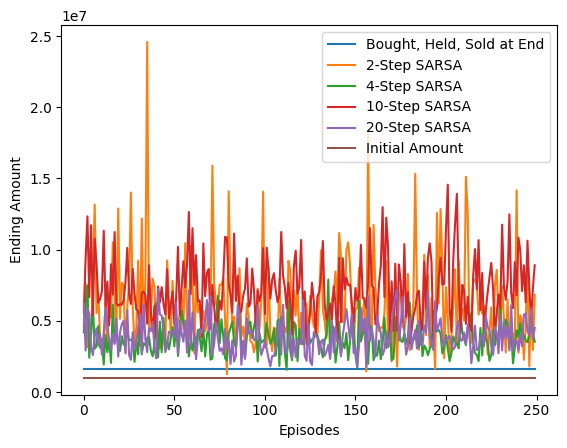

In [223]:
starting_value = trade[(trade['date'] == '2020-07-01') & (trade['tic'] == 'AAPL')]['open'].values[0]
stocks = 1_000_000 / starting_value

end_value =trade[(trade['date'] == '2021-10-29') & (trade['tic'] == 'AAPL')]['open'].values[0]
end_amount_if_bought_and_held = end_value * stocks

plt.plot(list(range(EPISODES)), [end_amount_if_bought_and_held] * EPISODES, label='Bought, Held, Sold at End')
plt.plot(list(range(EPISODES)), two_step_sarsa_final_amounts, label='2-Step SARSA')
plt.plot(list(range(EPISODES)), five_step_sarsa_final_amounts, label='5-Step SARSA')
plt.plot(list(range(EPISODES)), ten_step_sarsa_final_amounts, label='10-Step SARSA')
plt.plot(list(range(EPISODES)), twenty_step_sarsa_final_amounts, label='20-Step SARSA')
plt.plot(list(range(EPISODES)), [1_000_000] * EPISODES, label='Initial Amount')
plt.xlabel('Episodes')
plt.ylabel('Ending Amount')
plt.legend()
plt.show()

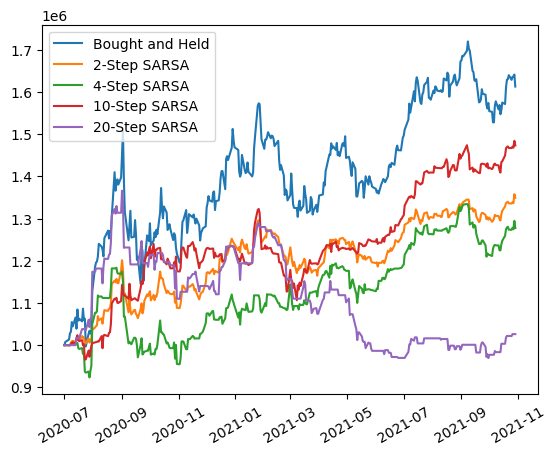

In [236]:
#PLOT COMPARING PORTFOLIO VALUE OF TEST EPISODE AGAINST JUST HOLDING STOCK WITH SARSA AND MC

starting_value = trade[(trade['date'] == '2020-07-01') & (trade['tic'] == 'AAPL')]['open'].values[0]
stocks = 1_000_000 / starting_value
values_while_held = trade[(trade['date'] >= '2020-07-01') & (trade['tic'] == 'AAPL')]['open'].to_numpy() * stocks
dates = np.asarray(trade[(trade['date'] >= '2020-07-01') & (trade['tic'] == 'AAPL')]['date'], dtype='datetime64[s]')
plt.plot(dates, values_while_held, label="Bought and Held")
plt.plot(dates, avg_two_step_sarsa_test_values, label="2-Step SARSA")
plt.plot(dates, avg_five_step_sarsa_test_values, label="5-Step SARSA")
plt.plot(dates, avg_ten_step_sarsa_test_values, label="10-Step SARSA")
plt.plot(dates, avg_twenty_step_sarsa_test_values, label="20-Step SARSA")
plt.xticks(rotation=30)
plt.legend()
plt.show()


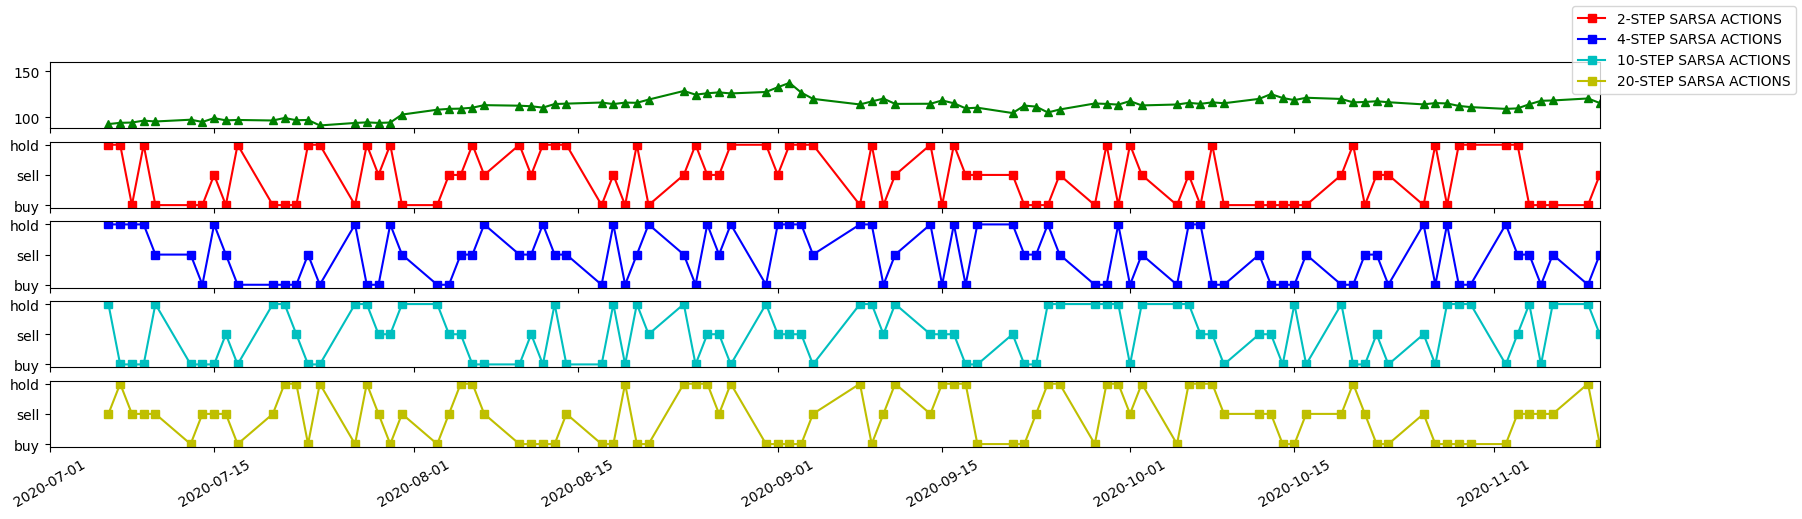

In [221]:
# ACTIONS OVER TEST
two_step_sarsa_test_actions = []
five_step_sarsa_test_actions = []
ten_step_sarsa_test_actions = []
twenty_step_sarsa_test_actions = []
# episode.append((S, A, reward, percent))
action_dates = dates[2:] # account for skipping first two steps to create differences
for step in two_step_sarsa_test_episode[0]:
    action = step[1]
    two_step_sarsa_test_actions.append(action)
for step in five_step_sarsa_test_episode[0]:
    action = step[1]
    five_step_sarsa_test_actions.append(action)
for step in ten_step_sarsa_test_episode[0]:
    action = step[1]
    ten_step_sarsa_test_actions.append(action)
for step in twenty_step_sarsa_test_episode[0]:
    action = step[1]
    twenty_step_sarsa_test_actions.append(action)
fig, axs = plt.subplots(nrows=5, figsize=(20,5), sharex=True)
axs[1].plot(action_dates, two_step_sarsa_test_actions, marker = 's', label = '2-STEP SARSA ACTIONS', c='r')
axs[2].plot(action_dates, five_step_sarsa_test_actions, marker = 's', label = '5-STEP SARSA ACTIONS', c='b')
axs[3].plot(action_dates, ten_step_sarsa_test_actions, marker = 's', label = '10-STEP SARSA ACTIONS', c='c')
axs[4].plot(action_dates, twenty_step_sarsa_test_actions, marker = 's', label = '20-STEP SARSA ACTIONS', c='y')
fig.legend()
plt.xticks(rotation=30)

axs[0].plot(action_dates, trade[(trade['date'] >= '2020-07-01') & (trade['tic'] == 'AAPL')]['open'][2:], marker = '^', label = 'STOCK VALUE', c='g')
for ax in axs[1:]:
    ax.set_xlim(np.asarray(['2020-07-01', '2020-11-10'],  dtype='datetime64[s]'))
    ax.set_yticks([0, 1, 2]) # buy hold sell
    ax.set_yticklabels(['buy', 'sell', 'hold'])


In [222]:
# LENGTH OF EPISODES and Q TABLE SIZE PLOT